# 1. Load packages

In [3]:
import scipy.sparse as sp
import pandas as pd
import scanpy as sc
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
from mygene import MyGeneInfo

In [4]:
import numpy as np
np.NAN = np.nan

In [5]:
import omnipath as op

In [6]:
from markov_clustering import run_mcl, get_clusters

In [7]:
from matplotlib.colors import rgb2hex

In [8]:
import leidenalg

# 2. load node data

In [9]:
from pathlib import Path
import pandas as pd

# 1️⃣ Load prepared data
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

prot_expr_mean = pd.read_csv(in_dir / "proteome_expr_mean.csv", index_col=0)
phospho_expr_mean = pd.read_csv(in_dir / "phosphoproteome_expr_mean.csv", index_col=0)
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

prot_fc = pd.read_csv(in_dir / "proteome_fc.csv", index_col=0)
phospho_fc = pd.read_csv(in_dir / "phosphoproteome_fc.csv", index_col=0)

detected_uniprots = pd.read_csv(in_dir / "detected_uniprots.txt", header=None)[0].tolist()

print(f"Loaded {len(detected_uniprots)} detected UniProt IDs.")
print(f"Combined table: {combined_expr_mean.shape}")


Loaded 2916 detected UniProt IDs.
Combined table: (2915, 28)


In [10]:
phospho_fc

logFC.10  P.Value.10  adj.P.Val.10  logFC.600  P.Value.600  \
UniProt                                                                  
A0A1B0GUW6 -0.487630    0.237964      0.609327  -0.121132     0.768297   
A0FGR8      0.112968    0.561838      0.836479  -0.631699     0.001758   
A0FGR8     -0.336258    0.216695      0.585516   0.364801     0.180614   
A0FGR8      0.214166    0.098726      0.419050   0.162217     0.209094   
A0FGR8      0.177454    0.753409      0.918455   0.484828     0.391870   
...              ...         ...           ...        ...          ...   
Q9Y6M1      0.196720    0.080672      0.393156  -0.028385     0.798778   
Q9Y6M7     -0.544588    0.125577      0.455553   0.391082     0.269275   
Q9Y6N5     -0.429944    0.052719      0.322845   0.284007     0.197085   
Q9Y6R4      0.010666    0.886990      0.963787   0.027229     0.716873   
Q9Y6W5     -0.550397    0.154505      0.506236   0.352554     0.359595   

            adj.P.Val.600  logFC.1800  P.Value.1800  adj.P.Val.1800  \
UniProt                                                               
A0A1B0GUW6       0.940300   -1.182801      0.005222        0.070003   
A0FGR8           0.061496    0.024567      0.899486        0.951119   
A0FGR8           0.546526    0.488185      0.074705        0.302857   
A0FGR8           0.569764    0.333042      0.011357        0.106868   
A0FGR8           0.741377    0.658353      0.246055        0.541253   
...                   ...         ...           ...             ...   
Q9Y6M1           0.952402    0.354017      0.002158        0.046987   
Q9Y6M7           0.642588    1.009433      0.005417        0.071691   
Q9Y6N5           0.554106   -0.303134      0.168953        0.448447   
Q9Y6R4           0.920523   -0.110637      0.143662        0.420182   
Q9Y6W5           0.719752   -0.524237      0.174755        0.455950   

                                                     psite_id gene_symbol  
UniProt                                                                    
A0A1B0GUW6  A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...  A0A1B0GUW6  
A0FGR8      A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...       ESYT2  
A0FGR8            A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581       ESYT2  
A0FGR8                 A0FGR8;ESYT2;S739;SSSSLLASPGHISVK;2582       ESYT2  
A0FGR8            A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736       ESYT2  
...                                                       ...         ...  
Q9Y6M1              Q9Y6M1;IGF2BP2;S162;ISYIPDEEVSSPSPPQR;698     IGF2BP2  
Q9Y6M7                     Q9Y6M7;SLC4A7;S242;KHSDPHLLER;4036      SLC4A7  
Q9Y6N5                Q9Y6N5;SQOR;S343;YPNVFGIGDCTNLPTSK;1825        SQOR  
Q9Y6R4               Q9Y6R4;MAP3K4;S1252;HSSPTEERDEPAYPR;4675      MAP3K4  
Q9Y6W5      Q9Y6W5;WASF2;T129;NSLPVPVLETYNTCDTPPPLNNLTPYR;...       WASF2  

[3150 rows x 11 columns]

# 3. Get edges

## 3.1.  Download OmniPath interactions

In [11]:
from omnipath.interactions import OmniPath

# 1. See what parameters and resources are available
print("Query params:", OmniPath.params())        # dict of valid query-args :contentReference[oaicite:0]{index=0}
print("All resources:", OmniPath.resources())    # tuple of resource names :contentReference[oaicite:1]{index=1}

# 2. Download the full curated OmniPath network
inter = OmniPath.get()                          
print(f"Raw OmniPath: {inter.shape[0]:,} interactions")   # DataFrame



Query params: {'header': None, 'format': frozenset({'tab', 'text', 'json', 'table', 'tsv'}), 'license': frozenset({'academic', 'ignore', 'commercial', 'for_profit', 'forprofit', 'non_profit', 'nonprofit'}), 'password': None, 'limit': None, 'types': frozenset({'lncrna_post_transcriptional', 'mirna_transcriptional', 'small_molecule_protein', 'post_translational', 'post_transcriptional', 'transcriptional'}), 'sources': None, 'resources': None, 'databases': frozenset({'Reactome_SignaLink3', 'Pavlidis2021_CollecTRI', 'PhosphoSite_KEA', 'Sparser_ProtMapper', 'CellTalkDB', 'DoRothEA-A_CollecTRI', 'KEGG-MEDICUS', 'Guide2Pharma_Cellinker', 'MPPI', 'NFIRegulomeDB_DoRothEA', 'phosphoELM_MIMP', 'SignaLink3', 'LMPID', 'SIGNOR_ProtMapper', 'talklr', 'CancerCellMap', 'HTRIdb', 'ReMap_DoRothEA', 'ORegAnno_DoRothEA', 'Cui2007', 'ENCODE_tf-mirna', 'PAZAR', 'CellCall', 'NetPath', 'Reactome_LRdb', 'Fantom5_LRdb', 'phosphoELM', 'TransmiR', 'HPMR_talklr', 'iTALK', 'HPRD-phos', 'IntAct_CollecTRI', 'iPTMnet',

In [12]:
# --- Define which resources to focus on (if desired) ---
focus_resources = [
    # Core signaling
    "KEGG", "Reactome", "SIGNOR",
    # Gene regulons
    "DoRothEA", "TRRUST",
    # PPI scaffold
    "BioGRID", "IntAct",
    # PTM detail (optional)
    "PhosphoSite", "iPTMnet",
    # Cell–cell communication
    "CellPhoneDB",
    # Legacy / additional
    "UniProt_LRdb", "HPRD", "Adhesome"
]

# --- Toggle filtering ---
use_mask = False  # Set to False to skip filtering by source

# --- Apply mask if requested ---
if use_mask:
    mask = inter["sources"].str.split(";").apply(
        lambda srcs: any(r in srcs for r in focus_resources)
    )
    inter = inter.loc[mask].copy()
    print(f"After resource filter: {inter.shape[0]:,} interactions")
else:
    print(f"Skipping resource filter: using all {inter.shape[0]:,} interactions")


Skipping resource filter: using all 81,529 interactions


In [13]:
inter

source  target  is_directed  is_stimulation  is_inhibition  \
0      P0DP23  P48995         True           False           True   
1      P0DP25  P48995         True           False           True   
2      P0DP24  P48995         True           False           True   
3      Q03135  P48995         True            True          False   
4      P14416  P48995         True            True          False   
...       ...     ...          ...             ...            ...   
81524  P12931  Q9UJM3         True           False          False   
81525  P43405  Q9ULZ3         True           False          False   
81526  Q14289  Q9ULZ3         True           False          False   
81527  P54646  Q9Y2I7         True           False          False   
81528  P24941  Q9Y3Z3         True           False          False   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
0                     True                  False                  True   
1                     True                  False                  True   
2                     True                  False                  True   
3                     True                   True                 False   
4                     True                   True                 False   
...                    ...                    ...                   ...   
81524                False                  False                 False   
81525                False                  False                 False   
81526                False                  False                 False   
81527                False                  False                 False   
81528                False                  False                 False   

       curation_effort                                         references  \
0                    3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
1                    3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
2                    3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
3                   13  DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...   
4                    1                                      TRIP:18261457   
...                ...                                                ...   
81524                2               ProtMapper:26280531;iPTMnet:26280531   
81525                2               ProtMapper:25605870;iPTMnet:25605870   
81526                2               ProtMapper:27796369;iPTMnet:27796369   
81527                1                                   iPTMnet:24070423   
81528                7  ProtMapper:24623419;ProtMapper:26667483;ProtMa...   

                                                 sources  n_sources  \
0                                                   TRIP          1   
1                                                   TRIP          1   
2                                                   TRIP          1   
3                         DIP;HPRD;IntAct;Lit-BM-17;TRIP          5   
4                                                   TRIP          1   
...                                                  ...        ...   
81524              ProtMapper;RLIMS-P_ProtMapper;iPTMnet          3   
81525              ProtMapper;RLIMS-P_ProtMapper;iPTMnet          3   
81526              ProtMapper;RLIMS-P_ProtMapper;iPTMnet          3   
81527                                            iPTMnet          1   
81528  HPRD_MIMP;MIMP;PhosphoSite_MIMP;PhosphoSite_Pr...          9   

       n_primary_sources n_references  \
0                      1            3   
1                      1            3   
2                      1            3   
3                      5            8   
4                      1            1   
...                  ...          ...   
81524                  2            1   
81525                  2            1   
81526                  2            1   
81527                  1            1   
81528                  3            6   

      

## 3.2.  Quality filters  (mirror your R code)

In [14]:
import numpy as np

# 1. Copy from the correct DataFrame (not the built-in iter)
df = inter.copy()

# 2. Base QC: curation effort & consensus direction
df = df[df["curation_effort"] >= 2]
#df = df[df["consensus_direction"] == 2]

# 3. Assign signed “type” and drop ambiguous edges
df["type"] = np.nan
df.loc[
    df["is_stimulation"].astype(bool) | df["consensus_stimulation"].astype(bool),
    "type"
] = "activation"
df.loc[
    df["is_inhibition"].astype(bool)  | df["consensus_inhibition"].astype(bool),
    "type"
] = "inhibition"
df = df.dropna(subset=["type"])

# 4. Publication support: ≥2 distinct papers
df = df[df["n_references"] >= 2]

# 5. Cross-resource consensus: seen in ≥2 resources
df = df[df["n_sources"] >= 1]

print(f"Rows after HQ filtering: {df.shape[0]:,}")
df.head()


Rows after HQ filtering: 10,135


/tmp/ipykernel_1899592/1354645508.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'activation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[


source  target  is_directed  is_stimulation  is_inhibition  \
0  P0DP23  P48995         True           False           True   
1  P0DP25  P48995         True           False           True   
2  P0DP24  P48995         True           False           True   
3  Q03135  P48995         True            True          False   
5  Q99750  P48995         True           False           True   

   consensus_direction  consensus_stimulation  consensus_inhibition  \
0                 True                  False                  True   
1                 True                  False                  True   
2                 True                  False                  True   
3                 True                   True                 False   
5                 True                  False                  True   

   curation_effort                                         references  \
0                3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
1                3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
2                3          TRIP:11290752;TRIP:11983166;TRIP:12601176   
3               13  DIP:19897728;HPRD:12732636;IntAct:19897728;Lit...   
5                3          HPRD:14530267;TRIP:14530267;TRIP:23770672   

                          sources  n_sources  n_primary_sources n_references  \
0                            TRIP          1                  1            3   
1                            TRIP          1                  1            3   
2                            TRIP          1                  1            3   
3  DIP;HPRD;IntAct;Lit-BM-17;TRIP          5                  5            8   
5                       HPRD;TRIP          2                  2            2   

                                 references_stripped        type  
0                         11290752;11983166;12601176  inhibition  
1                         11290752;11983166;12601176  inhibition  
2                         11290752;11983166;12601176  inhibition  
3  10980191;12732636;14551243;16822931;18430726;1...  activation  
5                                  14530267;23770672  inhibition

## 3.3.  Quick glance at interaction types

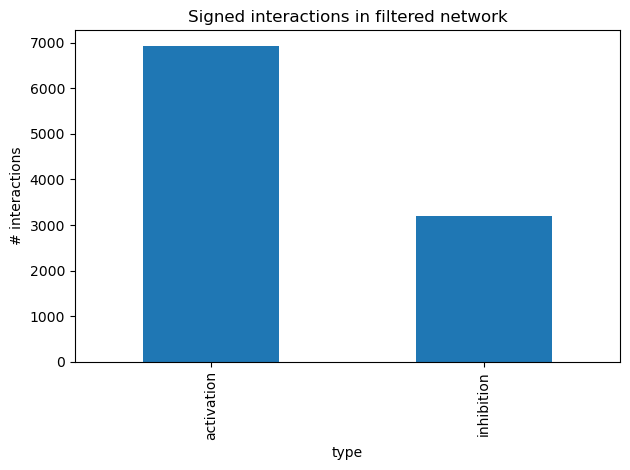

In [15]:
type_counts = df["type"].value_counts()
ax = type_counts.plot(kind="bar")
ax.set_ylabel("# interactions")
ax.set_title("Signed interactions in filtered network")
plt.tight_layout()
plt.show()

# 4. Build networks

## 4.0 inspect combined intensity table

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load combined table
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

print(f"Combined expression table shape: {combined_expr_mean.shape}")
display(combined_expr_mean.head(20))

# Optionally inspect numeric vs annotation columns
print("Numeric columns:", [c for c in combined_expr_mean.columns if combined_expr_mean[c].dtype != "object"][:10])
print("Non-numeric columns:", [c for c in combined_expr_mean.columns if combined_expr_mean[c].dtype == "object"])


Combined expression table shape: (2915, 28)


10_CXCR7_prot  600_CXCR7_prot  1800_CXCR7_prot  0_Ctrl_prot  \
UniProt                                                                   
A0A075B6I0      32.300198       32.279510        32.241415    32.233940   
A0A0A0MS15      22.607773       22.514187        22.495981    22.369619   
A0A0B4J1U7      13.584549       13.543775        13.642663    13.532822   
A0A0B4J1X5      29.572116       29.697423        29.649465    29.559103   
A0A0B4J1Y9      24.277022       24.283101        24.288321    24.264258   
A0A0C4DH43      20.924079       20.710393        20.581266    20.630867   
A0A1B0GUW6            NaN             NaN              NaN          NaN   
A0AVT1          11.487514       11.534193        11.517483    11.584648   
A0FGR8          20.622261       20.631675        20.665422    20.621037   
A1A4S6          29.505932       29.483070        29.552411    29.459800   
A1L0T0         -27.481598      -27.015436       -27.589805   -27.156975   
A1L390                NaN             NaN              NaN          NaN   
A2A2Y4                NaN             NaN              NaN          NaN   
A2RRP1          21.974815       22.197399        21.940602    21.774804   
A2RUS2          24.764790       24.733365        24.695503    24.802422   
A5YKK6          40.108087       39.931702        39.822391    39.823201   
A6NDU8          25.919773       25.855524        25.843949    25.924009   
A6NFX1          33.536257       34.023253        33.665010    33.731988   
A6NHL2          26.640880       26.408442        26.784751    26.336216   
A6NIZ1          17.128561       16.820794        16.565094    17.625976   

            10_DMSO_prot  600_DMSO_prot  1800_DMSO_prot source_prot  \
UniProt                                                               
A0A075B6I0     32.208463      32.214118       32.282510    proteome   
A0A0A0MS15     22.566267      22.504021       22.583532    proteome   
A0A0B4J1U7     13.524586      13.556860       13.520838    proteome   
A0A0B4J1X5     29.488391      29.691739       29.613414    proteome   
A0A0B4J1Y9     24.315194      24.220384       24.255841    proteome   
A0A0C4DH43     20.622972      20.419420       20.562545    proteome   
A0A1B0GUW6           NaN            NaN             NaN         NaN   
A0AVT1         11.445340      11.451980       11.441634    proteome   
A0FGR8         20.614230      20.658704       20.621974    proteome   
A1A4S6         29.481303      29.530069       29.548369    proteome   
A1L0T0        -27.684491     -26.710873      -27.235188    proteome   
A1L390               NaN            NaN             NaN         NaN   
A2A2Y4               NaN            NaN             NaN         NaN   
A2RRP1         21.924916      21.924311       21.933672    proteome   
A2RUS2         24.706444      24.815624       24.825766    proteome   
A5YKK6         39.514366      39.934316       39.975229    proteome   
A6NDU8         25.864581      25.858298       25.890519    proteome   
A6NFX1         33.419670      33.749341       33.626693    proteome   
A6NHL2         26.614485      26.673246       26.582646    proteome   
A6NIZ1         17.364398      17.108857       16.837356    proteome   

            10_CXCR7_phos  600_CXCR7_phos  ...  has_phospho  \
UniProt                                    ...                
A0A075B6I0            NaN             NaN  ...        False   
A0A0A0MS15            NaN             NaN  ...        False   
A0A0B4J1U7            NaN             NaN  ...        False   
A0A0B4J1X5            NaN             NaN  ...        False   
A0A0B4J1Y9            NaN             NaN  ...        False   
A0A0C4DH43            NaN             NaN  ...        False   
A0A1B0GUW6      18.967803       19.470706  ...         True   
A0AVT1                NaN             NaN  ...        False   
A0FGR8          23.589772       22.860872  ...         True   
A1A4S6          18.728015       19.068631  ...         True   
A1L0T0                NaN             NaN 

Numeric columns: ['10_CXCR7_prot', '600_CXCR7_prot', '1800_CXCR7_prot', '0_Ctrl_prot', '10_DMSO_prot', '600_DMSO_prot', '1800_DMSO_prot', '10_CXCR7_phos', '600_CXCR7_phos', '1800_CXCR7_phos']
Non-numeric columns: ['source_prot', 'source_phos', 'gene_symbol', 'source_combined']


In [17]:
print( combined_expr_mean.columns)

Index(['10_CXCR7_prot', '600_CXCR7_prot', '1800_CXCR7_prot', '0_Ctrl_prot',
       '10_DMSO_prot', '600_DMSO_prot', '1800_DMSO_prot', 'source_prot',
       '10_CXCR7_phos', '600_CXCR7_phos', '1800_CXCR7_phos', '0_Ctrl_phos',
       '10_DMSO_phos', '600_DMSO_phos', '1800_DMSO_phos', 'source_phos',
       'gene_symbol', 'has_proteome', 'has_phospho', '10_CXCR7_combined',
       '600_CXCR7_combined', '1800_CXCR7_combined', '0_Ctrl_combined',
       '10_DMSO_combined', '600_DMSO_combined', '1800_DMSO_combined',
       'source_combined', 'haspho_combined'],
      dtype='object')


## 4.1 big network 

In [18]:
import igraph as ig
import pandas as pd

# ======================================================
# ⚙️ 1. Load prepared data (if not already in memory)
# ======================================================
from pathlib import Path
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)
detected_uniprots = combined_expr_mean.index.tolist()

print(f"Detected UniProt IDs: {len(detected_uniprots)}")


# ======================================================
# 🧠 2. Filter OmniPath edges to measured nodes
# ======================================================
df_expr = df[
    df["source"].isin(detected_uniprots) &
    df["target"].isin(detected_uniprots)
].copy()

print(f"Edges after expression filter: {df_expr.shape[0]:,} of {df.shape[0]:,}")


# ======================================================
# 🧬 3. Build mapping UniProt → gene symbol
# ======================================================
symbol_map = combined_expr_mean["gene_symbol"].to_dict()


# ======================================================
# 🧩 4. Annotate edges with source/target symbols
# ======================================================
df_expr["source_symbol"] = df_expr["source"].map(symbol_map)
df_expr["target_symbol"] = df_expr["target"].map(symbol_map)


# ======================================================
# 🔗 5. Build igraph network
# ======================================================
edge_tuples = df_expr[["source", "target", "type"]].itertuples(index=False, name=None)

g_full = ig.Graph.TupleList(
    edge_tuples,
    directed=True,
    edge_attrs=["type"]
)

print(f"🌐 Global network constructed:")
print(f"   Nodes: {g_full.vcount():,}")
print(f"   Edges: {g_full.ecount():,}")


# ======================================================
# 🧩 6. Annotate vertices with symbols and metadata
# ======================================================
g_full.vs["gene_symbol"] = [symbol_map.get(v["name"], v["name"]) for v in g_full.vs]

# Optional: Mark which nodes have proteome/phosphoproteome data
has_prot = combined_expr_mean.loc[:, "has_proteome"].to_dict() if "has_proteome" in combined_expr_mean.columns else {}
has_phos = combined_expr_mean.loc[:, "has_phospho"].to_dict() if "has_phospho" in combined_expr_mean.columns else {}

g_full.vs["has_proteome"] = [has_prot.get(v["name"], False) for v in g_full.vs]
g_full.vs["has_phospho"] = [has_phos.get(v["name"], False) for v in g_full.vs]


# ======================================================
# 🔍 7. Preview and sanity check
# ======================================================
print("Example vertices:")
for v in g_full.vs[:10]:
    print(f"{v['name']:<12} → {v['gene_symbol']:<10} | prot:{v['has_proteome']} | phos:{v['has_phospho']}")

print("\nExample edges:")
print(df_expr.sample(5))


Detected UniProt IDs: 2915
Edges after expression filter: 1,585 of 10,135
🌐 Global network constructed:
   Nodes: 647
   Edges: 1,585
Example vertices:
P0DP24       → CALM2      | prot:True | phos:False
Q9Y210       → TRPC6      | prot:True | phos:True
P06241       → FYN        | prot:True | phos:True
P49137       → MAPKAPK2   | prot:True | phos:True
Q16539       → MAPK14     | prot:True | phos:True
P31749       → AKT1       | prot:True | phos:True
O15111       → CHUK       | prot:True | phos:False
P19838       → NFKB1      | prot:True | phos:False
P27986       → PIK3R1     | prot:True | phos:False
P78536       → ADAM17     | prot:False | phos:True

Example edges:
       source  target  is_directed  is_stimulation  is_inhibition  \
4313   P40763  Q04206         True            True          False   
14049  P03952  P00748         True            True          False   
5529   Q99683  P45985         True            True          False   
2098   Q9NQC7  Q9Y6K9         True           False 

## 4.2. Extract Giant Connected Component (GCC)

In [19]:
import igraph as ig

print("Vertex attributes:", g_full.vs.attributes())
print("Edge attributes:", g_full.es.attributes())

# Build GCC (weakly connected)
components = g_full.components(mode="weak")
g_gcc = components.giant()

print(f"🌐 Global network: {g_full.vcount()} nodes, {g_full.ecount()} edges")
print(f"🧩 Largest component (GCC): {g_gcc.vcount()} nodes, {g_gcc.ecount()} edges")


Vertex attributes: ['name', 'gene_symbol', 'has_proteome', 'has_phospho']
Edge attributes: ['type']
🌐 Global network: 647 nodes, 1585 edges
🧩 Largest component (GCC): 581 nodes, 1547 edges


## 4.3 Build GCC & Subnetworks with Source-Specific Thresholds

In [20]:
import igraph as ig
import pandas as pd
import numpy as np
from pathlib import Path

# ======================================================
# ⚙️ 1. Parameters
# ======================================================
PROTEOME_THRESHOLD = 9         # Stable proteome backbone threshold
PHOSPHO_THRESHOLD = 12.75      # Dynamic phosphosite threshold
EXPORT_GRAPHML = True          # Export subnetworks to GraphML
VERBOSE = True                 # Print detailed per-condition info

print(f"🧩 Using thresholds — Proteome backbone: {PROTEOME_THRESHOLD}, Phospho dynamic: {PHOSPHO_THRESHOLD}")

# ======================================================
# 📂 2. Load combined expression data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"
merged_path = in_dir / "combined_expr_mean.csv"

if not merged_path.exists():
    raise FileNotFoundError(f"❌ Missing input file: {merged_path}")

merged = pd.read_csv(merged_path, index_col=0)
print(f"📄 Loaded combined expression table: {merged.shape[0]} proteins × {merged.shape[1]} columns")

# Identify timepoint columns (combined)
combined_cols = [
    c for c in merged.columns
    if "_combined" in c and not c.startswith(("source", "haspho"))
]
conditions = [c.replace("_combined", "") for c in combined_cols]
print(f"✅ Detected {len(conditions)} timepoints: {conditions}")

# Ensure numeric values
merged[combined_cols] = merged[combined_cols].apply(pd.to_numeric, errors="coerce")

# Normalize source labels
merged["source_combined"] = merged["source_combined"].astype(str).str.strip().str.lower()

# ======================================================
# 🧬 3. Define the static proteome backbone
# ======================================================
backbone_mask = (
    (merged["source_combined"] != "phosphoproteome") &
    (merged[combined_cols].max(axis=1) > PROTEOME_THRESHOLD)
)
backbone_nodes = merged.index[backbone_mask].tolist()

print(f"🧬 Static proteome backbone established: {len(backbone_nodes)} nodes > {PROTEOME_THRESHOLD}")

# ======================================================
# 🧩 4. Build subnetworks per condition/timepoint
# ======================================================
if "g_gcc" not in globals():
    raise RuntimeError("❌ Variable g_gcc (Giant Connected Component graph) not defined in environment.")

subnetworks = {}
summary_records = []

for cond in conditions:
    expr_col = f"{cond}_combined"
    if expr_col not in merged.columns:
        print(f"⚠️ Skipping missing expression column: {expr_col}")
        continue

    # ---- Select dynamic phospho nodes ----
    phospho_mask = (
        (merged["source_combined"] == "phosphoproteome") &
        (merged[expr_col] > PHOSPHO_THRESHOLD)
    )
    phospho_active = merged.index[phospho_mask].tolist()

    # ---- Merge backbone + dynamic ----
    active_nodes = list(set(backbone_nodes) | set(phospho_active))
    active_nodes = [n for n in active_nodes if n in g_gcc.vs["name"]]  # restrict to GCC
    sub_g = g_gcc.subgraph(g_gcc.vs.select(name_in=active_nodes))
    subnetworks[cond] = sub_g

    n_prot = len(set(backbone_nodes) & set(active_nodes))
    n_phospho = len(set(phospho_active) & set(g_gcc.vs["name"]))
    summary_records.append((cond, sub_g.vcount(), sub_g.ecount(), n_prot, n_phospho))

    if VERBOSE:
        print(f"{cond:<12}: {sub_g.vcount():>4} nodes ({n_prot} prot, {n_phospho} phospho), {sub_g.ecount():>5} edges")

# ======================================================
# 📊 5. Summarize and compute network metrics
# ======================================================
def summarize_network(g: ig.Graph, label: str) -> pd.DataFrame:
    """Compute key centrality metrics for a given subnetwork."""
    if g.vcount() == 0:
        return pd.DataFrame()
    return pd.DataFrame({
        "uniprot_id": g.vs["name"],
        "gene_symbol": g.vs["gene_symbol"],
        "betweenness": g.betweenness(directed=True),
        "degree": g.degree(),
        "in_degree": g.degree(mode="in"),
        "out_degree": g.degree(mode="out"),
        "density": g.density(),
        "network": label
    })

subnet_metrics = pd.concat(
    [summarize_network(g, cond) for cond, g in subnetworks.items()],
    ignore_index=True
)

print(f"\n✅ Computed metrics for {len(subnetworks)} subnetworks "
      f"({subnet_metrics.shape[0]} total nodes)")

# ======================================================
# 💾 6. Save results
# ======================================================
out_dir = in_dir.parent / "subnetworks"
out_dir.mkdir(exist_ok=True)

# Save metrics
metrics_path = out_dir / "subnetwork_metrics.csv"
subnet_metrics.to_csv(metrics_path, index=False)
print(f"💾 Saved subnetwork metrics → {metrics_path}")

# Save network summaries
summary_df = pd.DataFrame(summary_records, columns=["Condition", "Nodes", "Edges", "Proteome", "Phospho"])
summary_df.to_csv(out_dir / "subnetwork_summary.csv", index=False)
print(f"💾 Saved subnetwork summary → {out_dir / 'subnetwork_summary.csv'}")

# Optional: Export each subnetwork to GraphML
if EXPORT_GRAPHML:
    for cond, g_sub in subnetworks.items():
        path = out_dir / f"{cond}_subnetwork.graphml"
        g_sub.write_graphml(str(path))
    print(f"📂 Exported {len(subnetworks)} subnetworks to GraphML in {out_dir}")

print("\n✅ Finished building static-backbone, dynamic-phospho subnetworks.")


🧩 Using thresholds — Proteome backbone: 9, Phospho dynamic: 12.75
📄 Loaded combined expression table: 2915 proteins × 28 columns
✅ Detected 7 timepoints: ['10_CXCR7', '600_CXCR7', '1800_CXCR7', '0_Ctrl', '10_DMSO', '600_DMSO', '1800_DMSO']
🧬 Static proteome backbone established: 1443 nodes > 9
10_CXCR7    :  464 nodes (190 prot, 274 phospho),  1078 edges
600_CXCR7   :  465 nodes (190 prot, 275 phospho),  1105 edges
1800_CXCR7  :  467 nodes (190 prot, 277 phospho),  1098 edges
0_Ctrl      :  463 nodes (190 prot, 273 phospho),  1074 edges
10_DMSO     :  463 nodes (190 prot, 273 phospho),  1076 edges
600_DMSO    :  466 nodes (190 prot, 276 phospho),  1097 edges
1800_DMSO   :  461 nodes (190 prot, 271 phospho),  1069 edges

✅ Computed metrics for 7 subnetworks (3249 total nodes)
💾 Saved subnetwork metrics → analysis/networks/subnetworks/subnetwork_metrics.csv
💾 Saved subnetwork summary → analysis/networks/subnetworks/subnetwork_summary.csv
📂 Exported 7 subnetworks to GraphML in analysis/ne

## 4.4 Check for proteins of interest

In [240]:
import pandas as pd
import igraph as ig

def inspect_protein_across_layers(
    gene_symbol,
    uniprot_id,
    inter,         # raw OmniPath (edges)
    df,            # HQ filtered OmniPath (edges or nodes)
    combined_expr_mean,  # expression table (nodes)
    df_expr,       # expression-filtered OmniPath (edges)
    g_gcc          # network (giant component)
):
    """Inspect a protein across multiple dataset layers with robust type detection."""

    def _section(title):
        print("=" * 70)
        print(f"🔎 {title}")
        print("=" * 70)

    def _detect_edge_cols(df_like, name="dataset"):
        """Detect edge column names (source/target) dynamically."""
        possible_sources = ["source", "uniprot_source", "from", "src", "A", "geneA"]
        possible_targets = ["target", "uniprot_target", "to", "tgt", "B", "geneB"]
        src = next((c for c in possible_sources if c in df_like.columns), None)
        tgt = next((c for c in possible_targets if c in df_like.columns), None)
        if not src or not tgt:
            print(f"⚙️ {name} appears node-level (no edges). Skipping edge lookup.")
            return None, None
        else:
            print(f"✅ {name}: using columns '{src}' (source), '{tgt}' (target)")
        return src, tgt

    print(f"\n🔬 Checking presence of {gene_symbol} ({uniprot_id}) across datasets...\n")

    # ======================================================
    # 1️⃣ Raw OmniPath
    # ======================================================
    _section("1️⃣ Raw OmniPath (unfiltered)")
    src_raw, tgt_raw = _detect_edge_cols(inter, "Raw OmniPath")
    if src_raw and tgt_raw:
        raw_hits = inter[(inter[src_raw] == uniprot_id) | (inter[tgt_raw] == uniprot_id)]
    else:
        raw_hits = pd.DataFrame()
    print(f"📦 Raw OmniPath total: {len(inter):,} edges")
    print(f" → {len(raw_hits):,} edges involve {gene_symbol}")
    display(raw_hits.head(10)) if not raw_hits.empty else print(f"⚠️ {gene_symbol} not found in raw OmniPath.")

    # ======================================================
    # 2️⃣ HQ Filtered OmniPath
    # ======================================================
    _section("2️⃣ HQ Filtered OmniPath (after curation filter)")
    src_filt, tgt_filt = _detect_edge_cols(df, "HQ Filtered OmniPath")
    if src_filt and tgt_filt:
        filt_hits = df[(df[src_filt] == uniprot_id) | (df[tgt_filt] == uniprot_id)]
        print(f"📊 Filtered OmniPath total: {len(df):,} edges")
        print(f" → {len(filt_hits):,} edges involve {gene_symbol}")
        display(filt_hits.head(10)) if not filt_hits.empty else print(f"⚠️ {gene_symbol} not found in HQ-filtered OmniPath.")
    else:
        filt_hits = pd.DataFrame()

    # ======================================================
    # 3️⃣ Expression Table
    # ======================================================
    _section("3️⃣ Expression Table (combined_expr_mean.csv)")
    if uniprot_id in combined_expr_mean.index:
        expr_hit = combined_expr_mean.loc[[uniprot_id]]
        print(f"✅ {gene_symbol} ({uniprot_id}) present in expression data.")
        display(expr_hit.filter(regex='_combined|gene_symbol'))
    else:
        print(f"⚠️ {gene_symbol} not present in expression table.")

    # ======================================================
    # 4️⃣ Expression-Filtered OmniPath
    # ======================================================
    _section("4️⃣ Expression-Filtered OmniPath (edges between expressed nodes)")
    src_expr, tgt_expr = _detect_edge_cols(df_expr, "Expression-filtered OmniPath")
    if src_expr and tgt_expr:
        expr_filt_hits = df_expr[(df_expr[src_expr] == uniprot_id) | (df_expr[tgt_expr] == uniprot_id)]
    else:
        expr_filt_hits = pd.DataFrame()
    print(f"🧬 Expression-filtered OmniPath total: {len(df_expr):,} edges")
    print(f" → {len(expr_filt_hits):,} edges involve {gene_symbol}")
    display(expr_filt_hits.head(10)) if not expr_filt_hits.empty else print(f"⚠️ {gene_symbol} not found among expressed-node edges.")

    # ======================================================
    # 5️⃣ GCC (network-level representation)
    # ======================================================
    _section("5️⃣ Network representation (GCC)")
    if g_gcc is None or g_gcc.vcount() == 0:
        print("⚠️ GCC network not available or empty.")
        return

    matches = [v for v in g_gcc.vs if v["name"] == uniprot_id or v["gene_symbol"] == gene_symbol]
    if not matches:
        print(f"⚠️ {gene_symbol} ({uniprot_id}) not found in GCC network.")
    else:
        v = matches[0]
        indeg = g_gcc.degree(v, mode="in")
        outdeg = g_gcc.degree(v, mode="out")
        totaldeg = indeg + outdeg
        btw = g_gcc.betweenness(v)
        btw = btw[0] if isinstance(btw, list) else btw
        print(f"✅ {gene_symbol} ({uniprot_id}) found in GCC:")
        print(f"  In-degree:  {indeg}")
        print(f"  Out-degree: {outdeg}")
        print(f"  Total degree: {totaldeg}")
        print(f"  Betweenness: {btw:.4f}")

        # --- Partner info ---
        def _partner_list(v, mode):
            edges = g_gcc.incident(v, mode=mode)
            partners = []
            for e in edges:
                eid = g_gcc.es[e]
                src, tgt = eid.source, eid.target
                partner = src if mode == "in" else tgt
                partners.append((g_gcc.vs[partner]["gene_symbol"], g_gcc.vs[partner]["name"]))
            return partners

        in_partners = _partner_list(v, "in")
        out_partners = _partner_list(v, "out")

        print(f"\n  🔼 Incoming ({len(in_partners)}):")
        for gsym, uid in in_partners[:10]:
            print(f"   - {gsym} ({uid})")

        print(f"\n  🔽 Outgoing ({len(out_partners)}):")
        for gsym, uid in out_partners[:10]:
            print(f"   - {gsym} ({uid})")

    # ======================================================
    # ✅ Summary
    # ======================================================
    print("\n✅ Summary:")
    print(f"  Raw OmniPath edges:        {len(raw_hits):>5}")
    print(f"  HQ Filtered OmniPath:      {len(filt_hits):>5}")
    print(f"  Expression Table present:  {uniprot_id in combined_expr_mean.index}")
    print(f"  Expressed-node edges:      {len(expr_filt_hits):>5}")
    print(f"  In GCC network:            {len(matches) > 0}")
    print("=" * 70)


In [241]:
inspect_protein_across_layers(
    gene_symbol="PRKG1",
    uniprot_id="Q13976",
    inter=inter,
    df=df,
    combined_expr_mean=combined_expr_mean,
    df_expr=df_expr,
    g_gcc=g_gcc
)



🔬 Checking presence of PRKG1 (Q13976) across datasets...

🔎 1️⃣ Raw OmniPath (unfiltered)
✅ Raw OmniPath: using columns 'source' (source), 'target' (target)
📦 Raw OmniPath total: 81,529 edges
 → 108 edges involve PRKG1


source  target  is_directed  is_stimulation  is_inhibition  \
32     Q13976  Q13507         True           False           True   
53     Q13976  Q9HCX4         True            True          False   
2146   Q13976  O14974         True            True           True   
8932   Q13976  Q9Y613         True            True          False   
9838   Q13976  P11831         True            True          False   
10125  Q13976  P41220         True            True          False   
10968  P17252  Q13976         True            True          False   
12129  Q13976  Q9UH03         True            True          False   
12590  Q13976  Q14847         True           False           True   
13896  Q13976  Q15637         True           False           True   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
32                    True                  False                  True   
53                    True                   True                 False   
2146                  True                  False                  True   
8932                  True                   True                 False   
9838                  True                   True                 False   
10125                 True                   True                 False   
10968                 True                   True                 False   
12129                 True                   True                 False   
12590                 True                  False                  True   
13896                 True                  False                  True   

       curation_effort                                         references  \
32                   9  HPRD:14983059;KEA:14983059;ProtMapper:14983059...   
53                   3     SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151   
2146                 8  HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...   
8932                10  HPRD:15051728;KEA:15051728;PhosphoSite:1505172...   
9838                 2                ProtMapper:19778940;SIGNOR:12809504   
10125               10  HPRD-phos:14608379;HPRD:14608379;KEA:14608379;...   
10968                9  HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...   
12129                5  HPRD-phos:15107017;HPRD:15107017;KEA:15107017;...   
12590                7  HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...   
13896                9  HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...   

                                                 sources  n_sources  \
32     HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...         15   
53                                   SIGNOR;TRIP;iPTMnet          3   
2146   HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...         10   
8932   HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...         15   
9838   MIMP;PhosphoSite_MIMP;PhosphoSite_ProtMapper;P...          7   
10125  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Net...         19   
10968  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...         18   
12129  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         10   
12590  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...         15   
13896  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         15   

       n_primary_sources n_references                  references_stripped  
32                     8            2                    14983059;16331690  
53                     3            1                             21402151  
2146                   7            4  10567269;10579722;15194681;19120700  
8932                   9            2                    15051728;21106951  
9838                   3            2                    12809504;19778940  
10125                 10            3           14608379;17570479;24777815  
10968                 10            2                    12609995;17570479  
12129                  6            1                             15107017  
12590                  8            2                    12432067;12571245  
13896                

🔎 2️⃣ HQ Filtered OmniPath (after curation filter)
⚙️ HQ Filtered OmniPath appears node-level (no edges). Skipping edge lookup.
🔎 3️⃣ Expression Table (combined_expr_mean.csv)
✅ PRKG1 (Q13976) present in expression data.


gene_symbol  10_CXCR7_combined  600_CXCR7_combined  \
UniProt                                                      
Q13976        PRKG1          11.572649           11.762265   

         1800_CXCR7_combined  0_Ctrl_combined  10_DMSO_combined  \
UniProt                                                           
Q13976             11.785922        11.818758         11.956233   

         600_DMSO_combined  1800_DMSO_combined  source_combined  \
UniProt                                                           
Q13976           11.565544           11.556775  phosphoproteome   

         haspho_combined  
UniProt                   
Q13976              True

🔎 4️⃣ Expression-Filtered OmniPath (edges between expressed nodes)
✅ Expression-filtered OmniPath: using columns 'source' (source), 'target' (target)
🧬 Expression-filtered OmniPath total: 1,585 edges
 → 11 edges involve PRKG1


source  target  is_directed  is_stimulation  is_inhibition  \
2146   Q13976  O14974         True            True           True   
8932   Q13976  Q9Y613         True            True          False   
10968  P17252  Q13976         True            True          False   
12590  Q13976  Q14847         True           False           True   
13896  Q13976  Q15637         True           False           True   
14441  Q13976  P04792         True           False           True   
32976  Q13976  P50552         True            True           True   
44739  Q13976  Q01970         True           False           True   
63762  Q13976  P31645         True            True          False   
76221  Q13976  O76074         True            True          False   

       consensus_direction  consensus_stimulation  consensus_inhibition  \
2146                  True                  False                  True   
8932                  True                   True                 False   
10968                 True                   True                 False   
12590                 True                  False                  True   
13896                 True                  False                  True   
14441                 True                  False                  True   
32976                 True                  False                  True   
44739                 True                  False                  True   
63762                 True                   True                 False   
76221                 True                   True                 False   

       curation_effort                                         references  \
2146                 8  HPRD:10567269;KEA:10579722;KEA:15194681;ProtMa...   
8932                10  HPRD:15051728;KEA:15051728;PhosphoSite:1505172...   
10968                9  HPRD-phos:12609995;HPRD:12609995;KEA:12609995;...   
12590                7  HPRD:12571245;KEA:12432067;KEA:12571245;ProtMa...   
13896                9  HPRD-phos:10449420;HPRD-phos:17287340;HPRD:104...   
14441                9  KEA:17570479;PhosphoSite:17351657;PhosphoSite:...   
32976               32  HPRD-phos:12576312;HPRD-phos:17287340;HPRD-pho...   
44739               11  HPRD-phos:11278298;HPRD-phos:19651622;HPRD:112...   
63762                7  PhosphoSite:16112691;PhosphoSite:17310063;Phos...   
76221                6  HPRD:2168396;KEA:17570479;KEA:2168396;ProtMapp...   

                                                 sources  n_sources  \
2146   HPRD;KEA;Kinexus_KEA;PhosphoPoint;ProtMapper;R...         10   
8932   HPRD;HPRD_MIMP;KEA;MIMP;PhosphoPoint;PhosphoSi...         15   
10968  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;Kinexus_...         18   
12590  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_MIMP;KEA...         15   
13896  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         15   
14441  HPRD_MIMP;KEA;MIMP;NetworKIN_KEA;PhosphoSite;P...         15   
32976  BEL-Large-Corpus_ProtMapper;HPRD;HPRD-phos;HPR...         21   
44739  HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;Pho...         14   
63762  MIMP;PhosphoSite;PhosphoSite_MIMP;PhosphoSite_...          9   
76221  BEL-Large-Corpus_ProtMapper;HPRD;HPRD_KEA;HPRD...         16   

       n_primary_sources n_references  \
2146                   7            4   
8932                   9            2   
10968                 10            2   
12590                  8            2   
13896                  9            2   
14441                  6            7   
32976                  8           18   
44739                  8            5   
63762                  5            4   
76221                  8            4   

                                     references_stripped        type  \
2146                 10567269;10579722;15194681;19120700  inhibition   
8932                                   15051728;21106951  activation   
10968                                  12609995;17570479  activation   
12590                                  12432067;125

🔎 5️⃣ Network representation (GCC)
✅ PRKG1 (Q13976) found in GCC:
  In-degree:  1
  Out-degree: 10
  Total degree: 11
  Betweenness: 1529.4426

  🔼 Incoming (1):
   - PRKCA (P17252)

  🔽 Outgoing (10):
   - PPP1R12A (O14974)
   - HSPB1 (P04792)
   - PLCB3 (Q01970)
   - FHOD1 (Q9Y613)
   - LASP1 (Q14847)
   - SF1 (Q15637)
   - VASP (P50552)
   - SLC6A4 (P31645)
   - PDE5A (O76074)
   - IRAG1 (Q9Y6F6)

✅ Summary:
  Raw OmniPath edges:          108
  HQ Filtered OmniPath:          0
  Expression Table present:  True
  Expressed-node edges:         11
  In GCC network:            True


# 5. Analyse network

## 5.1 Betweenness Centrality Changes over time

### 5.1.1 Absolute Betweness Centrality Changes over time

Loaded betweenness metrics: (3249, 8)

📊 CXCR7 absolute betweenness shape: (467, 4)
📊 DMSO absolute betweenness shape: (467, 4)

🔍 Computing deviation metrics for all genes...


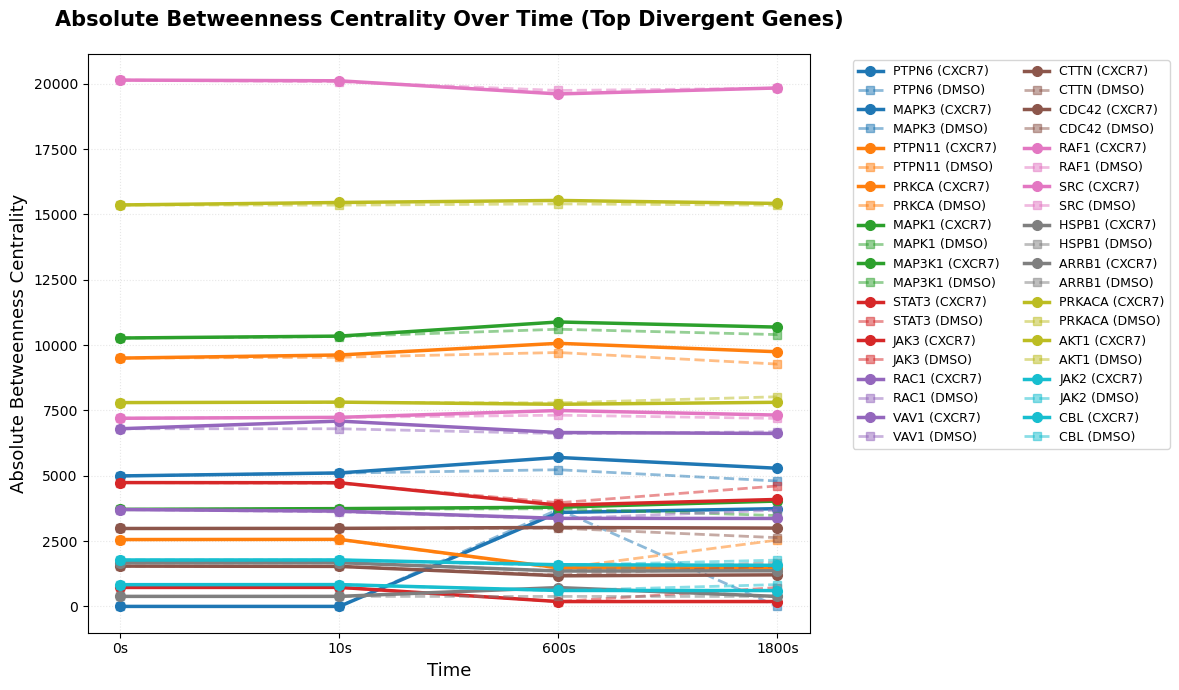

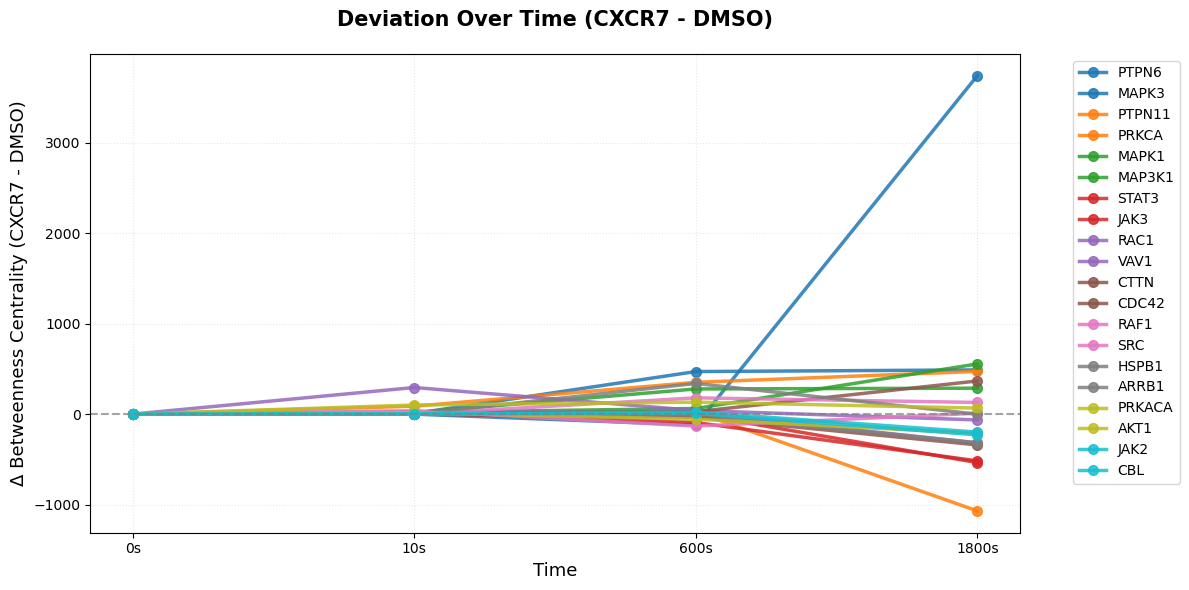


📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)
             Rank uniprot_id                                       phosphosite(s)  dtw_distance  cosine_dissimilarity  euclidean_distance      slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                                                     
PTPN6           1     P29350              P29350;PTPN6;Y536;GQESEYGNITYPPAMK;3261      500.6912                0.3071           3742.2383  1110.1291     0.5744      0.2421        0.3162         0.6838   3740.3241  increasing
MAPK3           2     P27361                                                  NaN      143.9295                0.0010            677.9572   192.8270     0.8203      0.0943        1.0000         0.0000    488.2677  increasing
PTPN11          3     Q06124  Q

In [243]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")

metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    """Return pivot (gene × time) for ABSOLUTE betweenness values."""
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    pivot = df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0, observed=False)
    return pivot

def cosine_dissimilarity(v1, v2):
    """1 - cosine similarity between two trajectories."""
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Dynamic Time Warping distance between two vectors."""
    alignment = dtw(v1.reshape(-1, 1), v2.reshape(-1, 1))
    return float(alignment.normalizedDistance)

def euclidean_distance(v1, v2):
    """Euclidean distance between two vectors."""
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    """Compute linear regression slope of deviation over time."""
    time_numeric = np.arange(len(deviation_series))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, deviation_series)
    return slope, r_value**2, p_value

def compute_monotonic_trend(deviation_series):
    """Compute Spearman correlation for monotonic trend."""
    time_numeric = np.arange(len(deviation_series))
    rho, p_value = spearmanr(time_numeric, deviation_series)
    return rho, p_value

def directional_change(deviation_series):
    """Net change from first to last timepoint."""
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute ABSOLUTE betweenness trajectories
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}

# Align by common genes
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)
cxcr7_absolute = pivots["CXCR7"].loc[common_genes]
dmso_absolute = pivots["DMSO"].loc[common_genes]

# Rename columns to timepoints for easier alignment
timepoints = ['0s', '10s', '600s', '1800s']
cxcr7_absolute.columns = timepoints
dmso_absolute.columns = timepoints

print(f"\n📊 CXCR7 absolute betweenness shape: {cxcr7_absolute.shape}")
print(f"📊 DMSO absolute betweenness shape: {dmso_absolute.shape}")

# ======================================================
# 🧮 Compute DEVIATION metrics (DTW, Cosine, Euclidean)
# ======================================================
print("\n🔍 Computing deviation metrics for all genes...")

divergence = []
for gene in common_genes:
    v_cxcr7 = np.array(cxcr7_absolute.loc[gene], dtype=float)
    v_dmso = np.array(dmso_absolute.loc[gene], dtype=float)
    
    # Compute divergence metrics
    cos_diff = cosine_dissimilarity(v_cxcr7, v_dmso)
    dtw_diff = dtw_distance(v_cxcr7, v_dmso)
    eucl_diff = euclidean_distance(v_cxcr7, v_dmso)
    
    divergence.append((gene, cos_diff, dtw_diff, eucl_diff))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 🧬 Add phosphosite information (merge by UniProt ID)
# ======================================================
phospho_path = base / "analysis" / "networks" / "prepared_data" / "phospho_intensity.csv"

if phospho_path.exists():
    phospho_df = pd.read_csv(phospho_path)
    phospho_df.columns = [c.lower() for c in phospho_df.columns]

    uniprot_col = next((c for c in phospho_df.columns if "uniprot" in c or "accession" in c or "protein" in c), None)
    gene_col = next((c for c in phospho_df.columns if "gene" in c), None)
    site_col = next((c for c in phospho_df.columns if "site" in c or "position" in c or "residue" in c), None)

    if uniprot_col and gene_col:
        subset_cols = [c for c in [gene_col, uniprot_col, site_col] if c]
        phospho_map = phospho_df[subset_cols].drop_duplicates()

        if site_col:
            phospho_map = (
                phospho_map.groupby([gene_col, uniprot_col])[site_col]
                .apply(lambda x: ";".join(sorted(set(x.dropna().astype(str)))))
                .reset_index()
                .rename(columns={site_col: "phosphosite(s)", gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            )
        else:
            phospho_map = phospho_map.rename(columns={gene_col: "gene_symbol", uniprot_col: "uniprot_id"})
            phospho_map["phosphosite(s)"] = np.nan

        if "uniprot_id" in metrics.columns:
            gene_to_uniprot = metrics[["gene_symbol", "uniprot_id"]].drop_duplicates()
        else:
            gene_to_uniprot = phospho_map[["gene_symbol", "uniprot_id"]].drop_duplicates()

        divergence_df = (
            divergence_df.reset_index()
            .merge(gene_to_uniprot, on="gene_symbol", how="left")
            .merge(phospho_map[["uniprot_id", "phosphosite(s)"]], on="uniprot_id", how="left")
            .set_index("gene_symbol")
        )

        front_cols = ["uniprot_id", "phosphosite(s)"]
        divergence_df = divergence_df[[*front_cols, *[c for c in divergence_df.columns if c not in front_cols]]]

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 20
top_genes = divergence_df.head(N_TOP).index
delta_absolute = cxcr7_absolute.loc[top_genes] - dmso_absolute.loc[top_genes]

# ======================================================
# 📈 Compute temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_absolute.loc[gene]
    slope, r2, p_val = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net_change = directional_change(dev_series)
    trend_direction = 'increasing' if slope > 0 else ('decreasing' if slope < 0 else 'stable')
    trend_metrics.append({
        'gene_symbol': gene, 'slope': slope, 'r_squared': r2, 'slope_pval': p_val,
        'spearman_rho': rho, 'spearman_pval': rho_p, 'net_change': net_change, 'trend': trend_direction
    })
trend_df = pd.DataFrame(trend_metrics).set_index('gene_symbol')

# ======================================================
# 🎨 PLOT 1: Absolute betweenness centrality (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

fig, ax = plt.subplots(figsize=(12, 7))

for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    
    # CXCR7: solid line, full color
    ax.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    
    # DMSO: dashed line, lighter shade
    ax.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)

ax.set_title("Absolute Betweenness Centrality Over Time (Top Divergent Genes)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Absolute Betweenness Centrality", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 🎨 PLOT 2: Deviation over time (CXCR7 - DMSO)
# ======================================================
fig, ax = plt.subplots(figsize=(12, 6))

for idx, gene in enumerate(top_genes):
    ax.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)

ax.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax.set_title("Deviation Over Time (CXCR7 - DMSO)", 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=13)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.show()

# ======================================================
# 📊 COMBINED DEVIATION & TREND METRICS TABLES
# ======================================================

# Merge all data
combined_full = divergence_df.join(trend_df).round(4)

# Define column order
optional_cols = [c for c in ['uniprot_id', 'phosphosite(s)'] if c in combined_full.columns]
column_order = ['Rank'] + optional_cols + [
    'dtw_distance', 'cosine_dissimilarity', 'euclidean_distance',
    'slope', 'r_squared', 'slope_pval', 'spearman_rho', 'spearman_pval',
    'net_change', 'trend'
]

# ======================================================
# 📊 TABLE 1: Top genes by DTW distance
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 1: TOP GENES BY DTW DISTANCE (Highest Trajectory Deviation)")
print("="*80)

combined_dtw = combined_full.sort_values('dtw_distance', ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, 'Rank', range(1, len(combined_dtw) + 1))
combined_dtw = combined_dtw[[c for c in column_order if c in combined_dtw.columns]]

print(combined_dtw.to_string())
print("="*80)

# ======================================================
# 📊 TABLE 2: Top genes by POSITIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Deviation)")
print("="*80)

combined_pos = combined_full[combined_full['net_change'] > 0].sort_values('net_change', ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, 'Rank', range(1, len(combined_pos) + 1))
    combined_pos = combined_pos[[c for c in column_order if c in combined_pos.columns]]
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found in top results.")
print("="*80)

# ======================================================
# 📊 TABLE 3: Top genes by NEGATIVE net_change
# ======================================================
print("\n" + "="*80)
print("📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Deviation)")
print("="*80)

combined_neg = combined_full[combined_full['net_change'] < 0].sort_values('net_change', ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, 'Rank', range(1, len(combined_neg) + 1))
    combined_neg = combined_neg[[c for c in column_order if c in combined_neg.columns]]
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found in top results.")
print("="*80)

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_absolute_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7_absolute.to_csv(out_dir / "cxcr7_absolute.csv")
dmso_absolute.to_csv(out_dir / "dmso_absolute.csv")
delta_absolute.to_csv(out_dir / "cxcr7_dmso_delta_absolute.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")

# Save all three tables
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

# Save plots
fig1, ax1 = plt.subplots(figsize=(12, 7))
for idx, gene in enumerate(top_genes):
    base_color = colors[idx]
    ax1.plot(timepoints, cxcr7_absolute.loc[gene], "-o", color=base_color, 
            lw=2.5, label=f"{gene} (CXCR7)", markersize=7)
    ax1.plot(timepoints, dmso_absolute.loc[gene], "--s", color=base_color, 
            lw=2, alpha=0.5, label=f"{gene} (DMSO)", markersize=6)
ax1.set_title("Absolute Betweenness Centrality Over Time (Top Divergent Genes)", 
             fontsize=15, fontweight='bold', pad=20)
ax1.set_xlabel("Time", fontsize=13)
ax1.set_ylabel("Absolute Betweenness Centrality", fontsize=13)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax1.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "absolute_betweenness_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, gene in enumerate(top_genes):
    ax2.plot(timepoints, delta_absolute.loc[gene], "-o", lw=2.5, 
            alpha=0.85, label=gene, color=colors[idx], markersize=7)
ax2.axhline(0, color="gray", ls="--", lw=1.5, alpha=0.7)
ax2.set_title("Deviation Over Time (CXCR7 - DMSO)", 
             fontsize=15, fontweight='bold', pad=20)
ax2.set_xlabel("Time", fontsize=13)
ax2.set_ylabel("Δ Betweenness Centrality (CXCR7 - DMSO)", fontsize=13)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax2.grid(alpha=0.3, ls=":")
plt.tight_layout()
plt.savefig(out_dir / "deviation_trajectories.png", dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ All results saved to: {out_dir}")
print(f"   📄 Data files:")
print(f"      - cxcr7_absolute.csv, dmso_absolute.csv")
print(f"      - cxcr7_dmso_delta_absolute.csv")
print(f"      - trajectory_deviation_metrics.csv")
print(f"      - temporal_trend_metrics.csv")
print(f"      - top_genes_by_dtw.csv (sorted by DTW distance)")
print(f"      - top_genes_positive_netchange.csv (increasing deviation)")
print(f"      - top_genes_negative_netchange.csv (decreasing deviation)")
print(f"   📊 Plot files:")
print(f"      - absolute_betweenness_trajectories.png")
print(f"      - deviation_trajectories.png")

### 5.1.2 Relative betweeness centrality changes - z-score normalized

Loaded betweenness metrics: (3249, 8)

🧮 Using mode: zscore
   CXCR7 shape: (467, 4)
   DMSO shape:  (467, 4)


/tmp/ipykernel_485052/592679341.py:42: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)
/tmp/ipykernel_485052/592679341.py:42: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)



📊 TABLE 1: TOP GENES BY DTW DISTANCE (ZSCORE mode)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                  
CYLD            1                2.0000        1.2990              4.0000  1.3856     0.6000      0.2254        0.7746         0.2254      4.6188  increasing
BIRC6           2                2.0000        1.2990              4.0000  1.3856     0.6000      0.2254        0.7746         0.2254      4.6188  increasing
MAP3K1          3                1.9505        1.1435              3.9502  1.4572     0.6804      0.1751        1.0000         0.0000      4.7470  increasing
RGS19           4                1.9428        1.1052              3.9424  1.3608     0.5957      0.2282        0.3162         0.6838      4.5441  increasing


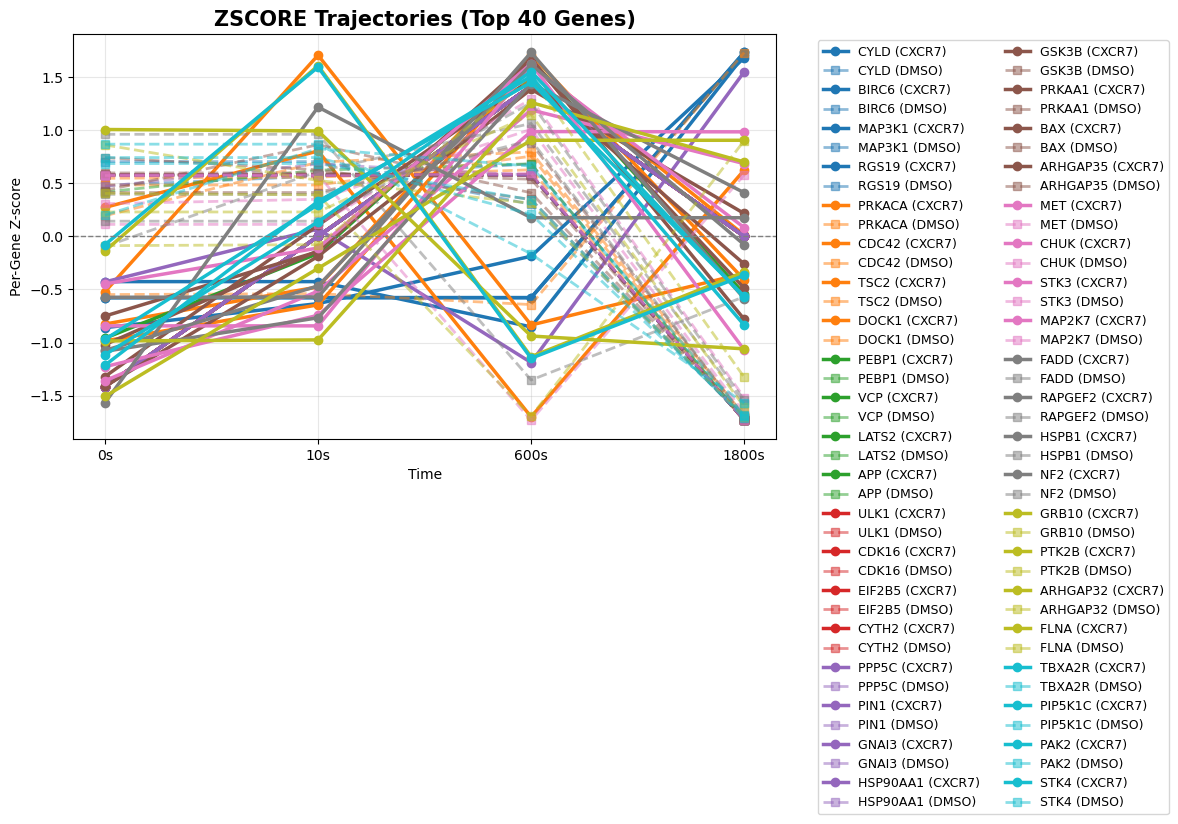

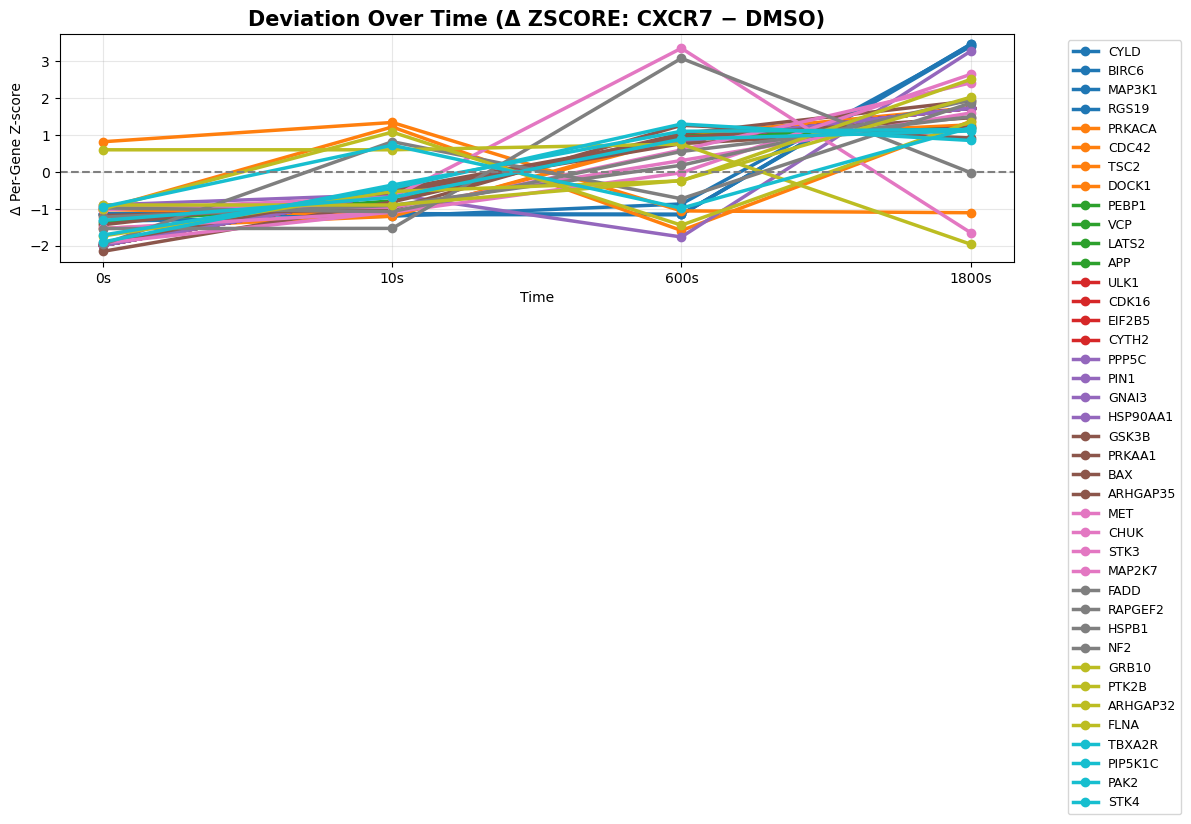


✅ Results saved to analysis/networks/subnetworks/betweenness_zscore_dynamics
   Mode: zscore
   📄 Files saved: metrics, top genes, plots, and trends


In [262]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# ⚙️ Select normalization mode: "absolute", "log2fc", "zscore"
# ======================================================
MODE = "zscore"  # options: "absolute", "log2fc", "zscore"

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)

def log2_fold_change_baseline0(pivot):
    baseline = pivot.iloc[:, 0].replace(0, np.nan)
    lfc = np.log2(pivot.div(baseline, axis=0))
    lfc = lfc.fillna(0)
    lfc.columns = timepoints
    return lfc

def zscore_per_gene(pivot):
    """Standard per-gene Z-score normalization (not baseline-anchored)."""
    norm = pivot.copy()
    for gene in pivot.index:
        vals = pivot.loc[gene].values
        if np.std(vals) > 0:
            z = (vals - np.mean(vals)) / np.std(vals)
        else:
            z = np.zeros_like(vals)
        norm.loc[gene] = z
    norm.columns = timepoints
    return norm

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(series):
    t = np.arange(len(series))
    slope, intercept, r, p, se = linregress(t, series)
    return slope, r**2, p

def compute_monotonic_trend(series):
    t = np.arange(len(series))
    rho, p = spearmanr(t, series)
    return rho, p

def directional_change(series):
    return series.iloc[-1] - series.iloc[0]

# ======================================================
# 🧮 Prepare betweenness matrices
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

if MODE == "absolute":
    cxcr7 = pivots["CXCR7"].loc[common_genes]
    dmso = pivots["DMSO"].loc[common_genes]
    cxcr7.columns = dmso.columns = timepoints
    label_y = "Absolute Betweenness Centrality"
elif MODE == "log2fc":
    cxcr7 = log2_fold_change_baseline0(pivots["CXCR7"].loc[common_genes])
    dmso = log2_fold_change_baseline0(pivots["DMSO"].loc[common_genes])
    label_y = "log₂ Fold-Change (vs 0 s)"
elif MODE == "zscore":
    cxcr7 = zscore_per_gene(pivots["CXCR7"].loc[common_genes])
    dmso = zscore_per_gene(pivots["DMSO"].loc[common_genes])
    label_y = "Per-Gene Z-score"
else:
    raise ValueError("MODE must be 'absolute', 'log2fc', or 'zscore'")

print(f"\n🧮 Using mode: {MODE}")
print(f"   CXCR7 shape: {cxcr7.shape}")
print(f"   DMSO shape:  {dmso.shape}")

# ======================================================
# 🧮 Compute Δ (CXCR7 − DMSO) and divergence metrics
# ======================================================
delta = cxcr7 - dmso
divergence = []

for gene in common_genes:
    v_cx, v_dm = np.array(cxcr7.loc[gene], dtype=float), np.array(dmso.loc[gene], dtype=float)
    divergence.append((
        gene,
        cosine_dissimilarity(v_cx, v_dm),
        dtw_distance(v_cx, v_dm),
        euclidean_distance(v_cx, v_dm)
    ))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Trend metrics for top genes
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

trend_metrics = []
for gene in top_genes:
    s = delta.loc[gene]
    slope, r2, p = compute_trend_slope(s)
    rho, rp = compute_monotonic_trend(s)
    net = directional_change(s)
    trend = "increasing" if slope > 0 else ("decreasing" if slope < 0 else "stable")
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rp,
        "net_change": net, "trend": trend
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")
combined = divergence_df.join(trend_df).round(4)

# ======================================================
# 📊 Summary Tables
# ======================================================
print("\n" + "="*80)
print(f"📊 TABLE 1: TOP GENES BY DTW DISTANCE ({MODE.upper()} mode)")
print("="*80)
combined_dtw = combined.sort_values("dtw_distance", ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, "Rank", range(1, len(combined_dtw) + 1))
print(combined_dtw.to_string())
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Δ {MODE.upper()})")
print("="*80)
combined_pos = combined[combined["net_change"] > 0].sort_values("net_change", ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, "Rank", range(1, len(combined_pos) + 1))
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found.")
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Δ {MODE.upper()})")
print("="*80)
combined_neg = combined[combined["net_change"] < 0].sort_values("net_change", ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, "Rank", range(1, len(combined_neg) + 1))
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found.")
print("="*80)

# ======================================================
# 🎨 Visualization
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

# Plot 1: trajectories
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7.loc[g], "-o", lw=2.5, color=c, label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso.loc[g], "--s", lw=2, color=c, alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title(f"{MODE.upper()} Trajectories (Top {N_TOP} Genes)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(label_y)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Δ(CXCR7−DMSO)
fig, ax = plt.subplots(figsize=(12, 6))
for i, g in enumerate(top_genes):
    ax.plot(timepoints, delta.loc[g], "-o", lw=2.5, color=colors[i], label=g)
ax.axhline(0, color="gray", ls="--")
ax.set_title(f"Deviation Over Time (Δ {MODE.upper()}: CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(f"Δ {label_y}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / f"betweenness_{MODE}_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7.to_csv(out_dir / f"cxcr7_{MODE}.csv")
dmso.to_csv(out_dir / f"dmso_{MODE}.csv")
delta.to_csv(out_dir / f"delta_{MODE}.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

print(f"\n✅ Results saved to {out_dir}")
print(f"   Mode: {MODE}")
print(f"   📄 Files saved: metrics, top genes, plots, and trends")


### 5.1.3 Relative betweeness centrality changes - Z score normalized to baseline

Loaded betweenness metrics: (3249, 8)

🧮 Using mode: zscore
   CXCR7 shape: (467, 4)
   DMSO shape:  (467, 4)


/tmp/ipykernel_485052/1533142943.py:42: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)
/tmp/ipykernel_485052/1533142943.py:42: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)



📊 TABLE 1: TOP GENES BY DTW DISTANCE (ZSCORE mode)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance   slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                  
GSK3B           1                1.6080        1.4283              5.3543  1.4103     0.9843      0.0079        1.0000         0.0000      4.0837  increasing
STK3            2                1.5977        1.2167              5.0961  1.4718     0.9763      0.0119        1.0000         0.0000      4.3451  increasing
GNAI3           3                1.4082        1.1726              4.8852  1.2585     0.9899      0.0051        1.0000         0.0000      3.7236  increasing
VCP             4                1.4082        1.1726              4.8852  1.2585     0.9899      0.0051        1.0000         0.0000      3.7236  increasing


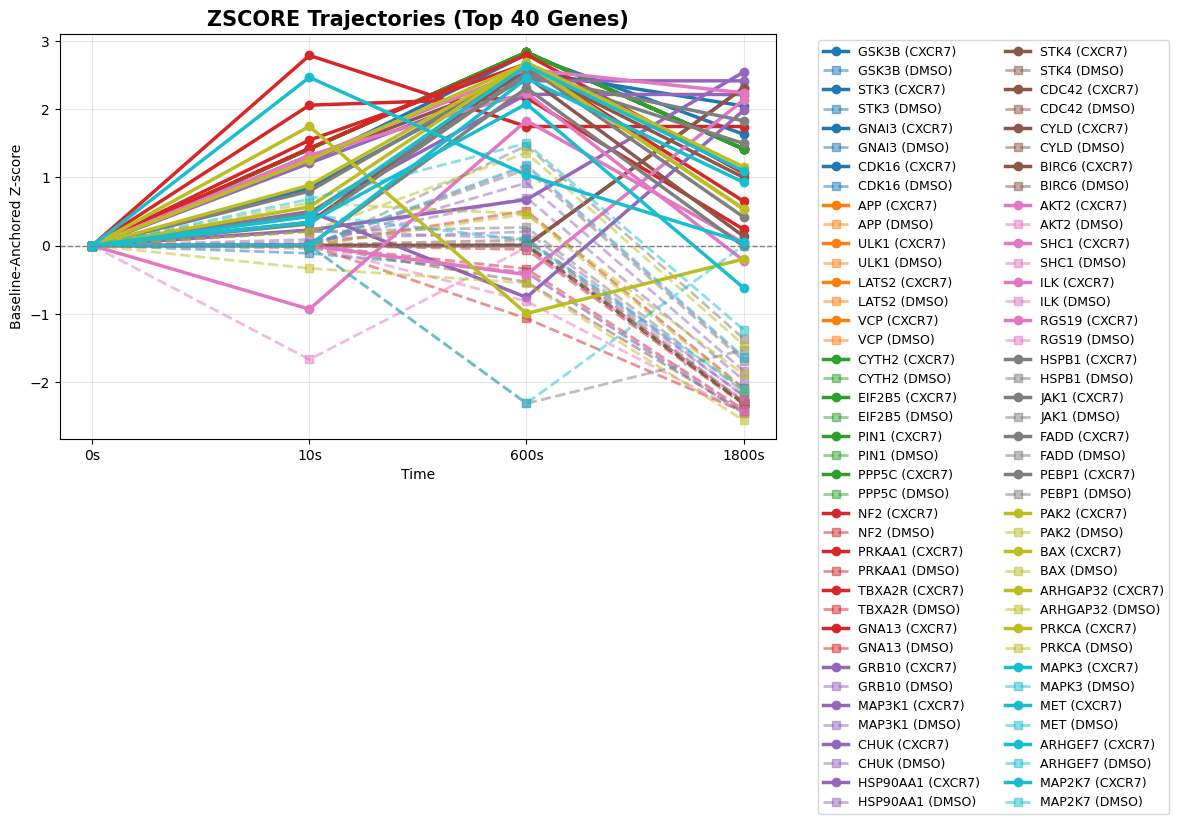

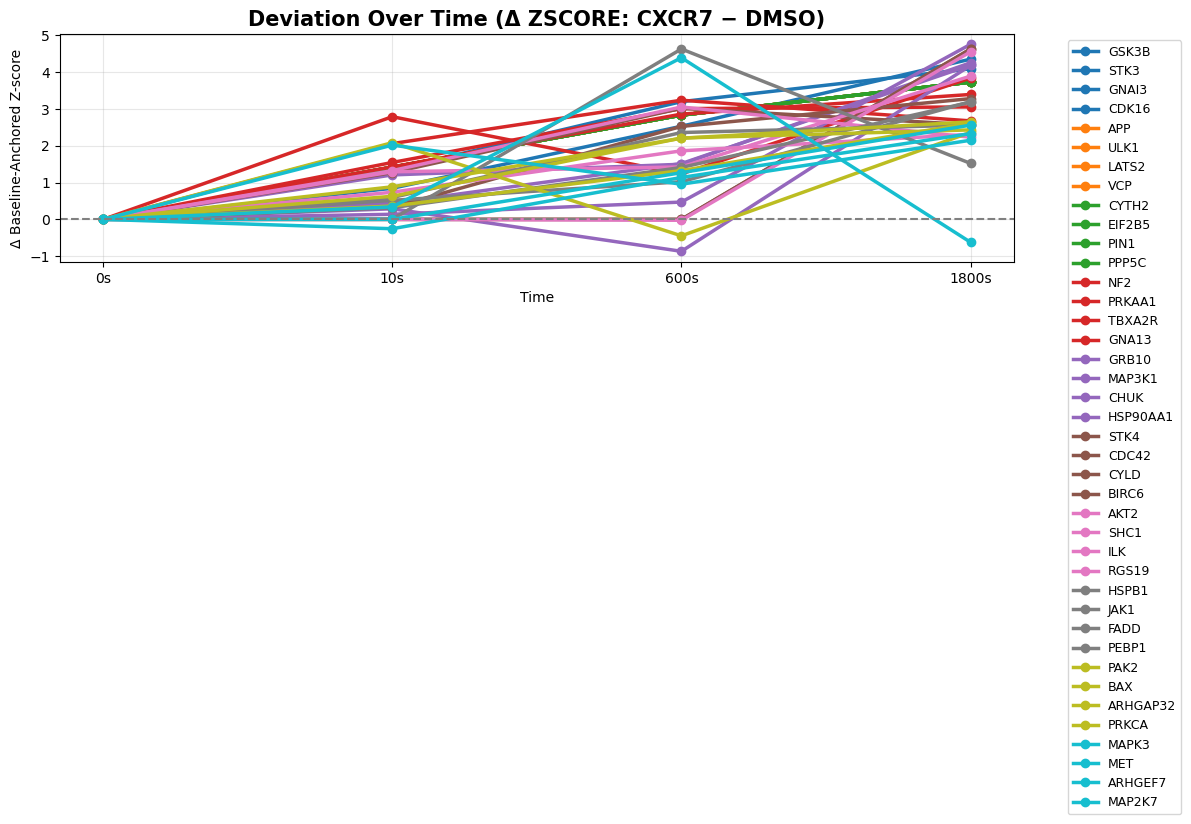


✅ Results saved to analysis/networks/subnetworks/betweenness_zscore_dynamics
   Mode: zscore
   📄 Files saved: metrics, top genes, plots, and trends


In [259]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# ⚙️ Select normalization mode: "absolute", "log2fc", "zscore"
# ======================================================
MODE = "zscore"  # options: "absolute", "log2fc", "zscore"

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness", fill_value=0)

def log2_fold_change_baseline0(pivot):
    baseline = pivot.iloc[:, 0].replace(0, np.nan)
    lfc = np.log2(pivot.div(baseline, axis=0))
    lfc = lfc.fillna(0)
    lfc.columns = timepoints
    return lfc

def zscore_baseline0(pivot):
    norm = pivot.copy()
    for gene in pivot.index:
        vals = pivot.loc[gene].values
        if np.std(vals) > 0:
            z = (vals - np.mean(vals)) / np.std(vals)
        else:
            z = np.zeros_like(vals)
        z = z - z[0]  # baseline shift
        norm.loc[gene] = z
    norm.columns = timepoints
    return norm

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(series):
    t = np.arange(len(series))
    slope, intercept, r, p, se = linregress(t, series)
    return slope, r**2, p

def compute_monotonic_trend(series):
    t = np.arange(len(series))
    rho, p = spearmanr(t, series)
    return rho, p

def directional_change(series):
    return series.iloc[-1] - series.iloc[0]

# ======================================================
# 🧮 Prepare betweenness matrices
# ======================================================
pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

if MODE == "absolute":
    cxcr7 = pivots["CXCR7"].loc[common_genes]
    dmso = pivots["DMSO"].loc[common_genes]
    cxcr7.columns = dmso.columns = timepoints
    label_y = "Absolute Betweenness Centrality"
elif MODE == "log2fc":
    cxcr7 = log2_fold_change_baseline0(pivots["CXCR7"].loc[common_genes])
    dmso = log2_fold_change_baseline0(pivots["DMSO"].loc[common_genes])
    label_y = "log₂ Fold-Change (vs 0 s)"
elif MODE == "zscore":
    cxcr7 = zscore_baseline0(pivots["CXCR7"].loc[common_genes])
    dmso = zscore_baseline0(pivots["DMSO"].loc[common_genes])
    label_y = "Baseline-Anchored Z-score"
else:
    raise ValueError("MODE must be 'absolute', 'log2fc', or 'zscore'")

print(f"\n🧮 Using mode: {MODE}")
print(f"   CXCR7 shape: {cxcr7.shape}")
print(f"   DMSO shape:  {dmso.shape}")

# ======================================================
# 🧮 Compute Δ (CXCR7 − DMSO) and divergence metrics
# ======================================================
delta = cxcr7 - dmso
divergence = []

for gene in common_genes:
    v_cx, v_dm = np.array(cxcr7.loc[gene], dtype=float), np.array(dmso.loc[gene], dtype=float)
    divergence.append((
        gene,
        cosine_dissimilarity(v_cx, v_dm),
        dtw_distance(v_cx, v_dm),
        euclidean_distance(v_cx, v_dm)
    ))

divergence_df = (
    pd.DataFrame(divergence, columns=["gene_symbol", "cosine_dissimilarity", "dtw_distance", "euclidean_distance"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Trend metrics for top genes
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

trend_metrics = []
for gene in top_genes:
    s = delta.loc[gene]
    slope, r2, p = compute_trend_slope(s)
    rho, rp = compute_monotonic_trend(s)
    net = directional_change(s)
    trend = "increasing" if slope > 0 else ("decreasing" if slope < 0 else "stable")
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rp,
        "net_change": net, "trend": trend
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")
combined = divergence_df.join(trend_df).round(4)

# ======================================================
# 📊 Summary Tables
# ======================================================
print("\n" + "="*80)
print(f"📊 TABLE 1: TOP GENES BY DTW DISTANCE ({MODE.upper()} mode)")
print("="*80)
combined_dtw = combined.sort_values("dtw_distance", ascending=False).head(N_TOP).copy()
combined_dtw.insert(0, "Rank", range(1, len(combined_dtw) + 1))
print(combined_dtw.to_string())
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 2: TOP GENES BY POSITIVE NET CHANGE (Increasing Δ {MODE.upper()})")
print("="*80)
combined_pos = combined[combined["net_change"] > 0].sort_values("net_change", ascending=False).head(N_TOP).copy()
if len(combined_pos) > 0:
    combined_pos.insert(0, "Rank", range(1, len(combined_pos) + 1))
    print(combined_pos.to_string())
else:
    print("No genes with positive net_change found.")
print("="*80)

print("\n" + "="*80)
print(f"📊 TABLE 3: TOP GENES BY NEGATIVE NET CHANGE (Decreasing Δ {MODE.upper()})")
print("="*80)
combined_neg = combined[combined["net_change"] < 0].sort_values("net_change", ascending=True).head(N_TOP).copy()
if len(combined_neg) > 0:
    combined_neg.insert(0, "Rank", range(1, len(combined_neg) + 1))
    print(combined_neg.to_string())
else:
    print("No genes with negative net_change found.")
print("="*80)

# ======================================================
# 🎨 Visualization
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))

# Plot 1: trajectories
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7.loc[g], "-o", lw=2.5, color=c, label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso.loc[g], "--s", lw=2, color=c, alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title(f"{MODE.upper()} Trajectories (Top {N_TOP} Genes)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(label_y)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Δ(CXCR7−DMSO)
fig, ax = plt.subplots(figsize=(12, 6))
for i, g in enumerate(top_genes):
    ax.plot(timepoints, delta.loc[g], "-o", lw=2.5, color=colors[i], label=g)
ax.axhline(0, color="gray", ls="--")
ax.set_title(f"Deviation Over Time (Δ {MODE.upper()}: CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel(f"Δ {label_y}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / f"betweenness_{MODE}_dynamics"
out_dir.mkdir(exist_ok=True)

cxcr7.to_csv(out_dir / f"cxcr7_{MODE}.csv")
dmso.to_csv(out_dir / f"dmso_{MODE}.csv")
delta.to_csv(out_dir / f"delta_{MODE}.csv")
divergence_df.to_csv(out_dir / "trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir / "temporal_trend_metrics.csv")
combined_dtw.to_csv(out_dir / "top_genes_by_dtw.csv")
combined_pos.to_csv(out_dir / "top_genes_positive_netchange.csv")
combined_neg.to_csv(out_dir / "top_genes_negative_netchange.csv")

print(f"\n✅ Results saved to {out_dir}")
print(f"   Mode: {MODE}")
print(f"   📄 Files saved: metrics, top genes, plots, and trends")


### 5.1.4 Relative betweeness centrality changes - fold change

Loaded betweenness metrics: (3249, 8)

🧮 Computing log2 fold-change relative to 0s baseline...
   CXCR7 log2FC shape: (467, 4)
   DMSO log2FC shape:  (467, 4)

🔍 Computing trajectory dissimilarity metrics (log2FC)...


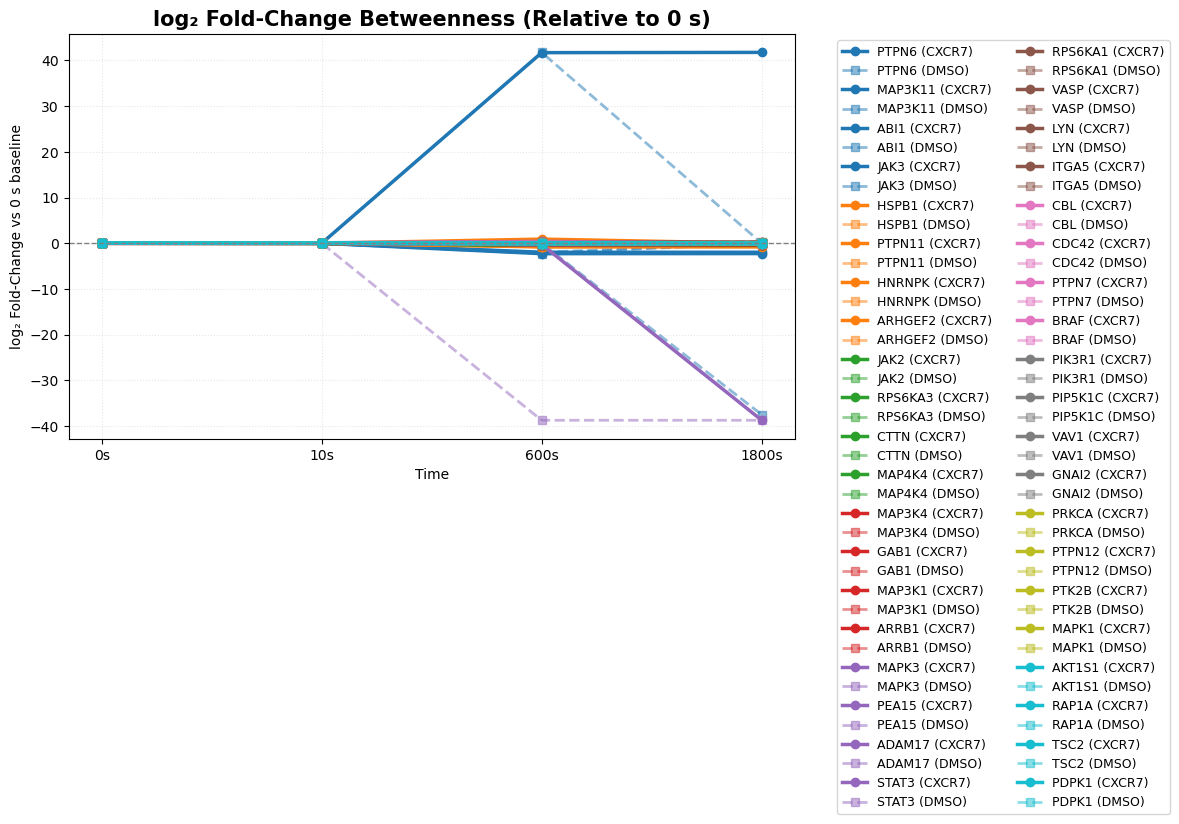

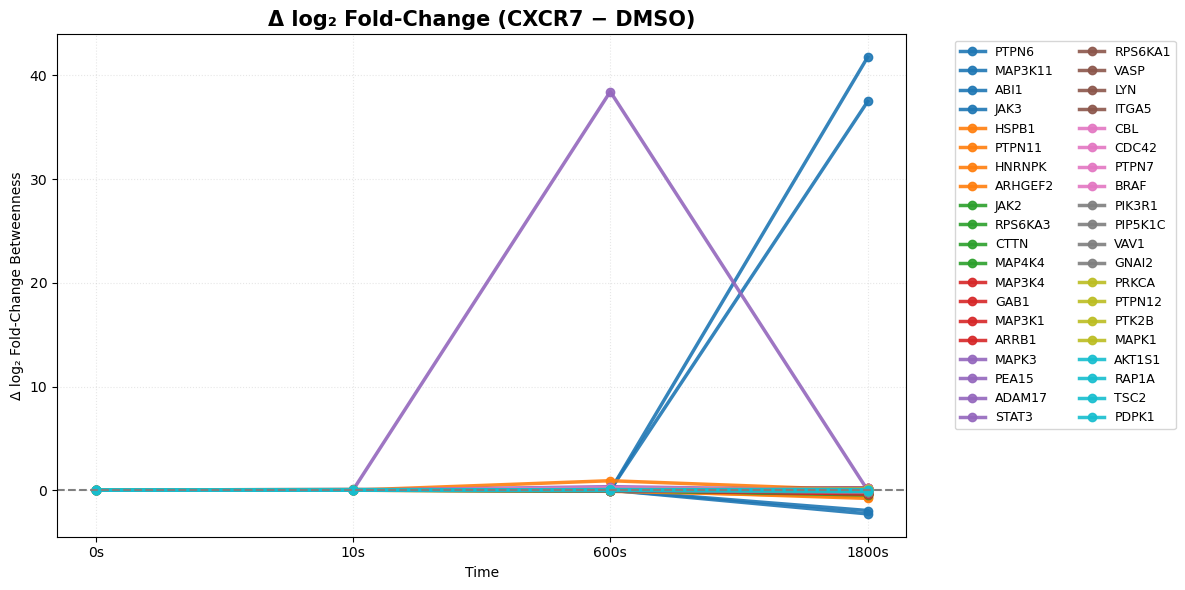


📊 TOP GENES BY DTW DISTANCE (Relative log2FC trajectories)
             Rank  cosine_dissimilarity  dtw_distance  euclidean_distance  AUC_absDelta  mean_absDelta    slope  r_squared  slope_pval  spearman_rho  spearman_pval  net_change       trend
gene_symbol                                                                                                                                                                                
PTPN6           1                0.2934        5.2339             41.7663       20.9304        10.4534  12.5252     0.5991      0.2260        0.3162         0.6838     41.7663  increasing
MAP3K11         2                0.2596        4.6896             37.4916       18.7850         9.3827  11.2473     0.6004      0.2251        0.8000         0.2000     37.4916  increasing
ABI1            3                0.2973        0.2875              2.2828        1.1414         0.5707  -0.6848     0.6000      0.2254       -0.7746         0.2254     -2.2828  decreasing


In [246]:
# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"

metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
print(f"Loaded betweenness metrics: {metrics.shape}")
metrics["network"] = metrics["network"].astype(str)

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ['0s', '10s', '600s', '1800s']

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network",
                          values="betweenness", fill_value=0, observed=False)

def log2_fold_change(pivot, pseudocount=1e-9):
    """Return log2 fold-change relative to baseline (0s), with pseudocount for stability."""
    baseline = pivot.iloc[:, 0]
    lfc = np.log2((pivot + pseudocount).div(baseline + pseudocount, axis=0))
    lfc.columns = timepoints
    return lfc

def cosine_dissimilarity(v1, v2):
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    return float(cosine(v1, v2))

def dtw_distance(v1, v2):
    """Safe DTW distance with NaN/Inf handling."""
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    try:
        return float(dtw(v1.reshape(-1, 1), v2.reshape(-1, 1)).normalizedDistance)
    except Exception:
        return np.nan

def euclidean_distance(v1, v2):
    return float(np.linalg.norm(v1 - v2))

def compute_trend_slope(deviation_series):
    t = np.arange(len(deviation_series))
    slope, intercept, r, p, se = linregress(t, deviation_series)
    return slope, r**2, p

def compute_monotonic_trend(deviation_series):
    t = np.arange(len(deviation_series))
    rho, p = spearmanr(t, deviation_series)
    return rho, p

def directional_change(deviation_series):
    return deviation_series.iloc[-1] - deviation_series.iloc[0]

# ======================================================
# 🧮 Compute RELATIVE (log2FC) betweenness trajectories
# ======================================================
print("\n🧮 Computing log2 fold-change relative to 0s baseline...")

pivots = {name: pivot_betweenness(metrics, traj) for name, traj in trajectories.items()}
common_genes = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cxcr7_lfc = log2_fold_change(pivots["CXCR7"].loc[common_genes])
dmso_lfc  = log2_fold_change(pivots["DMSO"].loc[common_genes])

print(f"   CXCR7 log2FC shape: {cxcr7_lfc.shape}")
print(f"   DMSO log2FC shape:  {dmso_lfc.shape}")

# ======================================================
# 🧮 Compute RELATIVE DEVIATION (CXCR7 − DMSO)
# ======================================================
delta_lfc = cxcr7_lfc - dmso_lfc

print("\n🔍 Computing trajectory dissimilarity metrics (log2FC)...")

divergence = []
for gene in common_genes:
    v_cx = np.array(cxcr7_lfc.loc[gene], dtype=float)
    v_dm = np.array(dmso_lfc.loc[gene], dtype=float)

    cos_diff = cosine_dissimilarity(v_cx, v_dm)
    dtw_diff = dtw_distance(v_cx, v_dm)
    eucl_diff = euclidean_distance(v_cx, v_dm)
    auc = np.trapezoid(np.abs(v_cx - v_dm))
    mean_diff = np.mean(np.abs(v_cx - v_dm))

    divergence.append((gene, cos_diff, dtw_diff, eucl_diff, auc, mean_diff))

divergence_df = (
    pd.DataFrame(divergence,
        columns=["gene_symbol","cosine_dissimilarity","dtw_distance",
                 "euclidean_distance","AUC_absDelta","mean_absDelta"])
    .set_index("gene_symbol")
    .sort_values("dtw_distance", ascending=False)
)

# ======================================================
# 📈 Select top candidates
# ======================================================
N_TOP = 40
top_genes = divergence_df.head(N_TOP).index

# ======================================================
# 📈 Temporal trend metrics
# ======================================================
trend_metrics = []
for gene in top_genes:
    dev_series = delta_lfc.loc[gene]
    slope, r2, p = compute_trend_slope(dev_series)
    rho, rho_p = compute_monotonic_trend(dev_series)
    net = directional_change(dev_series)
    trend_metrics.append({
        "gene_symbol": gene, "slope": slope, "r_squared": r2,
        "slope_pval": p, "spearman_rho": rho, "spearman_pval": rho_p,
        "net_change": net, "trend": "increasing" if slope>0 else
                     ("decreasing" if slope<0 else "stable")
    })
trend_df = pd.DataFrame(trend_metrics).set_index("gene_symbol")

# ======================================================
# 🎨 PLOT 1: log2FC trajectories (CXCR7 vs DMSO)
# ======================================================
colors = plt.cm.tab10(np.linspace(0, 1, N_TOP))
fig, ax = plt.subplots(figsize=(12, 7))
for i, g in enumerate(top_genes):
    c = colors[i]
    ax.plot(timepoints, cxcr7_lfc.loc[g], "-o", lw=2.5, color=c,
            label=f"{g} (CXCR7)")
    ax.plot(timepoints, dmso_lfc.loc[g], "--s", lw=2, color=c,
            alpha=0.5, label=f"{g} (DMSO)")
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title("log₂ Fold-Change Betweenness (Relative to 0 s)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("log₂ Fold-Change vs 0 s baseline")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout(); plt.show()

# ======================================================
# 🎨 PLOT 2: Δlog2FC = CXCR7 − DMSO
# ======================================================
fig, ax = plt.subplots(figsize=(12,6))
for i,g in enumerate(top_genes):
    ax.plot(timepoints, delta_lfc.loc[g], "-o", lw=2.5,
            color=colors[i], alpha=0.9, label=g)
ax.axhline(0, color="gray", ls="--", lw=1.5)
ax.set_title("Δ log₂ Fold-Change (CXCR7 − DMSO)", fontsize=15, fontweight='bold')
ax.set_xlabel("Time"); ax.set_ylabel("Δ log₂ Fold-Change Betweenness")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=9, ncol=2)
ax.grid(alpha=0.3, ls=":")
plt.tight_layout(); plt.show()

# ======================================================
# 📊 Combine metrics
# ======================================================
combined = divergence_df.join(trend_df).round(4)
combined.insert(0,"Rank", range(1,len(combined)+1))
print("\n📊 TOP GENES BY DTW DISTANCE (Relative log2FC trajectories)")
print(combined.head(N_TOP).to_string())

# ======================================================
# 💾 Save
# ======================================================
out_dir = in_dir / "betweenness_relative_log2FC"
out_dir.mkdir(exist_ok=True)
cxcr7_lfc.to_csv(out_dir/"cxcr7_log2fc.csv")
dmso_lfc.to_csv(out_dir/"dmso_log2fc.csv")
delta_lfc.to_csv(out_dir/"delta_log2fc.csv")
divergence_df.to_csv(out_dir/"trajectory_deviation_metrics.csv")
trend_df.to_csv(out_dir/"temporal_trend_metrics.csv")
combined.head(N_TOP).to_csv(out_dir/"top_genes_by_dtw.csv")

print(f"\n✅ Results saved to {out_dir}")


### 5.1.5 Betweeness centrality changes - combined score

In [288]:
# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_CANDIDATES': 30,                # Top N genes to display
    'PRIMARY_METRIC': 'dtw_distance',  # 'dtw_distance' or 'cosine_dissimilarity'
    'SORT_BY': 'trend_rank_score',     # Sort key
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("="*90)
print("⚙️  CONFIGURATION")
print("="*90)
for key, value in CONFIG.items():
    print(f"   {key:25s} = {value}")
print("="*90)

# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"
metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"\n📂 Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]
time_numeric = np.array([0, 10, 600, 1800], dtype=float)

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness",
                          fill_value=0, observed=False)

def normalize_zscore(pivot):
    z = pivot.copy()
    for g in z.index:
        vals = z.loc[g].values
        z.loc[g] = (vals - vals.mean()) / vals.std() if vals.std() > 0 else 0
    return z

def cosine_dissimilarity(v1, v2):
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    try:
        return float(cosine(v1, v2))
    except Exception:
        return np.nan

def dtw_distance(v1, v2):
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    try:
        return float(dtw(v1.reshape(-1,1), v2.reshape(-1,1)).normalizedDistance)
    except Exception:
        return np.nan

def compute_dissim(df1, df2):
    out = []
    skipped = 0
    for g in df1.index:
        v1, v2 = np.array(df1.loc[g]), np.array(df2.loc[g])

        # Skip flat (constant) trajectories
        if np.all(v1 == v1[0]) and np.all(v2 == v2[0]):
            skipped += 1
            continue

        c = cosine_dissimilarity(v1, v2)
        d = dtw_distance(v1, v2)

        # Replace invalids
        if np.isnan(d) or d == 0:
            d = 1e-6
        if np.isnan(c):
            c = 1.0

        out.append((g, c, d))
    df = pd.DataFrame(out, columns=['gene_symbol','cosine','dtw']).set_index('gene_symbol')
    print(f"   ⚠️ Skipped {skipped} flat genes (constant across all timepoints)")
    return df

def compute_trend_metrics(df):
    slopes, aucs, deltas = {}, {}, {}
    for g in df.index:
        y = df.loc[g].values.astype(float)
        slope, _, _, _, _ = linregress(time_numeric, y)
        auc = np.trapz(y, time_numeric)
        delta = y[-1] - y[0]
        slopes[g], aucs[g], deltas[g] = slope, auc, delta
    return pd.DataFrame({'slope': slopes, 'auc': aucs, 'delta': deltas})

def normalize_column(s):
    v = s.dropna()
    if len(v) == 0 or v.max() == v.min():
        return pd.Series(0, index=s.index)
    return (s - v.min()) / (v.max() - v.min())

# ======================================================
# 🧮 Step 1: Compute trajectories
# ======================================================
print("\n" + "="*90)
print("📊 STEP 1: Computing absolute and z-score trajectories")
print("="*90)

pivots = {k: pivot_betweenness(metrics, v) for k,v in trajectories.items()}
common = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)
cx_abs = pivots["CXCR7"].loc[common]; dm_abs = pivots["DMSO"].loc[common]
cx_z = normalize_zscore(cx_abs); dm_z = normalize_zscore(dm_abs)
cx_abs.columns = dm_abs.columns = cx_z.columns = dm_z.columns = timepoints
print(f"   Common genes: {len(common)}")

# ======================================================
# 🧮 Step 2: Compute dissimilarities
# ======================================================
print("\n" + "="*90)
print("📊 STEP 2: Computing dissimilarities")
print("="*90)
abs_d = compute_dissim(cx_abs, dm_abs).add_suffix('_abs')
z_d   = compute_dissim(cx_z, dm_z).add_suffix('_z')
div = abs_d.join(z_d)

# ======================================================
# 🧮 Step 3: Compute trend metrics
# ======================================================
print("\n" + "="*90)
print("📊 STEP 3: Building rank-based combined score (DTW_abs, DTW_z, ΔAUC, ΔSlope)")
print("="*90)

trend_cx = compute_trend_metrics(cx_abs).add_suffix('_CXCR7')
trend_dm = compute_trend_metrics(dm_abs).add_suffix('_DMSO')
trend = trend_cx.join(trend_dm)
trend['delta_slope'] = trend['slope_CXCR7'] - trend['slope_DMSO']
trend['delta_auc']   = trend['auc_CXCR7']   - trend['auc_DMSO']
trend['delta_delta'] = trend['delta_CXCR7'] - trend['delta_DMSO']

div_full = div.join(trend)

# ======================================================
# 🧮 Step 4: Rank-based combination
# ======================================================
div_full['rank_dtw_abs'] = div_full['dtw_abs'].rank(ascending=True, method='average')
div_full['rank_dtw_z']   = div_full['dtw_z'].rank(ascending=True, method='average')
div_full['rank_delta_auc'] = div_full['delta_auc'].abs().rank(ascending=False, method='average')

# Filter valid genes
valid = (div_full[['dtw_abs','dtw_z','delta_auc']].abs().sum(axis=1) > 0)
div_full = div_full.loc[valid]

# Combine rank metrics (mean rank)
div_full['combined_rank_score'] = (
    div_full['rank_dtw_abs'] +
    div_full['rank_dtw_z'] +
    div_full['rank_delta_auc']
) / 3

# Invert and scale 0–1 for easier comparison
div_full['combined_score'] = (
    1 - (div_full['combined_rank_score'] - div_full['combined_rank_score'].min()) /
    (div_full['combined_rank_score'].max() - div_full['combined_rank_score'].min())
)

# Add ΔSlope (normalized absolute) to build final trend_rank_score
div_full['trend_rank_score'] = (
    div_full['combined_score'] +
    normalize_column(div_full['delta_slope'].abs())
) / 2

div_full = div_full.sort_values('trend_rank_score', ascending=False)

# ======================================================
# 📊 Step 5: Display results
# ======================================================
N = CONFIG['N_CANDIDATES']
top = div_full.head(N)
table = pd.DataFrame(index=top.index)
table['Rank'] = range(1, N + 1)
table['DTW_abs'] = top['dtw_abs'].round(4)
table['DTW_z'] = top['dtw_z'].round(4)
table['ΔAUC'] = top['delta_auc'].round(2)
table['ΔSlope'] = top['delta_slope'].round(4)
table['CombinedRankScore'] = top['combined_rank_score'].round(2)
table['TrendRankScore'] = top['trend_rank_score'].round(4)

print("\n" + "="*115)
print("📊 TOP GENES BY RANK-BASED DTW (Abs+Z) + ΔAUC + ΔSlope TREND")
print("="*115)
print(table.to_string())
print("="*115)

# ======================================================
# 💾 Save results
# ======================================================
out_dir = in_dir / "betweenness_trend_analysis"
out_dir.mkdir(exist_ok=True)
div_full.to_csv(out_dir / "rank_based_metrics.csv")
table.to_csv(out_dir / f"top_{N}_genes_rank_based.csv")

print(f"\n✅ Saved rank-based results to {out_dir}")
print(f"   Combined by DTW_abs + DTW_z + ΔAUC ranks (robust composite)")
print(f"   Sorted by trend_rank_score (includes ΔSlope contribution)")


⚙️  CONFIGURATION
   N_CANDIDATES              = 30
   PRIMARY_METRIC            = dtw_distance
   SORT_BY                   = trend_rank_score
   SAVE_PLOTS                = True
   PLOT_DPI                  = 300

📂 Loaded betweenness metrics: (3249, 8)

📊 STEP 1: Computing absolute and z-score trajectories
   Common genes: 467

📊 STEP 2: Computing dissimilarities
   ⚠️ Skipped 316 flat genes (constant across all timepoints)
   ⚠️ Skipped 316 flat genes (constant across all timepoints)

📊 STEP 3: Building rank-based combined score (DTW_abs, DTW_z, ΔAUC, ΔSlope)

📊 TOP GENES BY RANK-BASED DTW (Abs+Z) + ΔAUC + ΔSlope TREND
             Rank   DTW_abs   DTW_z        ΔAUC  ΔSlope  CombinedRankScore  TrendRankScore
gene_symbol                                                                               
PTPN6           1  500.6912  0.6400  2137079.82  2.0853              81.33          0.6791
CASP6           2    1.4569  0.4836  -260678.58  0.0037              35.33          0.5009
AXIN1

/tmp/ipykernel_485052/2341876976.py:115: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time_numeric)
/tmp/ipykernel_485052/2341876976.py:115: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time_numeric)


In [286]:
# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_CANDIDATES': 40,                # Top N genes to display
    'PRIMARY_METRIC': 'dtw_distance',  # 'dtw_distance' or 'cosine_dissimilarity'
    'WEIGHT_ABSOLUTE': 0.25,           # Weight: absolute
    'WEIGHT_ZSCORE': 0.25,             # Weight: z-score normalized
    'WEIGHT_ZSCORE_BASELINE': 0.25,    # Weight: baseline-anchored z-score
    'WEIGHT_LOG2FC': 0.25,             # Weight: log2 fold-change
    'SORT_BY': 'trend_score',          # Final ranking field
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("="*90)
print("⚙️ CONFIGURATION")
print("="*90)
for key, value in CONFIG.items():
    print(f"   {key:25s} = {value}")
print("="*90)

# ======================================================
# 📦 Imports
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.spatial.distance import cosine
from dtw import dtw
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ======================================================
# 💾 Load data
# ======================================================
base = Path(".")
in_dir = base / "analysis" / "networks" / "subnetworks"
metrics = pd.read_csv(in_dir / "subnetwork_metrics.csv")
metrics["network"] = metrics["network"].astype(str)
print(f"\n📂 Loaded betweenness metrics: {metrics.shape}")

# ======================================================
# 🧭 Define trajectories
# ======================================================
trajectories = {
    "DMSO": ["0_Ctrl", "10_DMSO", "600_DMSO", "1800_DMSO"],
    "CXCR7": ["0_Ctrl", "10_CXCR7", "600_CXCR7", "1800_CXCR7"]
}
timepoints = ["0s", "10s", "600s", "1800s"]
time_numeric = np.array([0, 10, 600, 1800], dtype=float)

# ======================================================
# ⚙️ Helper functions
# ======================================================
def pivot_betweenness(df, traj):
    df = df[df["network"].isin(traj)].copy()
    df["network"] = pd.Categorical(df["network"], categories=traj, ordered=True)
    return df.pivot_table(index="gene_symbol", columns="network", values="betweenness",
                          fill_value=0, observed=False)

def normalize_zscore(pivot):
    z = pivot.copy()
    for g in z.index:
        vals = z.loc[g].values
        z.loc[g] = (vals - vals.mean()) / vals.std() if vals.std() > 0 else 0
    return z

def normalize_zscore_baseline(pivot):
    z = pivot.copy()
    for g in z.index:
        vals = z.loc[g].values
        if vals.std() > 0:
            zvals = (vals - vals.mean()) / vals.std()
            z.loc[g] = zvals - zvals[0]   # baseline normalization
        else:
            z.loc[g] = 0
    return z

def log2_fold_change(pivot):
    baseline = pivot.iloc[:, 0].replace(0, np.nan)
    lfc = np.log2(pivot.div(baseline, axis=0))
    # Clean infinities and NaNs
    lfc = lfc.replace([np.inf, -np.inf], np.nan).fillna(0)
    return lfc

def cosine_dissimilarity(v1, v2):
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    if np.all(v1 == 0) or np.all(v2 == 0):
        return np.nan
    try:
        return float(cosine(v1, v2))
    except Exception:
        return np.nan

def dtw_distance(v1, v2):
    v1 = np.nan_to_num(v1, nan=0.0, posinf=0.0, neginf=0.0)
    v2 = np.nan_to_num(v2, nan=0.0, posinf=0.0, neginf=0.0)
    try:
        return float(dtw(v1.reshape(-1,1), v2.reshape(-1,1)).normalizedDistance)
    except Exception:
        return np.nan

def normalize_column(s):
    v = s.dropna()
    if len(v) == 0 or v.max() == v.min(): 
        return pd.Series(0, index=s.index)
    return (s - v.min()) / (v.max() - v.min())

def compute_dissim(df1, df2):
    out = []
    skipped = 0
    for g in df1.index:
        v1, v2 = np.array(df1.loc[g]), np.array(df2.loc[g])
        c = cosine_dissimilarity(v1,v2)
        d = dtw_distance(v1,v2)
        if np.isnan(c) and np.isnan(d):
            skipped += 1
        out.append((g, c, d))
    df = pd.DataFrame(out, columns=['gene_symbol','cosine','dtw']).set_index('gene_symbol')
    print(f"   ⚠️ Skipped {skipped} genes due to invalid vectors")
    return df

def compute_trend_metrics(df):
    slopes, aucs, deltas = {}, {}, {}
    for g in df.index:
        y = df.loc[g].values.astype(float)
        slope, _, _, _, _ = linregress(time_numeric, y)
        auc = np.trapz(y, time_numeric)
        delta = y[-1] - y[0]
        slopes[g], aucs[g], deltas[g] = slope, auc, delta
    return pd.DataFrame({'slope': slopes, 'auc': aucs, 'delta': deltas})

# ======================================================
# 🧮 Step 1: Compute all trajectory modes
# ======================================================
pivots = {k: pivot_betweenness(metrics, v) for k,v in trajectories.items()}
common = pivots["CXCR7"].index.intersection(pivots["DMSO"].index)

cx_abs = pivots["CXCR7"].loc[common]; dm_abs = pivots["DMSO"].loc[common]
cx_z   = normalize_zscore(cx_abs);     dm_z   = normalize_zscore(dm_abs)
cx_zb  = normalize_zscore_baseline(cx_abs); dm_zb  = normalize_zscore_baseline(dm_abs)
cx_lfc = log2_fold_change(cx_abs);     dm_lfc = log2_fold_change(dm_abs)

cx_abs.columns = dm_abs.columns = cx_z.columns = dm_z.columns = cx_zb.columns = dm_zb.columns = cx_lfc.columns = dm_lfc.columns = timepoints

# ======================================================
# 🧮 Step 2: Compute dissimilarities for all normalization modes
# ======================================================
print("\n" + "="*90)
print("📊 STEP 2: Computing dissimilarities across normalization modes")
print("="*90)

abs_d = compute_dissim(cx_abs, dm_abs).add_suffix('_abs')
z_d   = compute_dissim(cx_z, dm_z).add_suffix('_z')
zb_d  = compute_dissim(cx_zb, dm_zb).add_suffix('_zbase')
lfc_d = compute_dissim(cx_lfc, dm_lfc).add_suffix('_log2fc')

div = abs_d.join([z_d, zb_d, lfc_d])

# Normalize all dissimilarity columns (0–1)
for c in div.columns:
    div[c+'_norm'] = normalize_column(div[c])

# ======================================================
# 🧮 Step 3: Build combined score (DTW absolute + z-score only)
# ======================================================
print("\n" + "="*90)
print("📊 STEP 3: Building combined score from DTW_abs and DTW_z")
print("="*90)

# Ensure required columns are present and normalized
div['dtw_abs_norm'] = normalize_column(div['dtw_abs'])
div['dtw_z_norm']   = normalize_column(div['dtw_z'])

div['combined_score'] = (
    CONFIG['WEIGHT_ABSOLUTE'] * div['dtw_abs_norm'] +
    CONFIG['WEIGHT_ZSCORE']   * div['dtw_z_norm']
)

# ======================================================
# 🧮 Step 4: Trend metrics (AUC, slope, delta)
# ======================================================
trend_cx = compute_trend_metrics(cx_abs).add_suffix('_CXCR7')
trend_dm = compute_trend_metrics(dm_abs).add_suffix('_DMSO')
trend = trend_cx.join(trend_dm)
trend['delta_slope'] = trend['slope_CXCR7'] - trend['slope_DMSO']
trend['delta_auc']   = trend['auc_CXCR7']   - trend['auc_DMSO']
trend['delta_delta'] = trend['delta_CXCR7'] - trend['delta_DMSO']

# Merge metrics and trends
div_full = div.join(trend)

# ======================================================
# 🧮 Step 5: Integrated trend score
# ======================================================
div_full['trend_score'] = (
    normalize_column(div_full['combined_score']) +
    normalize_column(div_full['delta_slope'].abs()) +
    normalize_column(div_full['delta_auc'].abs())
) / 3

div_full = div_full.sort_values(CONFIG['SORT_BY'], ascending=False)

# ======================================================
# 📊 Step 6: Display top results
# ======================================================
N = CONFIG['N_CANDIDATES']
top = div_full.head(N)

table = pd.DataFrame(index=top.index)
table['Rank'] = range(1, N + 1)
table['DTW_abs_norm'] = top['dtw_abs_norm'].round(4)
table['DTW_z_norm']   = top['dtw_z_norm'].round(4)
table['Combined']     = top['combined_score'].round(4)
table['TrendScore']   = top['trend_score'].round(4)
table['Slope_CXCR7']  = top['slope_CXCR7'].round(4)
table['Slope_DMSO']   = top['slope_DMSO'].round(4)
table['ΔSlope']       = top['delta_slope'].round(4)
table['ΔAUC']         = top['delta_auc'].round(2)
table['Δ(1800–0)']    = top['delta_delta'].round(2)

print("\n" + "="*115)
print("📊 TOP GENES BY COMBINED DTW (Abs+Z) AND TREND SCORE")
print("="*115)
print(table.to_string())
print("="*115)

# ======================================================
# 💾 Save
# ======================================================
out_dir = in_dir / "betweenness_trend_analysis"
out_dir.mkdir(exist_ok=True)
div_full.to_csv(out_dir / "metrics_dtw_abs_z_combined.csv")
table.to_csv(out_dir / f"top_{N}_genes_dtw_abs_z.csv")
print(f"\n✅ Saved results to {out_dir}")
print(f"   Combined score uses only DTW_abs_norm & DTW_z_norm")
print(f"   Sorted by {CONFIG['SORT_BY']}")


⚙️ CONFIGURATION
   N_CANDIDATES              = 40
   PRIMARY_METRIC            = dtw_distance
   WEIGHT_ABSOLUTE           = 0.25
   WEIGHT_ZSCORE             = 0.25
   WEIGHT_ZSCORE_BASELINE    = 0.25
   WEIGHT_LOG2FC             = 0.25
   SORT_BY                   = trend_score
   SAVE_PLOTS                = True
   PLOT_DPI                  = 300

📂 Loaded betweenness metrics: (3249, 8)

📊 STEP 2: Computing dissimilarities across normalization modes


/home/job37yv/miniforge3/envs/omnipath/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


   ⚠️ Skipped 0 genes due to invalid vectors
   ⚠️ Skipped 0 genes due to invalid vectors
   ⚠️ Skipped 0 genes due to invalid vectors
   ⚠️ Skipped 0 genes due to invalid vectors

📊 STEP 3: Building combined score from DTW_abs and DTW_z

📊 TOP GENES BY COMBINED DTW (Abs+Z) AND TREND SCORE
             Rank  DTW_abs_norm  DTW_z_norm  Combined  TrendScore  Slope_CXCR7  Slope_DMSO  ΔSlope        ΔAUC  Δ(1800–0)
gene_symbol                                                                                                              
PTPN6           1        1.0000      0.4927    0.3732      1.0000       2.0810     -0.0043  2.0853  2137079.82    3740.32
PTPN11          2        0.2845      0.4793    0.1910      0.3627      -0.6077     -0.0095 -0.5982  -618576.70   -1069.73
MAP3K1          3        0.2335      0.8803    0.2785      0.3588       0.1692     -0.1346  0.3038   394139.05     554.47
MAPK3           4        0.2875      0.5421    0.2074      0.3400       0.1312     -0.1385  0.2698 

/tmp/ipykernel_485052/1451489128.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time_numeric)
/tmp/ipykernel_485052/1451489128.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, time_numeric)


## 5.2 phsophosite divergence anaylsis CXCR7 vs DMSO base on log2fc

### 5.2.1 Preparation

In [263]:
# ======================================================
# 💾 Load phosphoproteomics intensities
# ======================================================
import pandas as pd
from pathlib import Path

base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)

print(f"✅ Loaded phosphoproteomics intensity table: {phospho_intensity.shape}")
print("\n📊  column names:\n")
for col in phospho_intensity.columns[:70]:
    print("   ", col)


✅ Loaded phosphoproteomics intensity table: (3772, 70)

📊  column names:

    x0sek_Ctrl_01
    x0sek_Ctrl_02
    x0sek_Ctrl_03
    x0sek_Ctrl_04
    x0sek_Ctrl_05
    x0sek_Ctrl_06
    x0sek_Ctrl_07
    x0sek_Ctrl_08
    x0sek_Ctrl_09
    x0sek_Ctrl_10
    x10sek_CXCR7_01
    x10sek_CXCR7_02
    x10sek_CXCR7_03
    x10sek_CXCR7_04
    x10sek_CXCR7_05
    x10sek_CXCR7_06
    x10sek_CXCR7_07
    x10sek_CXCR7_08
    x10sek_CXCR7_09
    x10sek_CXCR7_10
    x10sek_DMSO_01
    x10sek_DMSO_02
    x10sek_DMSO_03
    x10sek_DMSO_04
    x10sek_DMSO_05
    x10sek_DMSO_06
    x10sek_DMSO_07
    x10sek_DMSO_08
    x10sek_DMSO_09
    x10sek_DMSO_10
    x1800sek_CXCR7_01
    x1800sek_CXCR7_02
    x1800sek_CXCR7_03
    x1800sek_CXCR7_04
    x1800sek_CXCR7_05
    x1800sek_CXCR7_06
    x1800sek_CXCR7_07
    x1800sek_CXCR7_08
    x1800sek_CXCR7_09
    x1800sek_CXCR7_10
    x1800sek_DMSO_01
    x1800sek_DMSO_02
    x1800sek_DMSO_03
    x1800sek_DMSO_04
    x1800sek_DMSO_05
    x1800sek_DMSO_06
    x1800s

In [264]:
# ======================================================
# 🧩 PHOSPHOPROTEOMICS TABLE PREPARATION
# ======================================================
import pandas as pd
from pathlib import Path
import re

# === Load phosphoproteomics intensities ===
base = Path("/storage/users/job37yv/Projects/CXCR7_platelet_analysis/SubProjects/CXCR7_validation")
phospho_path = base / "phosphoproteomics" / "data" / "processed_data"

phospho_intensity = pd.read_csv(phospho_path / "norm_intensity.txt", sep="\t", index_col=0)
print(f"✅ Loaded phosphoproteomics intensity table: {phospho_intensity.shape}")

# ======================================================
# 🧭 Step 1: Harmonize column names
# ======================================================
# Clean names: remove "x", standardize separator to "_"
phospho_intensity.columns = (
    phospho_intensity.columns
    .str.replace("^x", "", regex=True)  # remove prefix 'x'
    .str.replace("sek_", "s_", regex=False)  # optional: 0sek -> 0s
    .str.replace("__", "_", regex=False)
)

print("\n✅ Harmonized column names (first 8):")
print(phospho_intensity.columns[:8].tolist())

# ======================================================
# 🧬 Step 2: Extract UniProt ID and gene symbol
# ======================================================
# Row index example: Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1
pattern = re.compile(r"(?P<uniprot_id>[A-Z0-9\-]+);(?P<gene_symbol>[A-Za-z0-9]+);")

def parse_index(rowname):
    match = pattern.search(rowname)
    if match:
        return match.group("uniprot_id"), match.group("gene_symbol")
    return None, None

parsed = phospho_intensity.index.to_series().apply(parse_index)
phospho_intensity["uniprot_id"] = parsed.apply(lambda x: x[0])
phospho_intensity["gene_symbol"] = parsed.apply(lambda x: x[1])

# ======================================================
# 🧾 Step 3: Reorder columns for clarity
# ======================================================
# Keep annotation columns at front
cols_order = ["uniprot_id", "gene_symbol"] + phospho_intensity.columns[:-2].tolist()
phospho_intensity = phospho_intensity[cols_order]

# ======================================================
# 🔍 Step 4: Preview
# ======================================================
print("\n✅ Table preview:")
display(phospho_intensity.head(5)[["uniprot_id", "gene_symbol"] + list(phospho_intensity.columns[:30])])


✅ Loaded phosphoproteomics intensity table: (3772, 70)

✅ Harmonized column names (first 8):
['0s_Ctrl_01', '0s_Ctrl_02', '0s_Ctrl_03', '0s_Ctrl_04', '0s_Ctrl_05', '0s_Ctrl_06', '0s_Ctrl_07', '0s_Ctrl_08']

✅ Table preview:


uniprot_id gene_symbol  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1              Q9H9P5        UNKL   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4               Q969X0      RILPL2   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5          Q5VY43       PEAR1   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10     O00410        IPO5   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11       P16157        ANK1   

                                                uniprot_id gene_symbol  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1              Q9H9P5        UNKL   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4               Q969X0      RILPL2   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5          Q5VY43       PEAR1   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10     O00410        IPO5   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11       P16157        ANK1   

                                                 0s_Ctrl_01  0s_Ctrl_02  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1            13.597979   13.918964   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4             13.612067   13.489626   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5        38.084983   39.743858   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10   18.057984   17.615148   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11     16.429011   17.146357   

                                                 0s_Ctrl_03  0s_Ctrl_04  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1            13.303412   13.320175   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4             13.312046   13.943136   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5        39.907811   40.186267   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10   19.516947   18.045793   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11     16.727113   17.199776   

                                                 0s_Ctrl_05  0s_Ctrl_06  ...  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1            14.597456   13.396662  ...   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4             13.445734   12.929919  ...   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5        38.515840   38.389777  ...   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10   18.909073   17.275418  ...   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11     17.371291   17.383012  ...   

                                                 10s_CXCR7_09  10s_CXCR7_10  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1              14.560227     14.307135   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4               13.668541     13.505542   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5          36.606789     38.136462   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10     18.644474     18.720554   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11       16.929005     17.016061   

                                                 10s_DMSO_01  10s_DMSO_02  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1             13.860049    14.506737   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4              13.774751    13.534278   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5         39.379149    38.914611   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10    17.473975    19.767297   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11      17.636295    17.466131   

                                                 10s_DMSO_03  10s_DMSO_04  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1             13.407653    13.816841   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4              13.204804    13.504671   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5         38.747520    38.638901   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10    18.972201    17.495739   
P16157;ANK1;S1666;RQDDATGAGQDSENEVSLVSGHQR;11      16.780528    17.365581   

                                                 10s_DMSO_05  10s_DMSO_06  \
Q9H9P5;UNKL;S15;AAAAALSGSPPQTEKPTHYR;1             14.043100    13.842932   
Q969X0;RILPL2;S107;RQSPPASGEVNLGPNK;4              13.752991    13.802541   
Q5VY43;PEAR1;S976;RQPQPQRDSGTYEQPSPLIHDR;5         37.517115    37.819456   
O00410;IPO5;S827;RQDEDYDEQVEESLQDEDDNDVYILTK;10    19.146338    18

In [265]:
print(phospho_intensity.columns[:175].tolist())



['uniprot_id', 'gene_symbol', '0s_Ctrl_01', '0s_Ctrl_02', '0s_Ctrl_03', '0s_Ctrl_04', '0s_Ctrl_05', '0s_Ctrl_06', '0s_Ctrl_07', '0s_Ctrl_08', '0s_Ctrl_09', '0s_Ctrl_10', '10s_CXCR7_01', '10s_CXCR7_02', '10s_CXCR7_03', '10s_CXCR7_04', '10s_CXCR7_05', '10s_CXCR7_06', '10s_CXCR7_07', '10s_CXCR7_08', '10s_CXCR7_09', '10s_CXCR7_10', '10s_DMSO_01', '10s_DMSO_02', '10s_DMSO_03', '10s_DMSO_04', '10s_DMSO_05', '10s_DMSO_06', '10s_DMSO_07', '10s_DMSO_08', '10s_DMSO_09', '10s_DMSO_10', '1800s_CXCR7_01', '1800s_CXCR7_02', '1800s_CXCR7_03', '1800s_CXCR7_04', '1800s_CXCR7_05', '1800s_CXCR7_06', '1800s_CXCR7_07', '1800s_CXCR7_08', '1800s_CXCR7_09', '1800s_CXCR7_10', '1800s_DMSO_01', '1800s_DMSO_02', '1800s_DMSO_03', '1800s_DMSO_04', '1800s_DMSO_05', '1800s_DMSO_06', '1800s_DMSO_07', '1800s_DMSO_08', '1800s_DMSO_09', '1800s_DMSO_10', '600s_CXCR7_01', '600s_CXCR7_02', '600s_CXCR7_03', '600s_CXCR7_04', '600s_CXCR7_05', '600s_CXCR7_06', '600s_CXCR7_07', '600s_CXCR7_08', '600s_CXCR7_09', '600s_CXCR7_10', 

In [276]:
# Count number of phosphosites per UniProt
site_counts = phospho_intensity['uniprot_id'].value_counts()
print(site_counts.head(10))

# Check if any proteins have multiple sites
multi_site_proteins = site_counts[site_counts > 1]
print(f"Proteins with >1 phosphosite: {len(multi_site_proteins)}")


uniprot_id
O95810    33
Q9UDY2    26
O60229    25
Q9UBW5    24
P78559    24
O43182    23
Q9C0C9    22
Q9Y2L6    22
P21333    22
Q9Y6F6    19
Name: count, dtype: int64
Proteins with >1 phosphosite: 729


In [270]:
# ======================================================
# 🧮 PHOSPHOSITE TRAJECTORY PREPARATION (CXCR7 vs DMSO)
# ======================================================
import pandas as pd
import numpy as np
import re
from scipy.stats import sem

# ======================================================
# 🧭 Step 1: Extract metadata (timepoint, condition, replicate)
# ======================================================
pattern = re.compile(r'(?P<time>\d+s)_(?P<condition>[A-Za-z0-9]+)_(?P<rep>\d+)')

meta = []
for col in phospho_intensity.columns[2:]:
    match = pattern.match(col)
    if match:
        meta.append(match.groupdict())
    else:
        meta.append({'time': None, 'condition': None, 'rep': None})

meta_df = pd.DataFrame(meta, index=phospho_intensity.columns[2:])
print("✅ Extracted metadata for conditions/timepoints:")
display(meta_df.head())

# ======================================================
# 🧩 Step 2: Identify timepoints and conditions
# ======================================================
timepoints = sorted(meta_df['time'].dropna().unique(), key=lambda x: int(x.replace('s','')))
conditions = sorted(meta_df['condition'].dropna().unique())

print(f"🕒 Timepoints: {timepoints}")
print(f"🧪 Conditions: {conditions}")

# ======================================================
# 🧮 Step 3: Compute mean ± 95% CI (with shared baseline)
# ======================================================
def compute_summary(df, condition, time):
    """
    Compute mean ±95% CI for a given condition and timepoint.
    Uses 0s_Ctrl_* as the baseline for all conditions.
    """
    if time == "0s":
        # Shared baseline: untreated controls
        cols = [c for c in df.columns if c.startswith("0s_Ctrl_")]
    else:
        cols = [c for c in df.columns if f"{time}_{condition}_" in c]

    if not cols:
        # Fallback in case some condition/timepoint missing
        return pd.DataFrame({
            f'{time}_{condition}_mean': np.nan,
            f'{time}_{condition}_lower': np.nan,
            f'{time}_{condition}_upper': np.nan
        }, index=df.index)

    vals = df[cols].astype(float)
    mean = vals.mean(axis=1)
    ci95 = 1.96 * sem(vals, axis=1, nan_policy='omit')
    lower = mean - ci95
    upper = mean + ci95
    return pd.DataFrame({
        f'{time}_{condition}_mean': mean,
        f'{time}_{condition}_lower': lower,
        f'{time}_{condition}_upper': upper
    })

# Build per-condition/timepoint summaries
summary_tables = []
for cond in conditions:
    for tp in timepoints:
        summary_tables.append(compute_summary(phospho_intensity, cond, tp))

# Merge all summaries horizontally
phospho_summary = pd.concat(summary_tables, axis=1)
phospho_summary[['uniprot_id', 'gene_symbol']] = phospho_intensity[['uniprot_id', 'gene_symbol']]

# ======================================================
# 🧾 Step 4: Build trajectory tables (condition-specific)
# ======================================================
def extract_condition_summary(df, condition, stat='mean'):
    """Pivot trajectory for one condition using summary stats."""
    cols = [c for c in df.columns if c.endswith(f"_{condition}_{stat}")]
    sub = df[cols].copy()
    sub.columns = [re.match(r'(\d+s)', c).group(1) for c in cols]
    sub = sub[sorted(sub.columns, key=lambda x: int(x.replace('s','')))]
    return sub

cxcr7_mean = extract_condition_summary(phospho_summary, 'CXCR7', 'mean')
dmso_mean  = extract_condition_summary(phospho_summary, 'DMSO', 'mean')

cxcr7_lower = extract_condition_summary(phospho_summary, 'CXCR7', 'lower')
cxcr7_upper = extract_condition_summary(phospho_summary, 'CXCR7', 'upper')
dmso_lower  = extract_condition_summary(phospho_summary, 'DMSO', 'lower')
dmso_upper  = extract_condition_summary(phospho_summary, 'DMSO', 'upper')

# ======================================================
# 🔍 Step 5: Verify baseline consistency
# ======================================================
print("\n🔍 Checking that baseline (0s) is shared across CXCR7 and DMSO:")
equal_baseline = np.allclose(cxcr7_mean['0s'], dmso_mean['0s'], equal_nan=True)
print(f"Baseline identical across conditions? {equal_baseline}")

if not equal_baseline:
    diff = (cxcr7_mean['0s'] - dmso_mean['0s']).abs().mean()
    print(f"⚠️ Average baseline difference: {diff:.4f}")

# ======================================================
# 🔬 Step 6: Example trajectory preview
# ======================================================
example_idx = 0
example_gene = phospho_intensity.iloc[example_idx]['gene_symbol']

print(f"\nExample phosphosite trajectory for {example_gene}:")
example_df = pd.DataFrame({
    'CXCR7_mean': cxcr7_mean.iloc[example_idx],
    'CXCR7_lower': cxcr7_lower.iloc[example_idx],
    'CXCR7_upper': cxcr7_upper.iloc[example_idx],
    'DMSO_mean': dmso_mean.iloc[example_idx],
    'DMSO_lower': dmso_lower.iloc[example_idx],
    'DMSO_upper': dmso_upper.iloc[example_idx],
})
display(example_df)


✅ Extracted metadata for conditions/timepoints:


time condition rep
0s_Ctrl_01   0s      Ctrl  01
0s_Ctrl_02   0s      Ctrl  02
0s_Ctrl_03   0s      Ctrl  03
0s_Ctrl_04   0s      Ctrl  04
0s_Ctrl_05   0s      Ctrl  05

🕒 Timepoints: ['0s', '10s', '600s', '1800s']
🧪 Conditions: ['CXCR7', 'Ctrl', 'DMSO']

🔍 Checking that baseline (0s) is shared across CXCR7 and DMSO:
Baseline identical across conditions? True

Example phosphosite trajectory for UNKL:


CXCR7_mean  CXCR7_lower  CXCR7_upper  DMSO_mean  DMSO_lower  DMSO_upper
0s      13.672758    13.438880    13.906636  13.672758   13.438880   13.906636
10s     14.089384    13.843131    14.335637  13.826191   13.601314   14.051069
600s    13.883830    13.562613    14.205048  14.074508   13.895511   14.253505
1800s   14.165251    13.882434    14.448067  13.942101   13.732289   14.151913

### 5.1.2 Top psite divergence

✅ Analysis configuration:
   N_TOP                = 50
   PRIMARY_METRIC       = delta_auc
   WEIGHT_ABS           = 0.5
   WEIGHT_SLOPE         = 0.25
   WEIGHT_AUC           = 0.25
   SAVE_PLOTS           = True
   PLOT_DPI             = 300

✅ Computed metrics for 3772 phosphosites
📊 Sorted by: delta_auc


uniprot_id gene_symbol  \
phosphosite_id                                                              
Q99719;SEPTIN5;S327;MESPIPILPLPTPDAETEK;801            Q99719     SEPTIN5   
O60890;OPHN1;S652;KSPSRPILDGK;5906                     O60890       OPHN1   
Q9Y2J2;EPB41L3;T492;KGEEVTPISAIR;4001                  Q9Y2J2     EPB41L3   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296                 P29353        SHC1   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...     P12931         SRC   
Q9Y2L6;FRMD4B;T652;EMLSTHSSPYKTLER;3394                Q9Y2L6      FRMD4B   
Q9HBL0;TNS1;S1192;TVGTNTPPSPGFGWR;1382                 Q9HBL0        TNS1   
Q8TD55;PLEKHO2;T232;APTPVSASSEVSPESQEDSETPAEEDS...     Q8TD55     PLEKHO2   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...     Q14432       PDE3A   
Q8TBZ3;WDR20;S434;SNSLPHSAVSNAGSK;2281                 Q8TBZ3       WDR20   
Q08495;DMTN;S14;QPLTSPGSVSPSRDSSVPGSPSSIVAK;5444       Q08495        DMTN   
Q9C0B5;ZDHHC5;S684;SLGSASPGPGQPPLSSPTR;440             Q9C0B5      ZDHHC5   
Q9Y490;TLN1;T354;EVIQEWNLTNIK;3601                     Q9Y490        TLN1   
Q9UDY2;TJP2;S920|T925;LISDFEDTDGEGGAYTDNELDEPAE...     Q9UDY2        TJP2   
P07359;GP1BA;T289|Y292|Y294;GCPTLGDEGDTDLYDYYPE...     P07359       GP1BA   
Q15223;NECTIN1;S422;AGIPQHHPPMAQNLQYPDDSDDEKK;4300     Q15223     NECTIN1   
Q9H0X4;FAM234A;S21;KSQENLGNPSKNEDNVK;4187              Q9H0X4     FAM234A   
O43182;ARHGAP6;S663|S667|S673;ASSGDISPYDNNSPVLS...     O43182     ARHGAP6   
Q13459;MYO9B;S2141;RYSDPPTYCLPPASGQTNG;4908            Q13459       MYO9B   
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                      Q6WCQ1       MPRIP   

                                                      cosine       dtw  \
phosphosite_id                                                           
Q99719;SEPTIN5;S327;MESPIPILPLPTPDAETEK;801         0.000250  0.650311   
O60890;OPHN1;S652;KSPSRPILDGK;5906                  0.000131  0.634324   
Q9Y2J2;EPB41L3;T492;KGEEVTPISAIR;4001               0.000254  0.322873   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296              0.000204  0.408989   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...  0.000073  0.493827   
Q9Y2L6;FRMD4B;T652;EMLSTHSSPYKTLER;3394             0.000158  0.252673   
Q9HBL0;TNS1;S1192;TVGTNTPPSPGFGWR;1382              0.020192  0.334676   
Q8TD55;PLEKHO2;T232;APTPVSASSEVSPESQEDSETPAEEDS...  0.000382  0.265265   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...  0.000699  0.494681   
Q8TBZ3;WDR20;S434;SNSLPHSAVSNAGSK;2281              0.000068  0.501802   
Q08495;DMTN;S14;QPLTSPGSVSPSRDSSVPGSPSSIVAK;5444    0.000427  0.287334   
Q9C0B5;ZDHHC5;S684;SLGSASPGPGQPPLSSPTR;440          0.000688  0.264456   
Q9Y490;TLN1;T354;EVIQEWNLTNIK;3601                  0.000978  0.215437   
Q9UDY2;TJP2;S920|T925;LISDFEDTDGEGGAYTDNELDEPAE...  0.000118  0.197831   
P07359;GP1BA;T289|Y292|Y294;GCPTLGDEGDTDLYDYYPE...  0.001059  0.232848   
Q15223;NECTIN1;S422;AGIPQHHPPMAQNLQYPDDSDDEKK;4300  0.000023  0.350597   
Q9H0X4;FAM234A;S21;KSQENLGNPSKNEDNVK;4187           0.000055  0.366039   
O43182;ARHGAP6;S663|S667|S673;ASSGDISPYDNNSPVLS...  0.000165  0.119779   
Q13459;MYO9B;S2141;RYSDPPTYCLPPASGQTNG;4908         0.000062  0.334071   
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                   0.000286  0.555358   

                                                    euclidean  delta_slope  \
phosphosite_id                                                               
Q99719;SEPTIN5;S327;MESPIPILPLPTPDAETEK;801          3.033644     0.340827   
O60890;OPHN1;S652;KSPSRPILDGK;5906                   2.623327     0.673443   
Q9Y2J2;EPB41L3;T492;KGEEVTPISAIR;4001                1.966355    -0.161981   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296               1.948615     0.406014   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...   1.996177     0.413172   
Q9Y2L6;FRMD4B;T652;EMLSTHSSPYKTLER;3394              1.729304    -0.212629   
Q9HBL0;TNS1;S1192;TVGTNTPPSPGFGWR;1382               1.789617    -0.268026   
Q8TD55;PLEKHO2;T232;APTPV

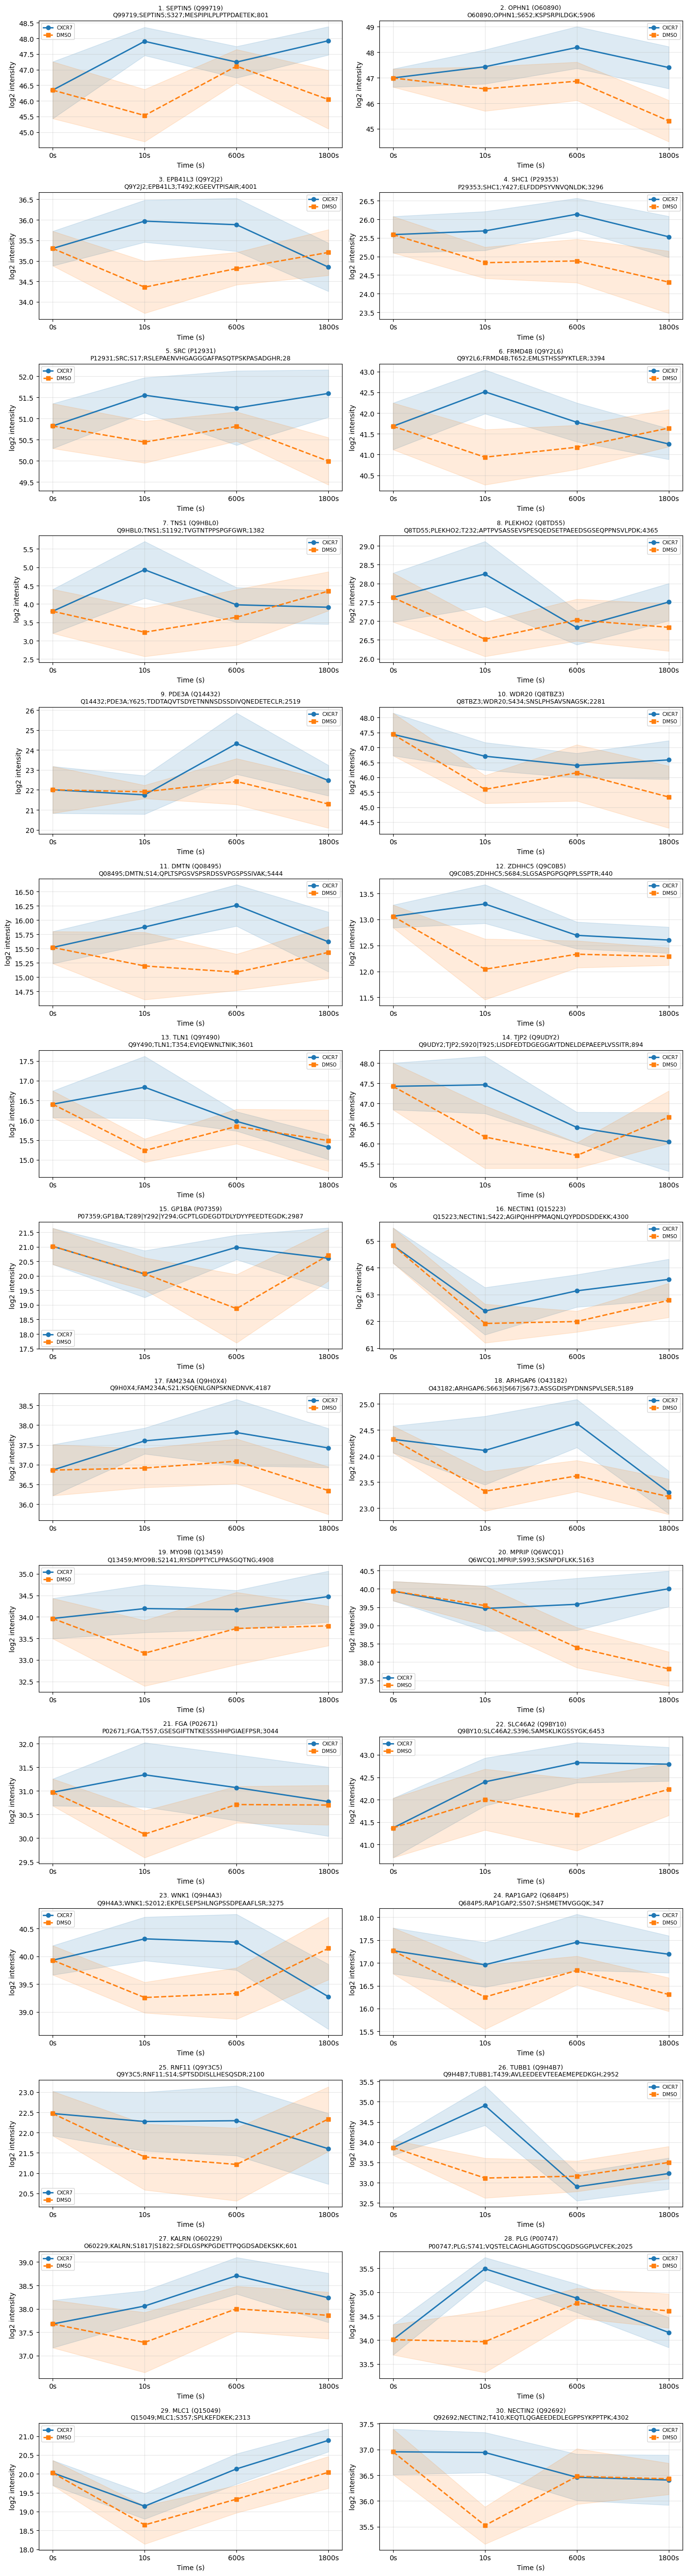


✅ Analysis complete! Sorted by 'delta_auc'. Results saved to: phosphoproteomics/analysis/trajectory_deviation


In [274]:
# ======================================================
# 📊 PHOSPHOSITE TRAJECTORY DEVIATION ANALYSIS (site-level)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from scipy.stats import linregress

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_TOP': 50,                    # Number of top phosphosites to report/plot
    'PRIMARY_METRIC': 'delta_auc',  # Sort by: 'combined_score', 'dtw', 'cosine', 'euclidean', 'delta_auc', 'delta_slope'
    'WEIGHT_ABS': 0.5,
    'WEIGHT_SLOPE': 0.25,
    'WEIGHT_AUC': 0.25,
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("✅ Analysis configuration:")
for k, v in CONFIG.items():
    print(f"   {k:20s} = {v}")

# ======================================================
# 🧩 Step 1: Ensure proper index and site info
# ======================================================
if phospho_intensity.index.name is None:
    phospho_intensity.index.name = "phosphosite_id"

phospho_summary = phospho_summary.copy()
phospho_summary["phosphosite_id"] = phospho_intensity.index
phospho_summary = phospho_summary.set_index("phosphosite_id")

# Align all derived tables
for df in [cxcr7_mean, dmso_mean, cxcr7_lower, cxcr7_upper, dmso_lower, dmso_upper]:
    df.index = phospho_summary.index

# ======================================================
# 🧮 Step 2: Compute all metrics per phosphosite
# ======================================================
results = []
for site_id, row in phospho_summary.iterrows():
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    v_cxcr7 = cxcr7_mean.loc[site_id].values.astype(float)
    v_dmso  = dmso_mean.loc[site_id].values.astype(float)
    
    cos_diff = cosine(v_cxcr7, v_dmso) if not np.all(v_cxcr7 == v_dmso) else 0
    alignment = dtw(v_cxcr7.reshape(-1, 1), v_dmso.reshape(-1, 1))
    dtw_diff = float(alignment.normalizedDistance)
    eucl_diff = np.linalg.norm(v_cxcr7 - v_dmso)
    
    # Trend metrics
    x = np.arange(len(v_cxcr7))
    s1, _, _, _, _ = linregress(x, v_cxcr7)
    s2, _, _, _, _ = linregress(x, v_dmso)
    delta_slope = s1 - s2
    delta_auc = simpson(v_cxcr7, x=x) - simpson(v_dmso, x=x)
    
    results.append([site_id, uid, gene, cos_diff, dtw_diff, eucl_diff, delta_slope, delta_auc])

metrics_df = pd.DataFrame(
    results,
    columns=['phosphosite_id', 'uniprot_id', 'gene_symbol',
             'cosine', 'dtw', 'euclidean', 'delta_slope', 'delta_auc']
).set_index('phosphosite_id')

# ======================================================
# ⚙️ Step 3: Normalize and combine
# ======================================================
for col in ['cosine', 'dtw', 'euclidean', 'delta_slope', 'delta_auc']:
    col_min, col_max = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f'{col}_norm'] = (metrics_df[col] - col_min) / (col_max - col_min)

metrics_df['combined_score'] = (
    CONFIG['WEIGHT_ABS']   * metrics_df['dtw_norm'] +
    CONFIG['WEIGHT_SLOPE'] * metrics_df['delta_slope_norm'].abs() +
    CONFIG['WEIGHT_AUC']   * metrics_df['delta_auc_norm'].abs()
)

# ======================================================
# 🔢 Step 4: Sort dynamically by selected metric
# ======================================================
metric_to_sort = CONFIG['PRIMARY_METRIC']
if metric_to_sort not in metrics_df.columns:
    raise ValueError(f"❌ PRIMARY_METRIC '{metric_to_sort}' not found in metrics_df columns!")

metrics_df = metrics_df.sort_values(metric_to_sort, ascending=False)
top_df = metrics_df.head(CONFIG['N_TOP'])

print(f"\n✅ Computed metrics for {len(metrics_df)} phosphosites")
print(f"📊 Sorted by: {metric_to_sort}")
display(top_df.head(20))

# ======================================================
# 🎨 Step 5: Visualization (with site-level labels)
# ======================================================
timepoints = ['0s', '10s', '600s', '1800s']
n_plots = min(30, len(top_df))
fig, axes = plt.subplots(nrows=n_plots // 2, ncols=2, figsize=(14, 3.5 * (n_plots // 2)))
axes = axes.flatten()

for i, (site_id, row) in enumerate(top_df.iloc[:n_plots].iterrows()):
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    
    cx_mean = cxcr7_mean.loc[site_id]
    cx_lo   = cxcr7_lower.loc[site_id]
    cx_hi   = cxcr7_upper.loc[site_id]
    dm_mean = dmso_mean.loc[site_id]
    dm_lo   = dmso_lower.loc[site_id]
    dm_hi   = dmso_upper.loc[site_id]
    
    ax = axes[i]
    ax.fill_between(timepoints, cx_lo, cx_hi, color='tab:blue', alpha=0.15)
    ax.plot(timepoints, cx_mean, '-o', color='tab:blue', label='CXCR7', lw=2)
    ax.fill_between(timepoints, dm_lo, dm_hi, color='tab:orange', alpha=0.15)
    ax.plot(timepoints, dm_mean, '--s', color='tab:orange', label='DMSO', lw=2)
    
    ax.set_title(f"{i+1}. {gene} ({uid})\n{site_id}", fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("log2 intensity")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ======================================================
# 💾 Step 6: Save results
# ======================================================
out_dir = base / "phosphoproteomics" / "analysis" / "trajectory_deviation"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(out_dir / "phosphosite_deviation_metrics_all.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_phosphosites_sorted_by_{metric_to_sort}.csv")

if CONFIG['SAVE_PLOTS']:
    fig.savefig(out_dir / f"top_{n_plots}_phosphosite_trajectories_sorted_by_{metric_to_sort}.png",
                dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')

print(f"\n✅ Analysis complete! Sorted by '{metric_to_sort}'. Results saved to: {out_dir}")


✅ Analysis configuration:
   N_TOP                     = 50
   PRIMARY_METRIC            = delta_slope
   WEIGHT_ABS                = 0.5
   WEIGHT_SLOPE              = 0.25
   WEIGHT_AUC                = 0.25
   SAVE_PLOTS                = True
   PLOT_DPI                  = 300

✅ Computed metrics for 3772 phosphosites
📊 Sorted by: delta_slope


uniprot_id gene_symbol  \
phosphosite_id                                                              
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                      Q6WCQ1       MPRIP   
O60890;OPHN1;S652;KSPSRPILDGK;5906                     O60890       OPHN1   
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928     P22059        OSBP   
P50552;VASP;S239;KVSKQEEASGGPTAPK;4109                 P50552        VASP   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...     Q14432       PDE3A   
Q8N3D4;EHBP1L1;S310;KGSDALRPPVPQGEDEVPK;3945           Q8N3D4     EHBP1L1   
Q8NEN9;PDZD8;S967;LSEPGTDLVEPSPK;965                   Q8NEN9       PDZD8   
O43182;ARHGAP6;S363|S366;GAMSVDSITDLDDNQSR;2887        O43182     ARHGAP6   
Q86X29;LSR;S464;GPALTPIRDEEWGGHSPR;3147                Q86X29         LSR   
P02671;FGA;S524;HRHPDEAAFFDTASTGK;4727                 P02671         FGA   
Q8N699;MYCT1;S135|S138|S141;RSNLSLASLTFQR;24           Q8N699       MYCT1   
O76074;PDE5A;S86;GHTESCSCPLQQSPR;2823                  O76074       PDE5A   
Q9Y4H4;GPSM3;S35;SAPPSPPPPGTR;4917                     Q9Y4H4       GPSM3   
Q96M96;FGD4;S141;DETATAPASPTTDSCDGNASDSSYR;3584        Q96M96        FGD4   
P02671;FGA;T484;EVVTSEDGSDCPEAMDLGTLSGIGTLDGFR;...     P02671         FGA   
P60709;ACTB;S235;LCYVALDFEQEMATAASSSSLEK;4149          P60709        ACTB   
Q96SB3;PPP1R9B;S205;LDADAVSPTVSQLSAVFEK;3997           Q96SB3     PPP1R9B   
Q66K74;MAP1S;S592;CGEASPPSAACGSPASQLVATPSLELGPI...     Q66K74       MAP1S   
Q96Q42;ALS2;S492;LSLPGLLSQVSPR;849                     Q96Q42        ALS2   
Q8TEQ0;SNX29;S344;LDVKSIDDEDVDENEDDVYGNSSGR;4263       Q8TEQ0       SNX29   

                                                      cosine       dtw  \
phosphosite_id                                                           
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                   0.000286  0.555358   
O60890;OPHN1;S652;KSPSRPILDGK;5906                  0.000131  0.634324   
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928  0.000120  0.518422   
P50552;VASP;S239;KVSKQEEASGGPTAPK;4109              0.000178  0.380507   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...  0.000699  0.494681   
Q8N3D4;EHBP1L1;S310;KGSDALRPPVPQGEDEVPK;3945        0.002232  0.432099   
Q8NEN9;PDZD8;S967;LSEPGTDLVEPSPK;965                0.014561  0.380750   
O43182;ARHGAP6;S363|S366;GAMSVDSITDLDDNQSR;2887     0.000477  0.375599   
Q86X29;LSR;S464;GPALTPIRDEEWGGHSPR;3147             0.000345  0.411676   
P02671;FGA;S524;HRHPDEAAFFDTASTGK;4727              0.000131  0.357661   
Q8N699;MYCT1;S135|S138|S141;RSNLSLASLTFQR;24        0.000078  0.421037   
O76074;PDE5A;S86;GHTESCSCPLQQSPR;2823               0.000243  0.342340   
Q9Y4H4;GPSM3;S35;SAPPSPPPPGTR;4917                  0.000368  0.356246   
Q96M96;FGD4;S141;DETATAPASPTTDSCDGNASDSSYR;3584     0.000363  0.438445   
P02671;FGA;T484;EVVTSEDGSDCPEAMDLGTLSGIGTLDGFR;...  0.000034  0.320061   
P60709;ACTB;S235;LCYVALDFEQEMATAASSSSLEK;4149       0.000101  0.387293   
Q96SB3;PPP1R9B;S205;LDADAVSPTVSQLSAVFEK;3997        0.000384  0.339841   
Q66K74;MAP1S;S592;CGEASPPSAACGSPASQLVATPSLELGPI...  0.000269  0.453976   
Q96Q42;ALS2;S492;LSLPGLLSQVSPR;849                  0.000844  0.212366   
Q8TEQ0;SNX29;S344;LDVKSIDDEDVDENEDDVYGNSSGR;4263    0.000320  0.253781   

                                                    euclidean  delta_slope  \
phosphosite_id                                                               
Q6WCQ1;MPRIP;S993;SKSNPDFLKK;5163                    2.486613     0.782063   
O60890;OPHN1;S652;KSPSRPILDGK;5906                   2.623327     0.673443   
P22059;OSBP;S351;GDMSDEDDENEFFDAPEIITMPENLGHK;2928   2.401800     0.610132   
P50552;VASP;S239;KVSKQEEASGGPTAPK;4109               2.234159     0.609701   
Q14432;PDE3A;Y625;TDDTAQVTSDYETNNNSDSSDIVQNEDET...   2.243751     0.559688   
Q8N3D4;EHBP1L1;S310;KGSDALRPPVPQGEDEVPK;3945         2.015036     0.549371   
Q8NEN9;PDZD8;S967;LSEPGTDLVEPSPK;965                 1.943202     0.547539   
O43182;ARHGAP6;S363|S366;

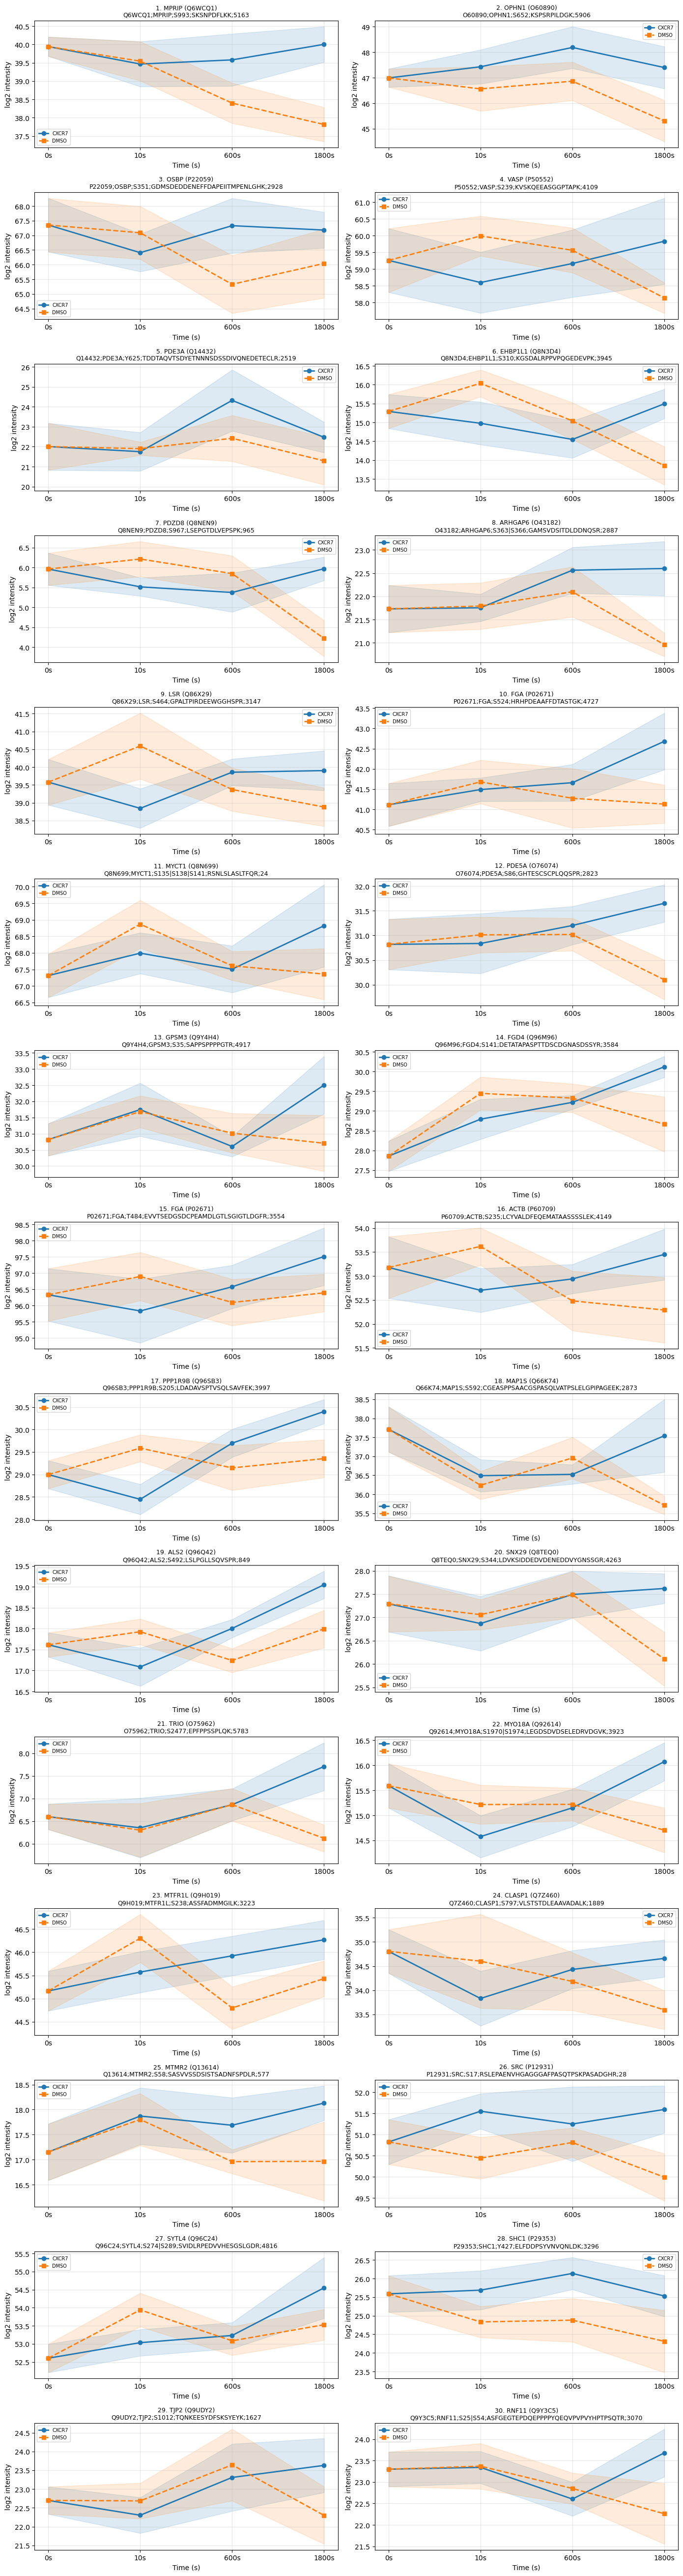


✅ Analysis complete! Sorted by 'delta_slope'. Results saved to: phosphoproteomics/analysis/trajectory_deviation


In [280]:
# ======================================================
# 📊 PHOSPHOSITE TRAJECTORY DEVIATION ANALYSIS (site-level)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from scipy.stats import linregress

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_TOP': 50,                           # Number of top phosphosites to report/plot
    'PRIMARY_METRIC': 'delta_slope',  # Options: combined_score, dtw, cosine, euclidean, delta_auc, abs_delta_auc, delta_slope, abs_delta_slope, delta_slope_rel, abs_delta_slope_rel
    'WEIGHT_ABS': 0.5,
    'WEIGHT_SLOPE': 0.25,
    'WEIGHT_AUC': 0.25,
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("✅ Analysis configuration:")
for k, v in CONFIG.items():
    print(f"   {k:25s} = {v}")

# ======================================================
# 🧩 Step 1: Ensure proper index and site info
# ======================================================
if phospho_intensity.index.name is None:
    phospho_intensity.index.name = "phosphosite_id"

phospho_summary = phospho_summary.copy()
phospho_summary["phosphosite_id"] = phospho_intensity.index
phospho_summary = phospho_summary.set_index("phosphosite_id")

# Align all derived tables
for df in [cxcr7_mean, dmso_mean, cxcr7_lower, cxcr7_upper, dmso_lower, dmso_upper]:
    df.index = phospho_summary.index

# ======================================================
# 🧮 Step 2: Compute all metrics per phosphosite
# ======================================================
results = []
for site_id, row in phospho_summary.iterrows():
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    v_cxcr7 = cxcr7_mean.loc[site_id].values.astype(float)
    v_dmso  = dmso_mean.loc[site_id].values.astype(float)

    # === Distance metrics ===
    cos_diff = cosine(v_cxcr7, v_dmso) if not np.all(v_cxcr7 == v_dmso) else 0
    alignment = dtw(v_cxcr7.reshape(-1, 1), v_dmso.reshape(-1, 1))
    dtw_diff = float(alignment.normalizedDistance)
    eucl_diff = np.linalg.norm(v_cxcr7 - v_dmso)

    # === Trend metrics ===
    x = np.arange(len(v_cxcr7))
    s1, _, _, _, _ = linregress(x, v_cxcr7)
    s2, _, _, _, _ = linregress(x, v_dmso)
    delta_slope = s1 - s2
    abs_delta_slope = abs(delta_slope)

    delta_auc = simpson(v_cxcr7, x=x) - simpson(v_dmso, x=x)
    abs_delta_auc = abs(delta_auc)

    # === Baseline normalization ===
    baseline_cxcr7 = v_cxcr7[0] if v_cxcr7[0] != 0 else np.nan
    baseline_dmso  = v_dmso[0] if v_dmso[0] != 0 else np.nan

    norm_slope_cxcr7 = s1 / baseline_cxcr7 if not np.isnan(baseline_cxcr7) else np.nan
    norm_slope_dmso  = s2 / baseline_dmso if not np.isnan(baseline_dmso) else np.nan

    delta_slope_rel = norm_slope_cxcr7 - norm_slope_dmso
    abs_delta_slope_rel = abs(delta_slope_rel)

    results.append([
        site_id, uid, gene,
        cos_diff, dtw_diff, eucl_diff,
        delta_slope, abs_delta_slope,
        delta_slope_rel, abs_delta_slope_rel,
        delta_auc, abs_delta_auc
    ])

metrics_df = pd.DataFrame(
    results,
    columns=[
        'phosphosite_id', 'uniprot_id', 'gene_symbol',
        'cosine', 'dtw', 'euclidean',
        'delta_slope', 'abs_delta_slope',
        'delta_slope_rel', 'abs_delta_slope_rel',
        'delta_auc', 'abs_delta_auc'
    ]
).set_index('phosphosite_id')

# ======================================================
# ⚙️ Step 3: Normalize and combine
# ======================================================
for col in ['cosine', 'dtw', 'euclidean',
            'delta_slope', 'abs_delta_slope',
            'delta_slope_rel', 'abs_delta_slope_rel',
            'delta_auc', 'abs_delta_auc']:
    col_min, col_max = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f'{col}_norm'] = 0 if col_max == col_min else (metrics_df[col] - col_min) / (col_max - col_min)

metrics_df['combined_score'] = (
    CONFIG['WEIGHT_ABS']   * metrics_df['dtw_norm'] +
    CONFIG['WEIGHT_SLOPE'] * metrics_df['abs_delta_slope_rel_norm'] +
    CONFIG['WEIGHT_AUC']   * metrics_df['abs_delta_auc_norm']
)

# ======================================================
# 🔢 Step 4: Sort dynamically by selected metric
# ======================================================
metric_to_sort = CONFIG['PRIMARY_METRIC']
if metric_to_sort not in metrics_df.columns:
    raise ValueError(f"❌ PRIMARY_METRIC '{metric_to_sort}' not found in metrics_df columns!")

metrics_df = metrics_df.sort_values(metric_to_sort, ascending=False)
top_df = metrics_df.head(CONFIG['N_TOP'])

print(f"\n✅ Computed metrics for {len(metrics_df)} phosphosites")
print(f"📊 Sorted by: {metric_to_sort}")
display(top_df.head(20))

# ======================================================
# 🎨 Step 5: Visualization (with site-level labels)
# ======================================================
timepoints = ['0s', '10s', '600s', '1800s']
n_plots = min(30, len(top_df))
fig, axes = plt.subplots(nrows=n_plots // 2, ncols=2, figsize=(14, 3.5 * (n_plots // 2)))
axes = axes.flatten()

for i, (site_id, row) in enumerate(top_df.iloc[:n_plots].iterrows()):
    gene = row['gene_symbol']
    uid  = row['uniprot_id']

    cx_mean = cxcr7_mean.loc[site_id]
    cx_lo   = cxcr7_lower.loc[site_id]
    cx_hi   = cxcr7_upper.loc[site_id]
    dm_mean = dmso_mean.loc[site_id]
    dm_lo   = dmso_lower.loc[site_id]
    dm_hi   = dmso_upper.loc[site_id]

    ax = axes[i]
    ax.fill_between(timepoints, cx_lo, cx_hi, color='tab:blue', alpha=0.15)
    ax.plot(timepoints, cx_mean, '-o', color='tab:blue', label='CXCR7', lw=2)
    ax.fill_between(timepoints, dm_lo, dm_hi, color='tab:orange', alpha=0.15)
    ax.plot(timepoints, dm_mean, '--s', color='tab:orange', label='DMSO', lw=2)

    ax.set_title(f"{i+1}. {gene} ({uid})\n{site_id}", fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("log2 intensity")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ======================================================
# 💾 Step 6: Save results
# ======================================================
out_dir = base / "phosphoproteomics" / "analysis" / "trajectory_deviation"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(out_dir / "phosphosite_deviation_metrics_all.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_phosphosites_sorted_by_{metric_to_sort}.csv")

if CONFIG['SAVE_PLOTS']:
    fig.savefig(out_dir / f"top_{n_plots}_phosphosite_trajectories_sorted_by_{metric_to_sort}.png",
                dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')

print(f"\n✅ Analysis complete! Sorted by '{metric_to_sort}'. Results saved to: {out_dir}")


### 5.1.3 Psites of interest

✅ Analysis configuration:
   N_TOP                     = 50
   PRIMARY_METRIC            = abs_delta_slope
   WEIGHT_ABS                = 0.5
   WEIGHT_SLOPE              = 0.25
   WEIGHT_AUC                = 0.25
   SAVE_PLOTS                = True
   PLOT_DPI                  = 300

🎯 Found 61 phosphosites matching kinase/adaptor patterns.

✅ Computed metrics for 61 phosphosites (filtered)
📊 Sorted by: abs_delta_slope


uniprot_id gene_symbol  \
phosphosite_id                                                              
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673      P17612      PRKACA   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...     P12931         SRC   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296                 P29353        SHC1   
P12931;SRC;S51;GPSAAFAPAAAEPK;3238                     P12931         SRC   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1325            Q05655       PRKCD   
P29353;SHC1;S139;HGSFVNKPTR;4972                       P29353        SHC1   
Q04759;PRKCQ;S676;EFLNEKPRLSFADR;5500                  Q04759       PRKCQ   
Q13322;GRB10;S428;SVSENSLVAMDFSGQTGR;2423              Q13322       GRB10   
Q05655;PRKCD;T141;SEDEAKFPTMNRR;5402                   Q05655       PRKCD   
Q07889;SOS1;S1134|S1137;SASVSSISLTK;4889               Q07889        SOS1   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1326            Q05655       PRKCD   
P31323;PRKAR2B;S114;ASVCAEAYNPDEEEDDAESR;3158          P31323     PRKAR2B   
Q13976;PRKG1;T517;TWTFCGTPEYVAPEIILNK;1504             Q13976       PRKG1   
Q04759;PRKCQ;S695;NFSFMNPGMER;1208                     Q04759       PRKCQ   
P10644;PRKAR1A;S83;EDEISPPPPNPVVK;4745                 P10644     PRKAR1A   
Q04759;PRKCQ;S695;NFSFMNPGMER;1210                     Q04759       PRKCQ   
Q96B36;AKT1S1;S88|S92;AATAARPPAPPPAPQPPSPTPSPPR...     Q96B36      AKT1S1   
Q13976;PRKG1;S273;EDSPSEDPVFLR;3467                    Q13976       PRKG1   
P31323;PRKAR2B;S83|S85;GVNFAEEPMQSDSEDGEEEEAAPA...     P31323     PRKAR2B   
P62993;GRB2;S90;ESESAPGDFSLSVK;3801                    P62993        GRB2   

                                                      cosine       dtw  \
phosphosite_id                                                           
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673   0.000327  0.650567   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...  0.000073  0.493827   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296              0.000204  0.408989   
P12931;SRC;S51;GPSAAFAPAAAEPK;3238                  0.000418  0.360950   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1325         0.000370  0.239000   
P29353;SHC1;S139;HGSFVNKPTR;4972                    0.000119  0.217939   
Q04759;PRKCQ;S676;EFLNEKPRLSFADR;5500               0.000101  0.158819   
Q13322;GRB10;S428;SVSENSLVAMDFSGQTGR;2423           0.000252  0.263607   
Q05655;PRKCD;T141;SEDEAKFPTMNRR;5402                0.000088  0.218731   
Q07889;SOS1;S1134|S1137;SASVSSISLTK;4889            0.000093  0.129356   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1326         0.000159  0.499792   
P31323;PRKAR2B;S114;ASVCAEAYNPDEEEDDAESR;3158       0.009256  0.148463   
Q13976;PRKG1;T517;TWTFCGTPEYVAPEIILNK;1504          0.000136  0.055980   
Q04759;PRKCQ;S695;NFSFMNPGMER;1208                  0.000109  0.145387   
P10644;PRKAR1A;S83;EDEISPPPPNPVVK;4745              0.000411  0.110322   
Q04759;PRKCQ;S695;NFSFMNPGMER;1210                  0.000014  0.146203   
Q96B36;AKT1S1;S88|S92;AATAARPPAPPPAPQPPSPTPSPPR...  0.000015  0.098003   
Q13976;PRKG1;S273;EDSPSEDPVFLR;3467                 0.000216  0.075275   
P31323;PRKAR2B;S83|S85;GVNFAEEPMQSDSEDGEEEEAAPA...  0.000034  0.061601   
P62993;GRB2;S90;ESESAPGDFSLSVK;3801                 0.000057  0.101470   

                                                    euclidean  delta_slope  \
phosphosite_id                                                               
P17612;PRKACA;S339;FKGPGDTSNFDDYEEEEIRVSINEK;3673    2.935535    -0.490960   
P12931;SRC;S17;RSLEPAENVHGAGGGAFPASQTPSKPASADGH...   1.996177     0.413172   
P29353;SHC1;Y427;ELFDDPSYVNVQNLDK;3296               1.948615     0.406014   
P12931;SRC;S51;GPSAAFAPAAAEPK;3238                   1.072877    -0.343476   
Q05655;PRKCD;S664;NLIDSMDQSAFAGFSFVNPK;1325          0.929334     0.294267   
P29353;SHC1;S139;HGSFVNKPTR;4972                     1.194620     0.286617   
Q04759;PRKCQ;S676;EFLNEKPRLSFADR;5500                0.834473    -0.256341   
Q13322;GRB10;S428;SVSENSL

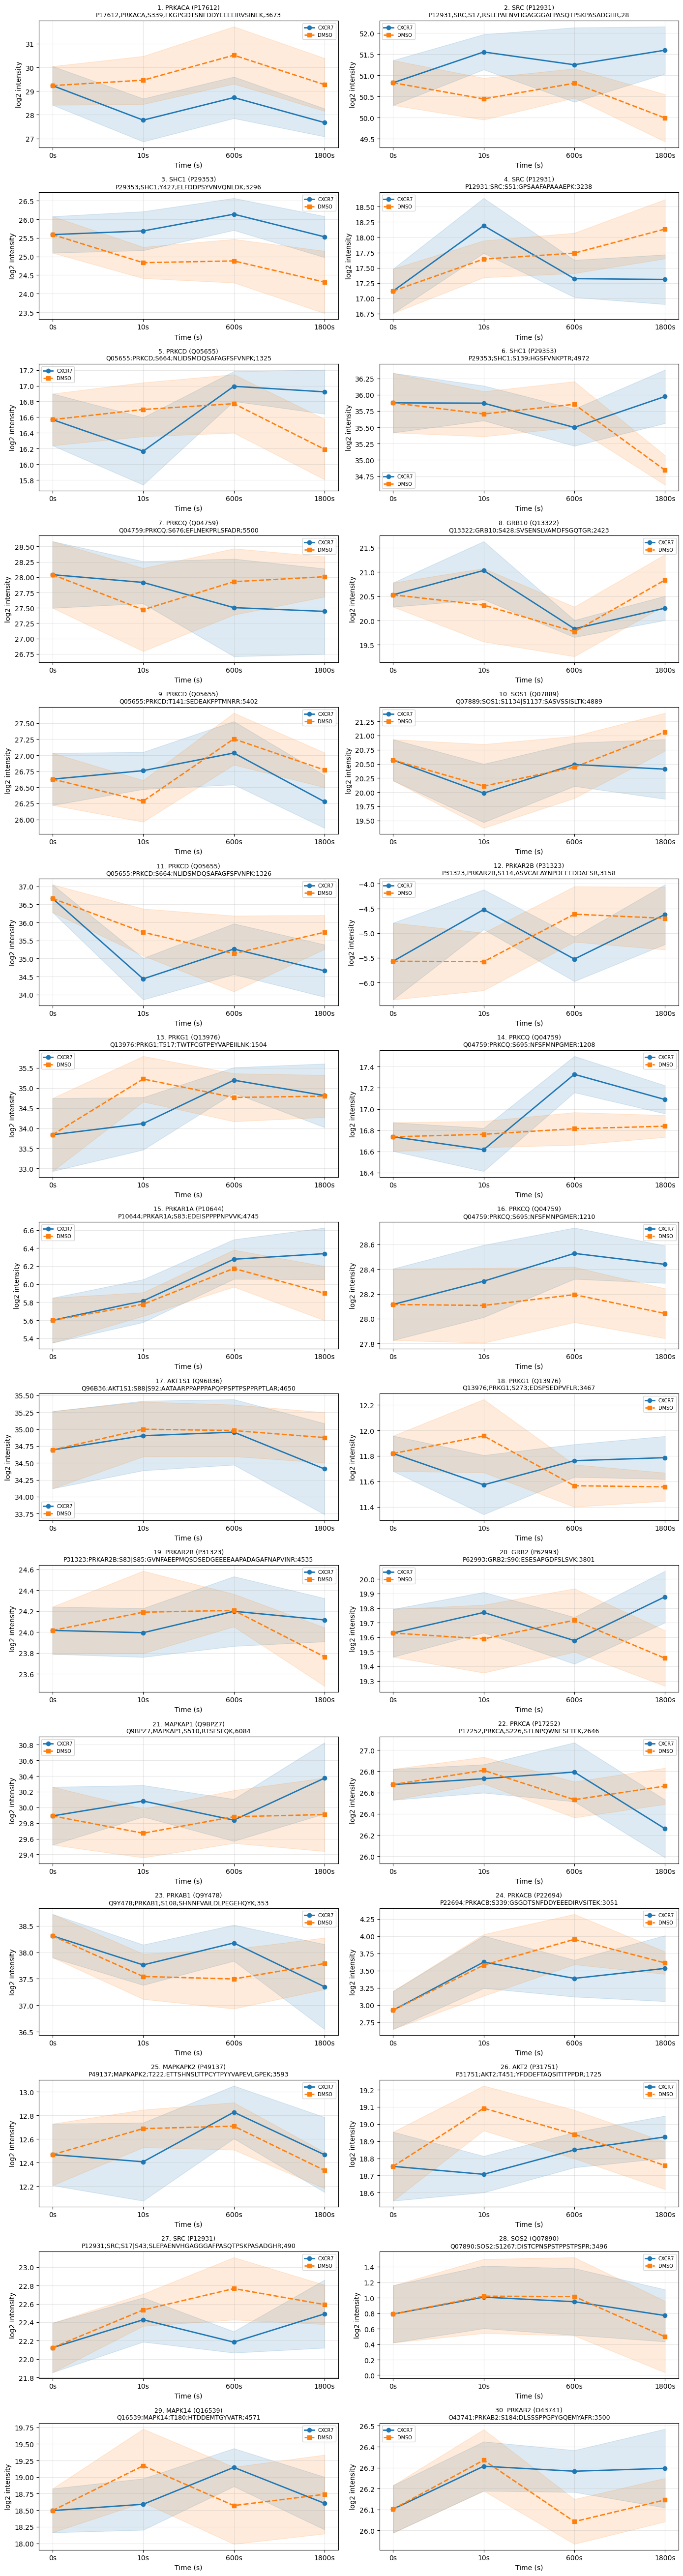


✅ Kinase/adaptor-focused analysis complete! Sorted by 'abs_delta_slope'. Results saved to: phosphoproteomics/analysis/trajectory_deviation


In [283]:
# ======================================================
# 📊 PHOSPHOSITE TRAJECTORY DEVIATION ANALYSIS (Kinases / Adaptors)
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from dtw import dtw
from scipy.integrate import simpson
from scipy.stats import linregress
import re

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
CONFIG = {
    'N_TOP': 50,                           # Number of top phosphosites to report/plot
    'PRIMARY_METRIC': 'abs_delta_slope',  # Sort by: combined_score, dtw, cosine, euclidean, delta_auc, abs_delta_auc, delta_slope, abs_delta_slope, delta_slope_rel, abs_delta_slope_rel
    'WEIGHT_ABS': 0.5,
    'WEIGHT_SLOPE': 0.25,
    'WEIGHT_AUC': 0.25,
    'SAVE_PLOTS': True,
    'PLOT_DPI': 300,
}

print("✅ Analysis configuration:")
for k, v in CONFIG.items():
    print(f"   {k:25s} = {v}")

# ======================================================
# 🧩 Step 1: Ensure proper index and site info
# ======================================================
if phospho_intensity.index.name is None:
    phospho_intensity.index.name = "phosphosite_id"

phospho_summary = phospho_summary.copy()
phospho_summary["phosphosite_id"] = phospho_intensity.index
phospho_summary = phospho_summary.set_index("phosphosite_id")

# Align all derived tables
for df in [cxcr7_mean, dmso_mean, cxcr7_lower, cxcr7_upper, dmso_lower, dmso_upper]:
    df.index = phospho_summary.index

# ======================================================
# 🧮 Step 2: Compute all metrics per phosphosite
# ======================================================
results = []
for site_id, row in phospho_summary.iterrows():
    gene = row['gene_symbol']
    uid  = row['uniprot_id']
    v_cxcr7 = cxcr7_mean.loc[site_id].values.astype(float)
    v_dmso  = dmso_mean.loc[site_id].values.astype(float)

    # === Distance metrics ===
    cos_diff = cosine(v_cxcr7, v_dmso) if not np.all(v_cxcr7 == v_dmso) else 0
    alignment = dtw(v_cxcr7.reshape(-1, 1), v_dmso.reshape(-1, 1))
    dtw_diff = float(alignment.normalizedDistance)
    eucl_diff = np.linalg.norm(v_cxcr7 - v_dmso)

    # === Trend metrics ===
    x = np.arange(len(v_cxcr7))
    s1, _, _, _, _ = linregress(x, v_cxcr7)
    s2, _, _, _, _ = linregress(x, v_dmso)
    delta_slope = s1 - s2
    abs_delta_slope = abs(delta_slope)

    delta_auc = simpson(v_cxcr7, x=x) - simpson(v_dmso, x=x)
    abs_delta_auc = abs(delta_auc)

    # === Baseline normalization ===
    baseline_cxcr7 = v_cxcr7[0] if v_cxcr7[0] != 0 else np.nan
    baseline_dmso  = v_dmso[0] if v_dmso[0] != 0 else np.nan

    norm_slope_cxcr7 = s1 / baseline_cxcr7 if not np.isnan(baseline_cxcr7) else np.nan
    norm_slope_dmso  = s2 / baseline_dmso if not np.isnan(baseline_dmso) else np.nan

    delta_slope_rel = norm_slope_cxcr7 - norm_slope_dmso
    abs_delta_slope_rel = abs(delta_slope_rel)

    results.append([
        site_id, uid, gene,
        cos_diff, dtw_diff, eucl_diff,
        delta_slope, abs_delta_slope,
        delta_slope_rel, abs_delta_slope_rel,
        delta_auc, abs_delta_auc
    ])

metrics_df = pd.DataFrame(
    results,
    columns=[
        'phosphosite_id', 'uniprot_id', 'gene_symbol',
        'cosine', 'dtw', 'euclidean',
        'delta_slope', 'abs_delta_slope',
        'delta_slope_rel', 'abs_delta_slope_rel',
        'delta_auc', 'abs_delta_auc'
    ]
).set_index('phosphosite_id')

# ======================================================
# ⚙️ Step 3: Normalize and combine
# ======================================================
for col in ['cosine', 'dtw', 'euclidean',
            'delta_slope', 'abs_delta_slope',
            'delta_slope_rel', 'abs_delta_slope_rel',
            'delta_auc', 'abs_delta_auc']:
    col_min, col_max = np.nanmin(metrics_df[col]), np.nanmax(metrics_df[col])
    metrics_df[f'{col}_norm'] = 0 if col_max == col_min else (metrics_df[col] - col_min) / (col_max - col_min)

metrics_df['combined_score'] = (
    CONFIG['WEIGHT_ABS']   * metrics_df['dtw_norm'] +
    CONFIG['WEIGHT_SLOPE'] * metrics_df['abs_delta_slope_rel_norm'] +
    CONFIG['WEIGHT_AUC']   * metrics_df['abs_delta_auc_norm']
)

# ======================================================
# 🎯 Step 4: Filter by kinase/adaptor interest patterns
# ======================================================
interest_patterns = [
    r'^PRKA', r'^PRKC', r'^AKT', r'^SRC',
    r'^MAPK', r'^PRKG', r'^ARRB',
    r'^SOS', r'^SHC', r'^GRB'
]
interest_regex = re.compile('|'.join(interest_patterns), flags=re.IGNORECASE)

metrics_interest = metrics_df[metrics_df['gene_symbol'].str.contains(interest_regex, na=False)]
print(f"\n🎯 Found {len(metrics_interest)} phosphosites matching kinase/adaptor patterns.")

if metrics_interest.empty:
    print("⚠️ No matches found. Showing global top instead.")
    metrics_interest = metrics_df.copy()

# ======================================================
# 🔢 Step 5: Sort dynamically by selected metric
# ======================================================
metric_to_sort = CONFIG['PRIMARY_METRIC']
if metric_to_sort not in metrics_interest.columns:
    raise ValueError(f"❌ PRIMARY_METRIC '{metric_to_sort}' not found in metrics_df columns!")

metrics_interest = metrics_interest.sort_values(metric_to_sort, ascending=False)
top_df = metrics_interest.head(CONFIG['N_TOP'])

print(f"\n✅ Computed metrics for {len(metrics_interest)} phosphosites (filtered)")
print(f"📊 Sorted by: {metric_to_sort}")
display(top_df.head(20))

# ======================================================
# 🎨 Step 6: Visualization (with site-level labels)
# ======================================================
timepoints = ['0s', '10s', '600s', '1800s']
n_plots = min(30, len(top_df))
fig, axes = plt.subplots(nrows=n_plots // 2, ncols=2, figsize=(14, 3.5 * (n_plots // 2)))
axes = axes.flatten()

for i, (site_id, row) in enumerate(top_df.iloc[:n_plots].iterrows()):
    gene = row['gene_symbol']
    uid  = row['uniprot_id']

    cx_mean = cxcr7_mean.loc[site_id]
    cx_lo   = cxcr7_lower.loc[site_id]
    cx_hi   = cxcr7_upper.loc[site_id]
    dm_mean = dmso_mean.loc[site_id]
    dm_lo   = dmso_lower.loc[site_id]
    dm_hi   = dmso_upper.loc[site_id]

    ax = axes[i]
    ax.fill_between(timepoints, cx_lo, cx_hi, color='tab:blue', alpha=0.15)
    ax.plot(timepoints, cx_mean, '-o', color='tab:blue', label='CXCR7', lw=2)
    ax.fill_between(timepoints, dm_lo, dm_hi, color='tab:orange', alpha=0.15)
    ax.plot(timepoints, dm_mean, '--s', color='tab:orange', label='DMSO', lw=2)

    ax.set_title(f"{i+1}. {gene} ({uid})\n{site_id}", fontsize=9)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("log2 intensity")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ======================================================
# 💾 Step 7: Save results
# ======================================================
out_dir = base / "phosphoproteomics" / "analysis" / "trajectory_deviation"
out_dir.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(out_dir / "phosphosite_deviation_metrics_all.csv")
metrics_interest.to_csv(out_dir / f"phosphosite_interest_metrics_sorted_by_{metric_to_sort}.csv")
top_df.to_csv(out_dir / f"top_{CONFIG['N_TOP']}_interest_phosphosites_sorted_by_{metric_to_sort}.csv")

if CONFIG['SAVE_PLOTS']:
    fig.savefig(out_dir / f"top_{n_plots}_interest_phosphosite_trajectories_sorted_by_{metric_to_sort}.png",
                dpi=CONFIG['PLOT_DPI'], bbox_inches='tight')

print(f"\n✅ Kinase/adaptor-focused analysis complete! Sorted by '{metric_to_sort}'. Results saved to: {out_dir}")


## 5.3 Decision point: log2FC/psitedeviation and network betweenescentrality

### 5.3.1 Collapse site-level metrics to protein level

In [290]:
# ======================================================
# 1️⃣ Collapse site-level metrics_df → protein-level
# ======================================================
import pandas as pd
import numpy as np

# Sort by combined_score and select top phosphosite per UniProt
metrics_df_prot = (
    metrics_df.sort_values("combined_score", ascending=False)
              .groupby("uniprot_id", as_index=False)
              .first()
)

metrics_df_prot = metrics_df_prot.rename(columns={
    "uniprot_id": "UniProt",
    "combined_score": "dyn_deviation"
})

# Define direction (based on delta_slope or delta_auc)
def classify_direction(x, thr=0.05):
    if x > thr:
        return "upregulated"
    elif x < -thr:
        return "downregulated"
    else:
        return "neutral"

metrics_df_prot["direction"] = metrics_df_prot["delta_slope"].apply(classify_direction)

print(f"✅ Collapsed to {len(metrics_df_prot)} unique proteins")
display(metrics_df_prot.head(10))


✅ Collapsed to 1315 unique proteins


UniProt gene_symbol    cosine       dtw  euclidean  delta_slope  \
0  A0A1B0GUW6          NA  0.000290  0.218825   1.285097    -0.318190   
1      A0FGR8       ESYT2  0.000170  0.248443   0.836646     0.228243   
2      A1A4S6    ARHGAP10  0.000017  0.078184   0.244207     0.077003   
3      A1L390     PLEKHG3  0.000043  0.078588   0.410054     0.105279   
4      A2A2Y4       FRMD3  0.000472  0.179169   0.856551     0.228233   
5      A2RRP1        NBAS  0.000002  0.033302   0.084008    -0.010437   
6      A2RUS2      DENND3  0.000046  0.162292   1.008272    -0.250080   
7      A6NFX1      MFSD2B  0.000033  0.074780   0.295435     0.083011   
8      A6QL63       ABTB3  0.000020  0.117930   0.639656     0.012998   
9      A7E2V4      ZSWIM8  0.000405  0.232378   1.061660    -0.125017   

   abs_delta_slope  delta_slope_rel  abs_delta_slope_rel  delta_auc  ...  \
0         0.318190        -0.016535             0.016535  -1.223503  ...   
1         0.228243         0.015580             0.015580   0.980959  ...   
2         0.077003         0.004077             0.004077   0.089862  ...   
3         0.105279         0.004854             0.004854  -0.032295  ...   
4         0.228233         0.018718             0.018718   0.362753  ...   
5         0.010437        -0.000565             0.000565   0.109399  ...   
6         0.250080        -0.006216             0.006216  -1.051629  ...   
7         0.083011         0.006461             0.006461   0.240410  ...   
8         0.012998         0.000360             0.000360   0.986409  ...   
9         0.125017        -0.010064             0.010064  -1.490417  ...   

   dtw_norm  euclidean_norm  delta_slope_norm  abs_delta_slope_norm  \
0  0.282891        0.263915          0.265374              0.406838   
1  0.321783        0.170948          0.630221              0.291820   
2  0.098215        0.048132          0.529240              0.098427   
3  0.098745        0.082514          0.548120              0.134584   
4  0.230819        0.175075          0.630214              0.291807   
5  0.039279        0.014922          0.470857              0.013308   
6  0.208657        0.206527          0.310850              0.319744   
7  0.093745        0.058752          0.533251              0.106109   
8  0.150406        0.130111          0.486504              0.016582   
9  0.300689        0.217595          0.394354              0.159823   

   delta_slope_rel_norm  abs_delta_slope_rel_norm  delta_auc_norm  \
0              0.022481                  0.000217        0.395647   
1              0.022894                  0.000205        0.656560   
2              0.022746                  0.000054        0.551093   
3              0.022756                  0.000064        0.536635   
4              0.022934                  0.000246        0.583391   
5              0.022686                  0.000007        0.553405   
6              0.022614                  0.000082        0.415990   
7              0.022777                  0.000085        0.568911   
8              0.022698                  0.000005        0.657205   
9              0.022564                  0.000132        0.364056   

   abs_delta_auc_norm  dyn_deviation      direction  
0            0.267925       0.208481  downregulated  
1            0.214808       0.214645    upregulated  
2            0.019660       0.054036    upregulated  
3            0.007053       0.051152    upregulated  
4            0.079423       0.135327    upregulated  
5            0.023939       0.025626        neutral  
6            0.230285       0.161920  downregulated  
7            0.052630       0.060051    upregulated  
8            0.216002       0.129205        neutral  
9            0.326379       0.231972  downregulated  

[10 rows x 22 columns]

### 5.3.2 Attach protein metrics to the graph

In [291]:
# ======================================================
# 2️⃣ Integrate with igraph network (giant component)
# ======================================================
import igraph as ig

node_names = g_gcc.vs["name"]  # UniProt IDs
nodes_df = pd.DataFrame({"UniProt": node_names})

merged = (
    nodes_df.merge(metrics_df_prot[["UniProt", "gene_symbol", "delta_slope", "delta_auc", "dyn_deviation", "direction"]],
                   on="UniProt", how="left")
    .fillna({"gene_symbol": "", "delta_slope": 0, "delta_auc": 0, "dyn_deviation": 0, "direction": "neutral"})
)

print(f"✅ Annotated {len(merged)} network nodes with phospho metrics")
display(merged.head(10))

# Push back to igraph
for col in ["gene_symbol", "delta_slope", "delta_auc", "dyn_deviation", "direction"]:
    g_gcc.vs[col] = merged[col].tolist()


✅ Annotated 581 network nodes with phospho metrics


UniProt gene_symbol  delta_slope  delta_auc  dyn_deviation      direction
0  P0DP24                 0.000000   0.000000       0.000000        neutral
1  Q9Y210       TRPC6     0.079137  -0.009224       0.095635    upregulated
2  P06241         FYN     0.067988  -0.150654       0.047711    upregulated
3  P49137    MAPKAPK2     0.079732  -0.177862       0.066835    upregulated
4  Q16539      MAPK14    -0.009051   0.346202       0.044965        neutral
5  P31749        AKT1     0.045927  -0.903394       0.167479        neutral
6  O15111                 0.000000   0.000000       0.000000        neutral
7  P19838                 0.000000   0.000000       0.000000        neutral
8  P27986                 0.000000   0.000000       0.000000        neutral
9  P78536      ADAM17    -0.096917  -0.131354       0.112439  downregulated

### 5.3.3 Identify top differential nodes (signal origin)

In [292]:
# ======================================================
# 3️⃣ Define "top differential" nodes for reach analysis
# ======================================================
# You can define this based on absolute delta_slope or combined_score
TOP_N = 50
thr = metrics_df_prot["delta_slope"].abs().quantile(0.9)

top_nodes = metrics_df_prot.query("abs(delta_slope) >= @thr")
top_uniprots = set(top_nodes["UniProt"])

print(f"🌟 Identified {len(top_uniprots)} top differential proteins (|Δslope| ≥ {thr:.3f})")
display(top_nodes.head(10))


🌟 Identified 132 top differential proteins (|Δslope| ≥ 0.267)


UniProt gene_symbol    cosine       dtw  euclidean  delta_slope  \
0    A0A1B0GUW6          NA  0.000290  0.218825   1.285097    -0.318190   
17       O00151      PDLIM1  0.000107  0.240580   1.002421     0.273118   
37       O14639      ABLIM1  0.001204  0.420141   1.969342     0.390976   
45       O14980        XPO1  0.000062  0.168973   1.061922     0.328569   
68       O43182     ARHGAP6  0.000477  0.375599   1.701290     0.541059   
85       O43561         LAT  0.001545  0.268038   1.403649     0.328680   
91       O43665       RGS10  0.000519  0.575117   2.681708     0.284379   
99       O60229       KALRN  0.000256  0.390351   1.599641    -0.457590   
115      O60890       OPHN1  0.000131  0.634324   2.623327     0.673443   
120      O75113       N4BP1  0.000133  0.273315   1.138210    -0.348876   

     abs_delta_slope  delta_slope_rel  abs_delta_slope_rel  delta_auc  ...  \
0           0.318190        -0.016535             0.016535  -1.223503  ...   
17          0.273118         0.007955             0.007955  -0.564487  ...   
37          0.390976         0.021635             0.021635   0.937341  ...   
45          0.328569         0.008145             0.008145   0.541029  ...   
68          0.541059         0.024898             0.024898   1.098064  ...   
85          0.328680         0.032238             0.032238   1.078904  ...   
91          0.284379         0.007731             0.007731  -3.505836  ...   
99          0.457590        -0.017230             0.017230  -1.481200  ...   
115         0.673443         0.014330             0.014330   3.279046  ...   
120         0.348876        -0.010210             0.010210   0.210078  ...   

     dtw_norm  euclidean_norm  delta_slope_norm  abs_delta_slope_norm  \
0    0.282891        0.263915          0.265374              0.406838   
17   0.311459        0.205314          0.660183              0.349202   
37   0.547241        0.405762          0.738876              0.499910   
45   0.217430        0.217649          0.697207              0.420109   
68   0.488754        0.350194          0.839085              0.691824   
85   0.347514        0.288491          0.697282              0.420251   
91   0.750742        0.553440          0.667702              0.363602   
99   0.508124        0.329121          0.172299              0.585090   
115  0.828487        0.541337          0.927476              0.861106   
120  0.354443        0.233464          0.244885              0.446076   

     delta_slope_rel_norm  abs_delta_slope_rel_norm  delta_auc_norm  \
0                0.022481                  0.000217        0.395647   
17               0.022796                  0.000105        0.473646   
37               0.022972                  0.000284        0.651397   
45               0.022798                  0.000107        0.604491   
68               0.023014                  0.000327        0.670420   
85               0.023108                  0.000424        0.668152   
91               0.022793                  0.000102        0.125518   
99               0.022472                  0.000226        0.365147   
115              0.022878                  0.000188        0.928553   
120              0.022562                  0.000134        0.565321   

     abs_delta_auc_norm  dyn_deviation      direction  
0              0.267925       0.208481  downregulated  
17             0.123602       0.186656    upregulated  
37             0.205256       0.325006    upregulated  
45             0.118465       0.138358    upregulated  
68             0.240454       0.304572    upregulated  
85             0.236258       0.232927    upregulated  
91             0.767751       0.567334    upregulated  
99             0.324360       0.335209  downregulated  
115            0.718084       0.593812    upregulated  
120            0.045987       0.188752  downregulated  

[10 rows x 22 columns]

### 5.3.4 Compute reach / average distance to differential proteins

In [293]:
# ======================================================
# 4️⃣ Compute reach metrics relative to top differential nodes
# ======================================================
dist_matrix = g_gcc.shortest_paths_dijkstra(weights=None, mode="OUT")

uni_index = {v["name"]: i for i, v in enumerate(g_gcc.vs)}

# Compute mean distance to all top differential nodes
avg_dist_to_top = []
for node in g_gcc.vs:
    i = uni_index[node["name"]]
    dists = [dist_matrix[i][uni_index[t]] for t in top_uniprots if t in uni_index]
    dists = [d for d in dists if d != 0 and np.isfinite(d)]  # exclude self & unreachable
    avg_dist_to_top.append(np.mean(dists) if len(dists) > 0 else np.nan)

g_gcc.vs["avg_dist_to_top"] = avg_dist_to_top
print("✅ Computed average shortest-path distance to top differential nodes")


✅ Computed average shortest-path distance to top differential nodes


/tmp/ipykernel_485052/2244411929.py:4: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = g_gcc.shortest_paths_dijkstra(weights=None, mode="OUT")


In [295]:
# Check which of your top IDs are not in the graph
graph_nodes = set(g_gcc.vs["name"])
missing_in_graph = [u for u in top_uniprots if u not in graph_nodes]

print(f"🧩 Graph contains {len(graph_nodes)} nodes")
print(f"🔎 Top differential proteins: {len(top_uniprots)}")
print(f"⚠️ {len(missing_in_graph)} top proteins not found in graph:")
print(missing_in_graph[:10])  # show a few examples


🧩 Graph contains 581 nodes
🔎 Top differential proteins: 132
⚠️ 91 top proteins not found in graph:
['P01042', 'O00151', 'Q9NSY0', 'O95425', 'P29692', 'Q99719', 'Q147X3', 'Q8ND56', 'Q66K74', 'Q86X29']


In [296]:
import itertools

graph_names = g_gcc.vs["name"]
print("🔍 Example graph vertex names:")
print(graph_names[:10])


🔍 Example graph vertex names:
['P0DP24', 'Q9Y210', 'P06241', 'P49137', 'Q16539', 'P31749', 'O15111', 'P19838', 'P27986', 'P78536']


### 5.3.5 Classify upstream/downstream influence

In [297]:
# ======================================================
# 5️⃣ Classify upstream/downstream influence (robust)
# ======================================================
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- Keep only top differential proteins present in the graph
graph_nodes = set(g_gcc.vs["name"])
top_uniprots_present = [u for u in top_uniprots if u in graph_nodes]
print(f"✅ {len(top_uniprots_present)} / {len(top_uniprots)} top differential proteins are in the network.")

# --- Precompute index map
name_to_idx = {v["name"]: v.index for v in g_gcc.vs}

# --- Relation classifier (uses shortest paths, direction-aware)
def classify_relation(g, top_set, node_name):
    """Return 'upstream', 'downstream', 'bidirectional', or 'unrelated'."""
    if node_name not in name_to_idx:
        return "unrelated"

    node_idx = name_to_idx[node_name]
    reachable_from_top = False
    reaches_top = False

    for top in top_set:
        if top not in name_to_idx:
            continue
        top_idx = name_to_idx[top]

        # downstream: top → node
        dist_down = g.shortest_paths_dijkstra(source=top_idx, target=node_idx, weights=None, mode="OUT")[0][0]
        # upstream: node → top
        dist_up = g.shortest_paths_dijkstra(source=node_idx, target=top_idx, weights=None, mode="OUT")[0][0]

        if np.isfinite(dist_down):
            reachable_from_top = True
        if np.isfinite(dist_up):
            reaches_top = True

        if reachable_from_top and reaches_top:
            break

    if reachable_from_top and not reaches_top:
        return "downstream"
    elif reaches_top and not reachable_from_top:
        return "upstream"
    elif reachable_from_top and reaches_top:
        return "bidirectional"
    else:
        return "unrelated"

# --- Apply classifier with progress bar
relations = []
for v in tqdm(g_gcc.vs, desc="Classifying relations"):
    relations.append(classify_relation(g_gcc, top_uniprots_present, v["name"]))

g_gcc.vs["relation_to_top"] = relations
print("✅ Classified nodes by direction of signal relation")

✅ 41 / 132 top differential proteins are in the network.


Classifying relations:   0%|          | 0/581 [00:00<?, ?it/s]/tmp/ipykernel_485052/1688106122.py:32: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_down = g.shortest_paths_dijkstra(source=top_idx, target=node_idx, weights=None, mode="OUT")[0][0]
/tmp/ipykernel_485052/1688106122.py:34: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_up = g.shortest_paths_dijkstra(source=node_idx, target=top_idx, weights=None, mode="OUT")[0][0]
Classifying relations: 100%|██████████| 581/581 [00:01<00:00, 421.36it/s]

✅ Classified nodes by direction of signal relation


### 5.3.6 Compute distance, betweenness, and reach coverage

In [298]:
# ======================================================
# 6️⃣ Compute distance, betweenness, and reach coverage
# ======================================================
print("⏳ Computing shortest-path distances to top differential proteins...")
dist_matrix = np.array(g_gcc.shortest_paths_dijkstra(
    target=[name_to_idx[t] for t in top_uniprots_present],
    weights=None,
    mode="OUT"
))

avg_dists = []
coverage = []

for i, v in enumerate(g_gcc.vs):
    dists = dist_matrix[i, :]
    # Exclude infinities and self (0-distance)
    finite_dists = dists[np.isfinite(dists) & (dists > 0)]
    avg_dists.append(finite_dists.mean() if len(finite_dists) > 0 else np.nan)
    coverage.append((np.isfinite(dists) & (dists > 0)).sum() / len(top_uniprots_present))

g_gcc.vs["avg_dist_to_top"] = avg_dists
g_gcc.vs["reach_coverage"] = coverage

# Compute betweenness centrality (unweighted)
g_gcc.vs["betweenness"] = g_gcc.betweenness()

print("✅ Added avg_dist_to_top, reach_coverage, and betweenness")

⏳ Computing shortest-path distances to top differential proteins...
✅ Added avg_dist_to_top, reach_coverage, and betweenness


/tmp/ipykernel_485052/1500949115.py:5: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = np.array(g_gcc.shortest_paths_dijkstra(


### 5.3.7 Assemble node-level summary table

In [299]:
reach_df = pd.DataFrame({
    "UniProt": g_gcc.vs["name"],
    "gene_symbol": g_gcc.vs["gene_symbol"] if "gene_symbol" in g_gcc.vs.attributes() else ["" for _ in g_gcc.vs],
    "direction": g_gcc.vs["direction"] if "direction" in g_gcc.vs.attributes() else ["" for _ in g_gcc.vs],
    "relation_to_top": g_gcc.vs["relation_to_top"],
    "avg_dist_to_top": g_gcc.vs["avg_dist_to_top"],
    "reach_coverage": g_gcc.vs["reach_coverage"],
    "betweenness": g_gcc.vs["betweenness"],
    "delta_slope": g_gcc.vs["delta_slope"] if "delta_slope" in g_gcc.vs.attributes() else np.nan,
    "delta_auc": g_gcc.vs["delta_auc"] if "delta_auc" in g_gcc.vs.attributes() else np.nan,
    "dyn_deviation": g_gcc.vs["dyn_deviation"] if "dyn_deviation" in g_gcc.vs.attributes() else np.nan,
})

display(reach_df.head(10))


UniProt gene_symbol      direction relation_to_top  avg_dist_to_top  \
0  P0DP24                    neutral        upstream          3.40625   
1  Q9Y210       TRPC6    upregulated      downstream              NaN   
2  P06241         FYN    upregulated   bidirectional          2.78125   
3  P49137    MAPKAPK2    upregulated   bidirectional          3.37500   
4  Q16539      MAPK14        neutral   bidirectional          2.68750   
5  P31749        AKT1        neutral   bidirectional          2.12500   
6  O15111                    neutral   bidirectional          4.40625   
7  P19838                    neutral   bidirectional          4.28125   
8  P27986                    neutral   bidirectional          2.96875   
9  P78536      ADAM17  downregulated   bidirectional          3.50000   

   reach_coverage   betweenness  delta_slope  delta_auc  dyn_deviation  
0        0.780488      0.000000     0.000000   0.000000       0.000000  
1        0.000000      0.000000     0.079137  -0.009224       0.095635  
2        0.780488   4200.646077     0.067988  -0.150654       0.047711  
3        0.780488   1238.549449     0.079732  -0.177862       0.066835  
4        0.780488  12885.704631    -0.009051   0.346202       0.044965  
5        0.780488  26749.364661     0.045927  -0.903394       0.167479  
6        0.780488    705.675735     0.000000   0.000000       0.000000  
7        0.780488   1169.251541     0.000000   0.000000       0.000000  
8        0.780488   1221.408208     0.000000   0.000000       0.000000  
9        0.780488    571.021685    -0.096917  -0.131354       0.112439

### 5.3.8 Split into upregulated / downregulated subnetworks

In [300]:
up_nodes = reach_df.query("direction == 'upregulated'")["UniProt"].tolist()
down_nodes = reach_df.query("direction == 'downregulated'")["UniProt"].tolist()

g_up = g_gcc.subgraph([name_to_idx[n] for n in up_nodes if n in name_to_idx])
g_down = g_gcc.subgraph([name_to_idx[n] for n in down_nodes if n in name_to_idx])

print(f"📈 Upregulated subgraph: {g_up.vcount()} nodes, {g_up.ecount()} edges")
print(f"📉 Downregulated subgraph: {g_down.vcount()} nodes, {g_down.ecount()} edges")

📈 Upregulated subgraph: 129 nodes, 91 edges
📉 Downregulated subgraph: 127 nodes, 95 edges


### 5.3.9 Export annotated graph and table

In [ ]:
out_dir = base / "analysis" / "networks" / "reach_analysis"
out_dir.mkdir(parents=True, exist_ok=True)

reach_df.to_csv(out_dir / "phosphosite_network_reach_summary.csv", index=False)
g_gcc.write_graphml(str(out_dir / "phosphosite_network_reach_annotated.graphml"))

print(f"💾 Saved annotated network and reach summary → {out_dir}")


###  Optional: inspect subsets

In [301]:
downstream_high_bc = reach_df.query("relation_to_top == 'downstream' and betweenness > 0.05")
display(downstream_high_bc.head())

far_nodes = reach_df.query("avg_dist_to_top > 5")
display(far_nodes.head())

# ======================================================
# ✅ Output overview
# ======================================================
print("""
Metric                Meaning
-------------------------------------------------------------
avg_dist_to_top       Mean shortest-path distance to top differential nodes (excl. self)
reach_coverage        Fraction of top differential nodes reachable from each node
relation_to_top       'upstream', 'downstream', 'bidirectional', or 'unrelated'
betweenness           Network centrality (information flow potential)
direction             From phospho metrics (up/down/neutral)
dyn_deviation         Dynamic trajectory deviation score
delta_slope, delta_auc Additional phospho-based trend metrics
""")

UniProt gene_symbol      direction relation_to_top  avg_dist_to_top  \
10  P05067                    neutral      downstream              NaN   
34  P78344      EIF4G2        neutral      downstream              NaN   
36  P55212                    neutral      downstream              NaN   
44  Q9NR09       BIRC6  downregulated      downstream              NaN   
45  O75385        ULK1    upregulated      downstream              NaN   

    reach_coverage  betweenness  delta_slope  delta_auc  dyn_deviation  
10             0.0   286.000000     0.000000   0.000000       0.000000  
34             0.0    39.069762    -0.039342   0.106134       0.024069  
36             0.0   307.669611     0.000000   0.000000       0.000000  
44             0.0   101.520453    -0.095556   0.383428       0.068309  
45             0.0   294.135714     0.191247   0.130107       0.129918

UniProt gene_symbol      direction relation_to_top  avg_dist_to_top  \
30  P55957                    neutral   bidirectional           6.0000   
49  Q13188        STK3  downregulated   bidirectional           6.6875   
51  Q92934         BAD  downregulated   bidirectional           6.0000   
54  Q07812                    neutral   bidirectional           6.0000   
97  P04632                    neutral        upstream           5.1250   

    reach_coverage  betweenness  delta_slope  delta_auc  dyn_deviation  
30        0.780488   905.931631     0.000000   0.000000       0.000000  
49        0.780488   823.970221    -0.140163   0.275364       0.106655  
51        0.780488  1792.531907    -0.136075   0.106846       0.097038  
54        0.780488   878.606689     0.000000   0.000000       0.000000  
97        0.780488     0.000000     0.000000   0.000000       0.000000


Metric                Meaning
-------------------------------------------------------------
avg_dist_to_top       Mean shortest-path distance to top differential nodes (excl. self)
reach_coverage        Fraction of top differential nodes reachable from each node
relation_to_top       'upstream', 'downstream', 'bidirectional', or 'unrelated'
betweenness           Network centrality (information flow potential)
direction             From phospho metrics (up/down/neutral)
dyn_deviation         Dynamic trajectory deviation score
delta_slope, delta_auc Additional phospho-based trend metrics



### 5.3.1 old collapse, Attach protein metrics to the graph, Identify top differential nodes (signal origin), Compute reach / average distance to differential proteins, Classify upstream/downstream influence,Compute centrality & coverage metrics

In [253]:
# ======================================================
# 📂 Load prepared omics data
# ======================================================

from pathlib import Path
import pandas as pd

# Define base and input directories
base = Path(".")
in_dir = base / "analysis" / "networks" / "prepared_data"

# --- Expression mean tables ---
prot_expr_mean = pd.read_csv(in_dir / "proteome_expr_mean.csv", index_col=0)
phospho_expr_mean = pd.read_csv(in_dir / "phosphoproteome_expr_mean.csv", index_col=0)
combined_expr_mean = pd.read_csv(in_dir / "combined_expr_mean.csv", index_col=0)

# --- Fold-change tables ---
prot_fc = pd.read_csv(in_dir / "proteome_fc.csv", index_col=0)
phospho_fc = pd.read_csv(in_dir / "phosphoproteome_fc.csv", index_col=0)

# --- Detected proteins list ---
detected_uniprots = pd.read_csv(in_dir / "detected_uniprots.txt", header=None)[0].tolist()

# Summary info
print(f"✅ Loaded {len(detected_uniprots)} detected UniProt IDs.")
print(f"🧬 proteome_expr_mean shape: {prot_expr_mean.shape}")
print(f"🧪 phospho_expr_mean shape: {phospho_expr_mean.shape}")
print(f"🔗 combined_expr_mean shape: {combined_expr_mean.shape}")
print(f"📈 proteome_fc shape: {prot_fc.shape}")
print(f"📊 phospho_fc shape: {phospho_fc.shape}")

# Quick preview of the phosphoproteome FC data
display(phospho_fc.head())


✅ Loaded 2916 detected UniProt IDs.
🧬 proteome_expr_mean shape: (2326, 8)
🧪 phospho_expr_mean shape: (1315, 8)
🔗 combined_expr_mean shape: (2915, 28)
📈 proteome_fc shape: (2326, 10)
📊 phospho_fc shape: (3150, 11)


logFC.10  P.Value.10  adj.P.Val.10  logFC.600  P.Value.600  \
UniProt                                                                  
A0A1B0GUW6 -0.487630    0.237964      0.609327  -0.121132     0.768297   
A0FGR8      0.112968    0.561838      0.836479  -0.631699     0.001758   
A0FGR8     -0.336258    0.216695      0.585516   0.364801     0.180614   
A0FGR8      0.214166    0.098726      0.419050   0.162217     0.209094   
A0FGR8      0.177454    0.753409      0.918455   0.484828     0.391870   

            adj.P.Val.600  logFC.1800  P.Value.1800  adj.P.Val.1800  \
UniProt                                                               
A0A1B0GUW6       0.940300   -1.182801      0.005222        0.070003   
A0FGR8           0.061496    0.024567      0.899486        0.951119   
A0FGR8           0.546526    0.488185      0.074705        0.302857   
A0FGR8           0.569764    0.333042      0.011357        0.106868   
A0FGR8           0.741377    0.658353      0.246055        0.541253   

                                                     psite_id gene_symbol  
UniProt                                                                    
A0A1B0GUW6  A0A1B0GUW6;NA;S773|T786|T789|T791;SPCLTQSPGLHK...  A0A1B0GUW6  
A0FGR8      A0FGR8;ESYT2;S691;SHMSGSPGPGGSNTAPSTPVIGGSDKPG...       ESYT2  
A0FGR8            A0FGR8;ESYT2;S738|S739;SSSSLLASPGHISVK;2581       ESYT2  
A0FGR8                 A0FGR8;ESYT2;S739;SSSSLLASPGHISVK;2582       ESYT2  
A0FGR8            A0FGR8;ESYT2;S758;EPTPSIASDISLPIATQELR;3736       ESYT2

In [254]:
# ======================================================
# 🧮 Collapse phosphosite-level FC table → protein-level summary (fixed)
# ======================================================

import numpy as np
import pandas as pd

# Ensure UniProt is a column (not index)
phospho_fc = phospho_fc.reset_index().rename(columns={'index': 'UniProt'})

# Identify logFC columns
fc_cols = [c for c in phospho_fc.columns if c.startswith("logFC")]
print(f"Detected logFC columns: {fc_cols}")

# Compute max absolute log2FC per phosphosite across timepoints
phospho_fc["max_abs_logFC"] = phospho_fc[fc_cols].abs().max(axis=1)

# Sort and select the phosphosite with the largest |logFC| per UniProt
collapsed_fc = (
    phospho_fc
    .sort_values("max_abs_logFC", ascending=False)
    .groupby("UniProt", as_index=False)
    .first()
)

# Compute mean logFC across all timepoints (for coloring or summarization)
collapsed_fc["mean_logFC"] = collapsed_fc[fc_cols].mean(axis=1)

# Keep clean, relevant columns
collapsed_fc = collapsed_fc[["UniProt", "gene_symbol", "mean_logFC", "max_abs_logFC"]]

# Sort for convenience
collapsed_fc = collapsed_fc.sort_values("max_abs_logFC", ascending=False)

print(f"\n✅ Collapsed from {len(phospho_fc)} phosphosites → {len(collapsed_fc)} unique UniProt proteins.")
display(collapsed_fc.head(10))

# Save collapsed version for network integration
out_dir = base / "analysis" / "networks" / "summaries"
out_dir.mkdir(parents=True, exist_ok=True)
collapsed_fc.to_csv(out_dir / "phosphoproteome_fc_collapsed.csv", index=False)

print(f"💾 Saved collapsed phosphoproteome FC table → {out_dir/'phosphoproteome_fc_collapsed.csv'}")


Detected logFC columns: ['logFC.10', 'logFC.600', 'logFC.1800']

✅ Collapsed from 3150 phosphosites → 1315 unique UniProt proteins.


UniProt gene_symbol  mean_logFC  max_abs_logFC
167   O95810      CAVIN2    0.157718       4.082586
1188  Q9UDT6       CLIP2   -1.446950       2.325571
725   Q6WCQ1       MPRIP    1.096298       2.187286
212   P07359       GP1BA    0.665256       2.113596
1260  Q9Y2Q0      ATP8A1    0.476136       2.007445
1056  Q9C0C9       UBE2O   -0.805276       1.979999
815   Q8IZ21     PHACTR4   -0.749431       1.920231
564   Q14432       PDE3A    0.976598       1.901809
1189  Q9UDY2        TJP2    0.087316       1.892123
453   Q00577        PURA   -0.616674       1.844774

💾 Saved collapsed phosphoproteome FC table → analysis/networks/summaries/phosphoproteome_fc_collapsed.csv


In [255]:
# Collapse site-level metrics_df → protein-level (mean or top site)
metrics_df_prot = (
    metrics_df
    .sort_values("combined_score", ascending=False)
    .groupby("uniprot_id", as_index=False)
    .first()  # top site per protein by dynamic deviation
)

metrics_df_prot = metrics_df_prot[["uniprot_id", "gene_symbol", "combined_score"]]
metrics_df_prot = metrics_df_prot.rename(columns={
    "uniprot_id": "UniProt",
    "combined_score": "dyn_deviation"
})

print(f"✅ Collapsed trajectory deviation to {len(metrics_df_prot)} proteins")
display(metrics_df_prot.head(10))


✅ Collapsed trajectory deviation to 1315 proteins


UniProt gene_symbol  dyn_deviation
0  A0A1B0GUW6          NA       0.318928
1      A0FGR8       ESYT2       0.427180
2      A1A4S6    ARHGAP10       0.299838
3      A1L390     PLEKHG3       0.297009
4      A2A2Y4       FRMD3       0.383578
5      A2RRP1        NBAS       0.256866
6      A2RUS2      DENND3       0.345977
7      A6NFX1      MFSD2B       0.299007
8      A6QL63       ABTB3       0.325786
9      A7E2V4      ZSWIM8       0.338478

In [256]:
merged_fc_dyn = pd.merge(
    collapsed_fc,
    metrics_df_prot,
    on=["UniProt", "gene_symbol"],
    how="outer"
).fillna({"mean_logFC": 0, "max_abs_logFC": 0, "dyn_deviation": 0})

display(merged_fc_dyn.head(10))


UniProt gene_symbol  mean_logFC  max_abs_logFC  dyn_deviation
0  A0A1B0GUW6  A0A1B0GUW6   -0.597188       1.182801       0.000000
1  A0A1B0GUW6          NA    0.000000       0.000000       0.318928
2      A0FGR8       ESYT2    0.440211       0.658353       0.427180
3      A1A4S6    ARHGAP10   -0.068705       0.244482       0.299838
4      A1L390     PLEKHG3    0.046903       0.279061       0.297009
5      A2A2Y4       FRMD3    0.274965       0.839885       0.383578
6      A2RRP1        NBAS    0.025268       0.056870       0.256866
7      A2RUS2      DENND3   -0.140743       0.263901       0.345977
8      A6NFX1      MFSD2B    0.130159       0.285341       0.299007
9      A6QL63       ABTB3    0.296745       0.516953       0.325786

In [257]:
import pandas as pd
import numpy as np

# ======================================================
# 1️⃣ Collapse phosphosites to one per UniProt (top by combined_score)
# ======================================================
collapsed_sites = (
    top_df.sort_values("combined_score", ascending=False)
          .groupby("uniprot_id", as_index=False)
          .first()
)

# Classify CXCR7 vs DMSO direction
def classify_dir(x, thr=0.05):
    if x > thr:
        return "upregulated"
    elif x < -thr:
        return "downregulated"
    else:
        return "neutral"

collapsed_sites["regulation"] = collapsed_sites["delta_slope"].apply(classify_dir)
collapsed_sites = collapsed_sites.rename(columns={"uniprot_id": "UniProt"})

print(f"✅ Collapsed {len(top_df)} phosphosites → {len(collapsed_sites)} proteins")
display(collapsed_sites.head(5))

# ======================================================
# 2️⃣ Merge collapsed phosphosite data with your igraph GCC
# ======================================================
# g_gcc is your giant connected component (igraph object)
node_names = g_gcc.vs["name"]  # UniProt IDs in GCC
nodes_df = pd.DataFrame({"UniProt": node_names})

merged = (
    nodes_df.merge(
        collapsed_sites[["UniProt", "gene_symbol", "delta_slope", "combined_score", "regulation"]],
        on="UniProt",
        how="left"
    )
    .fillna({"gene_symbol": "", "delta_slope": 0, "combined_score": 0, "regulation": "neutral"})
)

print(f"✅ Merged phospho metrics to GCC ({merged.shape[0]} total nodes)")
display(merged.head(10))

# ======================================================
# 3️⃣ Compute signal strength (signed combined score)
# ======================================================
merged["signal_strength"] = merged["combined_score"] * np.sign(merged["delta_slope"])

# Optional color code for plotting
merged["color"] = merged["regulation"].map({
    "upregulated": "red",
    "downregulated": "blue",
    "neutral": "gray"
})

# ======================================================
# 4️⃣ Attach data back to igraph node attributes
# ======================================================
g_gcc.vs["signal_strength"] = merged.set_index("UniProt").loc[g_gcc.vs["name"], "signal_strength"].tolist()
g_gcc.vs["regulation"] = merged.set_index("UniProt").loc[g_gcc.vs["name"], "regulation"].tolist()
g_gcc.vs["color"] = merged.set_index("UniProt").loc[g_gcc.vs["name"], "color"].tolist()

print("🎨 Annotated igraph GCC with signal_strength + regulation flags.")

# ======================================================
# 5️⃣ Optional — export for Cytoscape
# ======================================================
out_path = in_dir.parent / "cxcr7_vs_dmso_annotated.graphml"
g_gcc.write_graphml(str(out_path))
print(f"💾 Saved annotated GCC to: {out_path}")

# ======================================================
# 6️⃣ Prepare pseudo-log2FC table for downstream reach analysis
# ======================================================
log2fc_df = merged.set_index("UniProt")[["signal_strength"]].rename(columns={"signal_strength": "Combined"})
print(f"✅ Generated pseudo log2FC table for influence analysis: {log2fc_df.shape}")
display(log2fc_df.head(10))


✅ Collapsed 50 phosphosites → 47 proteins


UniProt gene_symbol    cosine       dtw  euclidean  delta_slope  delta_auc  \
0  O14639      ABLIM1  0.001105  0.504391   2.057053     0.212694   1.135433   
1  O43182     ARHGAP6  0.000385  0.463287   1.834907     0.334844   1.327191   
2  O43665       RGS10  0.000470  0.725852   2.808364     0.534542  -3.783795   
3  O60890       OPHN1  0.000045  0.952527   2.986638     0.245150   3.754927   
4  O75962        TRIO  0.004389  0.372792   1.679757     0.307192   0.907695   

   cosine_norm  dtw_norm  euclidean_norm  delta_slope_norm  delta_auc_norm  \
0     0.000598  0.442014        0.423697          0.628323        0.659525   
1     0.000208  0.405626        0.377668          0.740081        0.679708   
2     0.000254  0.638067        0.579371          0.922788        0.141767   
3     0.000024  0.838737        0.616310          0.658018        0.935233   
4     0.002374  0.325513        0.345520          0.714781        0.635555   

   combined_score   regulation  
0        0.542969  upregulated  
1        0.557760  upregulated  
2        0.585172  upregulated  
3        0.817681  upregulated  
4        0.500341  upregulated

✅ Merged phospho metrics to GCC (581 total nodes)


UniProt gene_symbol  delta_slope  combined_score regulation
0  P0DP24                      0.0             0.0    neutral
1  Q9Y210                      0.0             0.0    neutral
2  P06241                      0.0             0.0    neutral
3  P49137                      0.0             0.0    neutral
4  Q16539                      0.0             0.0    neutral
5  P31749                      0.0             0.0    neutral
6  O15111                      0.0             0.0    neutral
7  P19838                      0.0             0.0    neutral
8  P27986                      0.0             0.0    neutral
9  P78536                      0.0             0.0    neutral

🎨 Annotated igraph GCC with signal_strength + regulation flags.
💾 Saved annotated GCC to: analysis/networks/cxcr7_vs_dmso_annotated.graphml
✅ Generated pseudo log2FC table for influence analysis: (581, 1)


Combined
UniProt          
P0DP24        0.0
Q9Y210        0.0
P06241        0.0
P49137        0.0
Q16539        0.0
P31749        0.0
O15111        0.0
P19838        0.0
P27986        0.0
P78536        0.0

In [289]:
# ======================================================
# 🧬 Combine mapping sources
# ======================================================
# Each table must have UniProt ID and gene_symbol columns
prot_map = prot_fc.reset_index()[["UniProt", "gene_symbol"]].drop_duplicates()
phospho_map = phospho_fc[["UniProt", "gene_symbol"]].drop_duplicates()

# Merge both
combined_map = pd.concat([prot_map, phospho_map], ignore_index=True).drop_duplicates(subset="UniProt")

# Create dictionary
id_to_symbol = combined_map.set_index("UniProt")["gene_symbol"].to_dict()
print(f"✅ Created UniProt → gene_symbol mapping for {len(id_to_symbol)} unique IDs")

# ======================================================
# 🧩 Apply mapping to each Top_* table
# ======================================================
top_tables_mapped = {}
for name, tab in top_tables.items():
    # Reset index if necessary
    if tab.index.name == "UniProt":
        tab = tab.reset_index()

    # Add gene symbol column
    tab["gene_symbol"] = tab["UniProt"].map(id_to_symbol).fillna("")

    # Move gene_symbol to front for readability
    cols = ["UniProt", "gene_symbol"] + [c for c in tab.columns if c not in ["UniProt", "gene_symbol"]]
    top_tables_mapped[name] = tab[cols]

# ======================================================
# 🧾 Display all mapped role-family tables
# ======================================================
print("\n🌟 Top proteins per functional family (with gene symbols):")
for name, tab in top_tables_mapped.items():
    print(f"\n— {name} —")
    display(tab)

# ======================================================
# 💾 Optional: export combined file
# ======================================================
mapped_path = in_dir.parent / "cxcr7_roles_igraph_with_symbols.csv"
pd.concat(top_tables_mapped, names=["role_family"]).to_csv(mapped_path)

print(f"💾 Saved all top-ranked role-family tables with gene symbols → {mapped_path}")


✅ Created UniProt → gene_symbol mapping for 2915 unique IDs

🌟 Top proteins per functional family (with gene symbols):

— Top_Receptor_like —


UniProt gene_symbol  ReceptorScore  signal_strength  abs_signal_strength  \
0  P0DP24       CALM2       0.084760         0.000000             0.000000   
1  Q15118        PDK1       0.039636         0.000000             0.000000   
2  Q9Y2U5      MAP3K2       0.030439         0.000000             0.000000   
3  O60890       OPHN1       0.025607         0.817681             0.817681   
4  Q12913       PTPRJ       0.025536         0.000000             0.000000   
5  O60271       SPAG9       0.018792         0.000000             0.000000   
6  Q13464       ROCK1       0.017161         0.000000             0.000000   
7  P02751         FN1       0.017128         0.000000             0.000000   
8  O14775        GNB5       0.017089         0.000000             0.000000   
9  P40189       IL6ST       0.017014         0.000000             0.000000   

   ppr_reach  betweenness  avg_dist_to_top  coverage_to_top  
0   0.466842          0.0         3.181818             0.88  
1   0.142376          0.0         2.857143             0.84  
2   0.140773          0.0         3.190476             0.84  
3   0.290735          0.0         3.318182             0.88  
4   0.106959          0.0         2.714286             0.84  
5   0.245385          0.0         3.714286             0.84  
6   0.032560          0.0         3.476190             0.84  
7   0.084493          0.0         3.476190             0.84  
8   0.152355          0.0         3.809524             0.84  
9   0.141462          0.0         3.523810             0.84


— Top_Adapter_like —


UniProt gene_symbol  AdapterScore  signal_strength  abs_signal_strength  \
0  P12931         SRC      0.689919         0.685982             0.685982   
1  P31749        AKT1      0.581198         0.000000             0.000000   
2  P17252       PRKCA      0.342299         0.000000             0.000000   
3  Q16539      MAPK14      0.285624         0.000000             0.000000   
4  P28482       MAPK1      0.279347         0.000000             0.000000   
5  P17612      PRKACA      0.258519         0.612314             0.612314   
6  P63000        RAC1      0.190879         0.000000             0.000000   
7  P42574       CASP3      0.169635         0.000000             0.000000   
8  P35568        IRS1      0.161190         0.000000             0.000000   
9  P27361       MAPK3      0.142298         0.000000             0.000000   

   ppr_reach   betweenness  avg_dist_to_top  coverage_to_top  
0   0.379839  30798.463860         2.000000             0.84  
1   0.338350  26749.364661         2.238095             0.84  
2   0.078403  19551.671854         2.047619             0.84  
3   0.365353  12885.704631         2.714286             0.84  
4   0.060160  16230.523031         2.476190             0.84  
5   0.427957  11151.562233         2.047619             0.84  
6   0.103893  10651.000049         2.476190             0.84  
7   0.049085   9960.129944         2.809524             0.84  
8   0.127737   8804.192305         2.428571             0.84  
9   0.063933   8238.432352         2.523810             0.84


— Top_Kinase_like —


UniProt gene_symbol  KinaseScore  signal_strength  abs_signal_strength  \
0  Q14432       PDE3A     0.393007         0.642709             0.642709   
1  O43665       RGS10     0.357824         0.585172             0.585172   
2  Q9UDT6       CLIP2     0.356699         0.583332             0.583332   
3  O76074       PDE5A     0.322202         0.526917             0.526917   
4  P12931         SRC     0.318660         0.685982             0.685982   
5  Q96SB3     PPP1R9B     0.305022         0.498821             0.498821   
6  P17612      PRKACA     0.272609         0.612314             0.612314   
7  P50552        VASP     0.187874         0.511568             0.511568   
8  P29353        SHC1     0.174404         0.709608             0.709608   
9  O60890       OPHN1     0.149143         0.817681             0.817681   

   ppr_reach   betweenness  avg_dist_to_top  coverage_to_top  
0   1.000000      0.000000         0.000000             0.04  
1   1.000000      0.000000         0.000000             0.04  
2   1.000000      0.000000         0.000000             0.04  
3   1.000000      0.000000         0.000000             0.04  
4   0.379839  30798.463860         2.000000             0.84  
5   1.000000      0.000000         0.000000             0.04  
6   0.427957  11151.562233         2.047619             0.84  
7   0.592890    209.520699         2.952381             0.84  
8   0.368436   1317.106387         2.571429             0.84  
9   0.290735      0.000000         3.318182             0.88


— Top_TF_sinks —


UniProt gene_symbol       TFScore  signal_strength  abs_signal_strength  \
0  Q14432       PDE3A  1.048020e-01         0.642709             0.642709   
1  Q96SB3     PPP1R9B  8.133919e-02         0.498821             0.498821   
2  O43665       RGS10  4.770991e-02         0.585172             0.585172   
3  Q9UDT6       CLIP2  4.755983e-02         0.583332             0.583332   
4  O76074       PDE5A  4.296024e-02         0.526917             0.526917   
5  P50552        VASP  7.418628e-11         0.511568             0.511568   
6  P29353        SHC1  4.263202e-11         0.709608             0.709608   
7  P60709        ACTB  1.554914e-11         0.495129             0.495129   
8  O75962        TRIO  1.153675e-11         0.500341             0.500341   
9  P12931         SRC  9.104580e-12         0.685982             0.685982   

   ppr_reach   betweenness  avg_dist_to_top  coverage_to_top  
0   1.000000      0.000000         0.000000             0.04  
1   1.000000      0.000000         0.000000             0.04  
2   1.000000      0.000000         0.000000             0.04  
3   1.000000      0.000000         0.000000             0.04  
4   1.000000      0.000000         0.000000             0.04  
5   0.592890    209.520699         2.952381             0.84  
6   0.368436   1317.106387         2.571429             0.84  
7   0.385180   4021.649431         2.952381             0.84  
8   0.282809      0.000000         3.380952             0.84  
9   0.379839  30798.463860         2.000000             0.84


— Top_Local_amplifiers —


UniProt gene_symbol  LocalAmpScore  signal_strength  abs_signal_strength  \
0  O76074       PDE5A       1.000000         0.526917             0.526917   
1  O43665       RGS10       1.000000         0.585172             0.585172   
2  Q9UDT6       CLIP2       1.000000         0.583332             0.583332   
3  Q96SB3     PPP1R9B       1.000000         0.498821             0.498821   
4  Q14432       PDE3A       1.000000         0.642709             0.642709   
5  Q9Y210       TRPC6       1.000000         0.000000             0.000000   
6  P05067         APP       0.535521         0.000000             0.000000   
7  P50552        VASP       0.364874         0.511568             0.511568   
8  Q5JRX3      PITRM1       0.287849         0.000000             0.000000   
9  P07339        CTSD       0.287849         0.000000             0.000000   

   ppr_reach  betweenness  avg_dist_to_top  coverage_to_top  
0   1.000000     0.000000         0.000000             0.04  
1   1.000000     0.000000         0.000000             0.04  
2   1.000000     0.000000         0.000000             0.04  
3   1.000000     0.000000         0.000000             0.04  
4   1.000000     0.000000         0.000000             0.04  
5   1.000000     0.000000         0.000000             0.04  
6   0.540541   286.000000         0.000000             0.04  
7   0.592890   209.520699         2.952381             0.84  
8   0.330418     0.000000         1.000000             0.04  
9   0.330418     0.000000         1.000000             0.04


— Top_Silent_conduits —


UniProt gene_symbol  SilentConduitScore  signal_strength  \
0  Q9Y210       TRPC6            1.000000         0.000000   
1  P05067         APP            0.540541         0.000000   
2  P78536      ADAM17            0.482948         0.000000   
3  P0DP24       CALM2            0.466842         0.000000   
4  P49137    MAPKAPK2            0.433149         0.000000   
5  P06241         FYN            0.390712         0.000000   
6  Q96SB3     PPP1R9B            0.389956         0.498821   
7  O15111        CHUK            0.378586         0.000000   
8  Q16539      MAPK14            0.365353         0.000000   
9  P27986      PIK3R1            0.358726         0.000000   

   abs_signal_strength  ppr_reach   betweenness  avg_dist_to_top  \
0             0.000000   1.000000      0.000000         0.000000   
1             0.000000   0.540541    286.000000         0.000000   
2             0.000000   0.482948    571.021685         3.333333   
3             0.000000   0.466842      0.000000         3.181818   
4             0.000000   0.433149   1238.549449         3.285714   
5             0.000000   0.390712   4200.646077         2.476190   
6             0.498821   1.000000      0.000000         0.000000   
7             0.000000   0.378586    705.675735         3.857143   
8             0.000000   0.365353  12885.704631         2.714286   
9             0.000000   0.358726   1221.408208         2.809524   

   coverage_to_top  
0             0.04  
1             0.04  
2             0.84  
3             0.88  
4             0.84  
5             0.84  
6             0.04  
7             0.84  
8             0.84  
9             0.84


— Top_Effectors —


UniProt gene_symbol  EffectorScore  signal_strength  abs_signal_strength  \
0  O60890       OPHN1       0.974026         0.817681             0.817681   
1  Q14432       PDE3A       0.786015         0.642709             0.642709   
2  P29353        SHC1       0.755197         0.709608             0.709608   
3  O43665       RGS10       0.715649         0.585172             0.585172   
4  Q9UDT6       CLIP2       0.713398         0.583332             0.583332   
5  O76074       PDE5A       0.644404         0.526917             0.526917   
6  P02671         FGA       0.632989         0.524393             0.524393   
7  Q9Y4H4       GPSM3       0.628223         0.520445             0.520445   
8  P50552        VASP       0.613307         0.511568             0.511568   
9  Q96SB3     PPP1R9B       0.610044         0.498821             0.498821   

   ppr_reach  betweenness  avg_dist_to_top  coverage_to_top  
0   0.290735     0.000000         3.318182             0.88  
1   1.000000     0.000000         0.000000             0.04  
2   0.368436  1317.106387         2.571429             0.84  
3   1.000000     0.000000         0.000000             0.04  
4   1.000000     0.000000         0.000000             0.04  
5   1.000000     0.000000         0.000000             0.04  
6   0.345982     0.000000         3.454545             0.88  
7   0.426475     0.000000         3.818182             0.88  
8   0.592890   209.520699         2.952381             0.84  
9   1.000000     0.000000         0.000000             0.04


— Top_FlexibleComposite —


UniProt gene_symbol  FlexComposite  signal_strength  abs_signal_strength  \
0  Q14432       PDE3A       0.738077         0.642709             0.642709   
1  O43665       RGS10       0.716967         0.585172             0.585172   
2  Q9UDT6       CLIP2       0.716292         0.583332             0.583332   
3  O76074       PDE5A       0.695594         0.526917             0.526917   
4  Q96SB3     PPP1R9B       0.685286         0.498821             0.498821   
5  P12931         SRC       0.675577         0.685982             0.685982   
6  P17612      PRKACA       0.571495         0.612314             0.612314   
7  P50552        VASP       0.535557         0.511568             0.511568   
8  P29353        SHC1       0.528737         0.709608             0.709608   
9  O60890       OPHN1       0.523544         0.817681             0.817681   

   ppr_reach   betweenness  avg_dist_to_top  coverage_to_top  
0   1.000000      0.000000         0.000000             0.04  
1   1.000000      0.000000         0.000000             0.04  
2   1.000000      0.000000         0.000000             0.04  
3   1.000000      0.000000         0.000000             0.04  
4   1.000000      0.000000         0.000000             0.04  
5   0.379839  30798.463860         2.000000             0.84  
6   0.427957  11151.562233         2.047619             0.84  
7   0.592890    209.520699         2.952381             0.84  
8   0.368436   1317.106387         2.571429             0.84  
9   0.290735      0.000000         3.318182             0.88

💾 Saved all top-ranked role-family tables with gene symbols → analysis/networks/cxcr7_roles_igraph_with_symbols.csv


In [305]:
# ======================================================
# ⚙️ Configurable parameters
# ======================================================

# Which metric defines "differential" importance
diff_metric = "delta_slope"    # options: "delta_slope", "delta_auc", "combined_score"

# Number of top nodes to include per category
TOP_N = 50

# Significance thresholds
UP_THR = 0.05
DOWN_THR = -0.05

print(f"📊 Differential metric: {diff_metric} | Top N per category: {TOP_N}")

# ======================================================
# 🧩 1️⃣ Define directional categories
# ======================================================
def classify_direction(x, up_thr=UP_THR, down_thr=DOWN_THR):
    if x > up_thr:
        return "upregulated"
    elif x < down_thr:
        return "downregulated"
    else:
        return "neutral"

reach_df["direction_refined"] = reach_df[diff_metric].apply(classify_direction)
print(reach_df["direction_refined"].value_counts())

# ======================================================
# 🧬 2️⃣ Define ranked subsets
# ======================================================
def get_top(df, metric, n=TOP_N, direction="up"):
    if direction == "up":
        return df.sort_values(metric, ascending=False).head(n)
    elif direction == "down":
        return df.sort_values(metric, ascending=True).head(n)
    else:
        raise ValueError("direction must be 'up' or 'down'")

top_up = get_top(reach_df, diff_metric, n=TOP_N, direction="up")
top_down = get_top(reach_df, diff_metric, n=TOP_N, direction="down")

print(f"✅ Selected {len(top_up)} top-up and {len(top_down)} top-down differential nodes")

# ======================================================
# 🔀 3️⃣ Logical group combinations
# ======================================================
def subset_nodes(df, relation=None, direction=None, top_df=None):
    subset = df.copy()
    if relation:
        subset = subset.query("relation_to_top == @relation")
    if direction:
        subset = subset.query("direction_refined == @direction")
    if top_df is not None:
        subset = subset[subset["UniProt"].isin(top_df["UniProt"])]
    return subset

# Core groups
groups = {
    "Top50_upregulated": subset_nodes(reach_df, top_df=top_up),
    "Top50_downregulated": subset_nodes(reach_df, top_df=top_down),
    "Upstream": subset_nodes(reach_df, relation="upstream"),
    "Downstream": subset_nodes(reach_df, relation="downstream"),
    "Upstream_upregulated": subset_nodes(reach_df, relation="upstream", direction="upregulated"),
    "Downstream_upregulated": subset_nodes(reach_df, relation="downstream", direction="upregulated"),
    "Upstream_downregulated": subset_nodes(reach_df, relation="upstream", direction="downregulated"),
    "Downstream_downregulated": subset_nodes(reach_df, relation="downstream", direction="downregulated"),
}

print(f"📦 Created {len(groups)} intelligent subsets.")

# ======================================================
# 📈 4️⃣ Summarize each group
# ======================================================
group_stats = []
for name, gdf in groups.items():
    if gdf.empty:
        continue
    stats = {
        "Group": name,
        "n_nodes": len(gdf),
        "mean_betweenness": gdf["betweenness"].mean(),
        "mean_reach_coverage": gdf["reach_coverage"].mean(),
        "mean_avg_dist_to_top": gdf["avg_dist_to_top"].mean(),
        "mean_dyn_deviation": gdf["dyn_deviation"].mean(),
        "fraction_up": (gdf["direction_refined"] == "upregulated").mean(),
        "fraction_down": (gdf["direction_refined"] == "downregulated").mean(),
    }
    group_stats.append(stats)

group_stats_df = pd.DataFrame(group_stats)
display(group_stats_df.sort_values("mean_betweenness", ascending=False))

# ======================================================
# 🧮 5️⃣ Assign meta-behavioral roles
# ======================================================
# These are high-level categories derived from network behavior patterns.
def classify_behavior(row):
    if row["relation_to_top"] == "downstream" and row["direction_refined"] == "upregulated":
        return "Effector (activated downstream)"
    elif row["relation_to_top"] == "upstream" and row["direction_refined"] == "upregulated":
        return "Activator (upstream source)"
    elif row["relation_to_top"] == "downstream" and row["direction_refined"] == "downregulated":
        return "Silenced downstream"
    elif row["relation_to_top"] == "upstream" and row["direction_refined"] == "downregulated":
        return "Inhibited upstream"
    else:
        return "Intermediate / Neutral"

reach_df["functional_role"] = reach_df.apply(classify_behavior, axis=1)

print("✅ Assigned high-level behavioral categories:")
print(reach_df["functional_role"].value_counts())


# ======================================================
# 💾 6️⃣ Save enhanced table for downstream analysis (safe)
# ======================================================
from pathlib import Path

out_dir = base / "analysis" / "networks" / "reach_analysis"
out_dir.mkdir(parents=True, exist_ok=True)   # ✅ make sure directory exists

enhanced_path = out_dir / "phosphosite_network_reach_enhanced.csv"
reach_df.to_csv(enhanced_path, index=False)

print(f"💾 Saved enhanced reach table → {enhanced_path}")


# ======================================================
# 🎨 7️⃣ Optional visualization hints (e.g., for Cytoscape)
# ======================================================
# Example node coloring logic for plotting
color_map = {
    "Effector (activated downstream)": "red",
    "Activator (upstream source)": "orange",
    "Silenced downstream": "blue",
    "Inhibited upstream": "darkblue",
    "Intermediate / Neutral": "gray"
}
g_gcc.vs["functional_role"] = reach_df.set_index("UniProt").loc[g_gcc.vs["name"], "functional_role"].tolist()
g_gcc.vs["color_role"] = [color_map.get(role, "gray") for role in g_gcc.vs["functional_role"]]

print("🎨 Annotated graph with high-level behavioral roles and colors.")


📊 Differential metric: delta_slope | Top N per category: 50
direction_refined
neutral          325
upregulated      129
downregulated    127
Name: count, dtype: int64
✅ Selected 50 top-up and 50 top-down differential nodes
📦 Created 8 intelligent subsets.


Group  n_nodes  mean_betweenness  mean_reach_coverage  \
0         Top50_upregulated       50       1031.783681             0.369756   
1       Top50_downregulated       50        524.860213             0.340976   
7  Downstream_downregulated       43         81.181783             0.000000   
6    Upstream_downregulated       18         77.138889             0.780488   
2                  Upstream       97         63.870187             0.773196   
3                Downstream      202         39.834078             0.000000   
4      Upstream_upregulated       14         28.428571             0.783972   
5    Downstream_upregulated       48         12.338409             0.000000   

   mean_avg_dist_to_top  mean_dyn_deviation  fraction_up  fraction_down  
0              3.712744            0.229235     1.000000       0.000000  
1              3.685117            0.213570     0.000000       1.000000  
7                   NaN            0.143948     0.000000       1.000000  
6              4.289931            0.143260     0.000000       1.000000  
2              4.503251            0.058081     0.144330       0.185567  
3                   NaN            0.080108     0.237624       0.212871  
4              4.676542            0.107774     1.000000       0.000000  
5                   NaN            0.135691     1.000000       0.000000

✅ Assigned high-level behavioral categories:
functional_role
Intermediate / Neutral             458
Effector (activated downstream)     48
Silenced downstream                 43
Inhibited upstream                  18
Activator (upstream source)         14
Name: count, dtype: int64
💾 Saved enhanced reach table → analysis/networks/reach_analysis/phosphosite_network_reach_enhanced.csv
🎨 Annotated graph with high-level behavioral roles and colors.


In [306]:
# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
TOP_N = 50  # number of nodes to take per category
EXCLUDE_ISOLATED = True  # drop nodes that have no reach to others (avg_dist_to_top == 0)

# Define categories based on biological interpretation
role_definitions = {
    "Receptor_like": {
        "filter": lambda df: (df["relation_to_top"] == "upstream") & (df["direction"] == "neutral"),
        "score": "reach_coverage"
    },
    "Adapter_like": {
        "filter": lambda df: (df["relation_to_top"].isin(["upstream", "bidirectional"])) & (df["betweenness"] > 0),
        "score": "betweenness"
    },
    "Kinase_like": {
        "filter": lambda df: df["gene_symbol"].str.contains("PRK|AKT|MAPK|SRC|PTK|RAF|PIK|GRK|PRKG|JAK", regex=True),
        "score": "dyn_deviation"
    },
    "TF_sinks": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["direction"] == "downregulated"),
        "score": "reach_coverage"
    },
    "Local_amplifiers": {
        "filter": lambda df: (df["relation_to_top"] == "bidirectional") & (df["direction"] == "upregulated"),
        "score": "betweenness"
    },
    "Silent_conduits": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["reach_coverage"] == 0),
        "score": "betweenness"
    },
    "Effectors": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["direction"] == "upregulated"),
        "score": "reach_coverage"
    },
    "FlexibleComposite": {
        "filter": lambda df: df["relation_to_top"].isin(["bidirectional", "downstream", "upstream"]),
        "score": "dyn_deviation"
    },
}

# ======================================================
# 🧮 FILTER + SCORE PER ROLE FAMILY
# ======================================================
top_tables = {}

df_valid = reach_df.copy()
if EXCLUDE_ISOLATED:
    df_valid = df_valid[df_valid["avg_dist_to_top"] > 0]

df_valid["abs_signal_strength"] = df_valid["delta_slope"].abs()
df_valid["signal_strength"] = df_valid["delta_slope"]
df_valid["ppr_reach"] = df_valid["reach_coverage"]

for role_name, info in role_definitions.items():
    filt = info["filter"](df_valid)
    score_col = info["score"]

    subset = df_valid[filt].copy()
    if subset.empty:
        print(f"⚠️ No matches for {role_name}, skipping.")
        continue

    # Rank and select top N
    subset = subset.sort_values(score_col, ascending=False).head(TOP_N)

    # Rename score column dynamically
    subset = subset.rename(columns={score_col: f"{role_name}Score"})

    # Keep essential columns
    cols = ["UniProt", "gene_symbol", f"{role_name}Score", "signal_strength",
            "abs_signal_strength", "ppr_reach", "betweenness",
            "avg_dist_to_top", "reach_coverage"]
    subset = subset[[c for c in cols if c in subset.columns]]

    top_tables[f"Top_{role_name}"] = subset

# ======================================================
# 🌟 DISPLAY SUMMARIES
# ======================================================
print(f"✅ Created {len(top_tables)} functional role families\n")

for name, tab in top_tables.items():
    print(f"— {name} — ({len(tab)} proteins)")
    display(tab.head(10))

# ======================================================
# 💾 EXPORT
# ======================================================
out_path = base / "analysis" / "networks" / "role_families"
out_path.mkdir(parents=True, exist_ok=True)

mapped_path = out_path / "functional_role_tables.csv"
pd.concat(top_tables, names=["role_family"]).to_csv(mapped_path)
print(f"💾 Saved all role-family tables → {mapped_path}")


⚠️ No matches for TF_sinks, skipping.
⚠️ No matches for Silent_conduits, skipping.
⚠️ No matches for Effectors, skipping.
✅ Created 5 functional role families

— Top_Receptor_like — (50 proteins)


UniProt gene_symbol  Receptor_likeScore  signal_strength  \
0    P0DP24                        0.780488         0.000000   
38   P11233                        0.780488         0.000000   
40   P11234                        0.780488         0.000000   
66   Q13464       ROCK1            0.780488        -0.008596   
96   Q9UHD2                        0.780488         0.000000   
97   P04632                        0.780488         0.000000   
113  Q9UBN7                        0.780488         0.000000   
131  P10599                        0.780488         0.000000   
138  P16298                        0.780488         0.000000   
155  P35813                        0.780488         0.000000   

     abs_signal_strength  ppr_reach  betweenness  avg_dist_to_top  
0               0.000000   0.780488        0.000          3.40625  
38              0.000000   0.780488        0.000          4.43750  
40              0.000000   0.780488        0.000          4.43750  
66              0.008596   0.780488        0.000          3.71875  
96              0.000000   0.780488     1741.467          3.12500  
97              0.000000   0.780488        0.000          5.12500  
113             0.000000   0.780488        0.000          3.50000  
131             0.000000   0.780488        0.000          4.68750  
138             0.000000   0.780488        0.000          7.00000  
155             0.000000   0.780488        0.000          3.68750

— Top_Adapter_like — (50 proteins)


UniProt gene_symbol  Adapter_likeScore  signal_strength  \
129  P12931         SRC       30798.463860         0.413172   
5    P31749        AKT1       26749.364661         0.045927   
12   P17252       PRKCA       19551.671854        -0.086510   
60   P28482                   16230.523031         0.000000   
4    Q16539      MAPK14       12885.704631        -0.009051   
136  P17612      PRKACA       11151.562233        -0.490960   
23   P63000                   10651.000049         0.000000   
16   P42574                    9960.129944         0.000000   
84   P35568        IRS1        8804.192305         0.017956   
43   P55211       CASP9        8241.389418         0.040176   

     abs_signal_strength  ppr_reach  avg_dist_to_top  reach_coverage  
129             0.413172   0.756098         2.129032        0.756098  
5               0.045927   0.780488         2.125000        0.780488  
12              0.086510   0.780488         2.125000        0.780488  
60              0.000000   0.780488         2.343750        0.780488  
4               0.009051   0.780488         2.687500        0.780488  
136             0.490960   0.756098         2.193548        0.756098  
23              0.000000   0.780488         2.531250        0.780488  
16              0.000000   0.780488         3.000000        0.780488  
84              0.017956   0.780488         2.562500        0.780488  
43              0.040176   0.780488         4.000000        0.780488

— Top_Kinase_like — (23 proteins)


UniProt gene_symbol  Kinase_likeScore  signal_strength  \
136  P17612      PRKACA          0.674963        -0.490960   
129  P12931         SRC          0.458368         0.413172   
121  Q05655       PRKCD          0.431786        -0.178325   
206  Q14289       PTK2B          0.313748        -0.085418   
26   Q96B36      AKT1S1          0.238496        -0.040233   
461  Q9Y478      PRKAB1          0.167564        -0.085350   
5    P31749        AKT1          0.167479         0.045927   
182  P15056        BRAF          0.160400         0.086948   
411  Q9BZL6       PRKD2          0.143834         0.080670   
145  Q04759       PRKCQ          0.134451         0.132530   

     abs_signal_strength  ppr_reach   betweenness  avg_dist_to_top  \
136             0.490960   0.756098  11151.562233         2.193548   
129             0.413172   0.756098  30798.463860         2.129032   
121             0.178325   0.780488   2545.676046         2.843750   
206             0.085418   0.780488    930.412715         2.906250   
26              0.040233   0.780488     42.074288         3.843750   
461             0.085350   0.780488      0.000000         4.781250   
5               0.045927   0.780488  26749.364661         2.125000   
182             0.086948   0.780488   1934.167021         3.281250   
411             0.080670   0.804878      0.000000         5.848485   
145             0.132530   0.780488   1215.309725         3.500000   

     reach_coverage  
136        0.756098  
129        0.756098  
121        0.780488  
206        0.780488  
26         0.780488  
461        0.780488  
5          0.780488  
182        0.780488  
411        0.804878  
145        0.780488

— Top_Local_amplifiers — (47 proteins)


UniProt gene_symbol  Local_amplifiersScore  signal_strength  \
129  P12931         SRC           30798.463860         0.413172   
89   P49841       GSK3B            6049.816740         0.362015   
2    P06241         FYN            4200.646077         0.067988   
559  P60709        ACTB            4021.649431         0.485170   
152  P29350       PTPN6            2555.361812         0.282983   
230  Q13043        STK4            1936.791375         0.153381   
182  P15056        BRAF            1934.167021         0.086948   
133  P62993        GRB2            1916.219366         0.094486   
127  Q13976       PRKG1            1529.442594         0.158412   
114  Q14247        CTTN            1527.201971         0.269097   

     abs_signal_strength  ppr_reach  avg_dist_to_top  reach_coverage  
129             0.413172   0.756098         2.129032        0.756098  
89              0.362015   0.756098         4.225806        0.756098  
2               0.067988   0.780488         2.781250        0.780488  
559             0.485170   0.756098         3.096774        0.756098  
152             0.282983   0.756098         2.709677        0.756098  
230             0.153381   0.780488         4.687500        0.780488  
182             0.086948   0.780488         3.281250        0.780488  
133             0.094486   0.780488         2.937500        0.780488  
127             0.158412   0.780488         3.500000        0.780488  
114             0.269097   0.756098         2.967742        0.756098

— Top_FlexibleComposite — (50 proteins)


UniProt gene_symbol  FlexibleCompositeScore  signal_strength  \
136  P17612      PRKACA                0.674963        -0.490960   
531  O60890       OPHN1                0.593812         0.673443   
129  P12931         SRC                0.458368         0.413172   
121  Q05655       PRKCD                0.431786        -0.178325   
161  P29353        SHC1                0.421468         0.406014   
19   Q05209      PTPN12                0.332846         0.222116   
59   P51812     RPS6KA3                0.331884        -0.097260   
326  P23528        CFL1                0.331504        -0.142621   
260  Q8N4C8       MINK1                0.330732        -0.181276   
229  P21333        FLNA                0.327994        -0.337446   

     abs_signal_strength  ppr_reach   betweenness  avg_dist_to_top  \
136             0.490960   0.756098  11151.562233         2.193548   
531             0.673443   0.780488      0.000000         3.531250   
129             0.413172   0.756098  30798.463860         2.129032   
121             0.178325   0.780488   2545.676046         2.843750   
161             0.406014   0.756098   1317.106387         2.870968   
19              0.222116   0.780488    195.116310         2.718750   
59              0.097260   0.780488    824.073668         3.343750   
326             0.142621   0.780488   2655.000000         4.000000   
260             0.181276   0.780488      0.000000         3.687500   
229             0.337446   0.756098   1018.685161         3.129032   

     reach_coverage  
136        0.756098  
531        0.780488  
129        0.756098  
121        0.780488  
161        0.756098  
19         0.780488  
59         0.780488  
326        0.780488  
260        0.780488  
229        0.756098

💾 Saved all role-family tables → analysis/networks/role_families/functional_role_tables.csv


In [308]:
# ======================================================
# 🧭 Compute directional reach breakdown (fixed)
# ======================================================
# Convert to Python sets for safe membership testing
up_nodes = set(df_valid.query("direction == 'upregulated'")["UniProt"])
down_nodes = set(df_valid.query("direction == 'downregulated'")["UniProt"])
upstream_nodes = set(df_valid.query("relation_to_top == 'upstream'")["UniProt"])
downstream_nodes = set(df_valid.query("relation_to_top == 'downstream'")["UniProt"])

# Precompute distance matrix (modern syntax)
print("⏳ Computing distance matrix (may take a few seconds)...")
dist_matrix = np.array(g_gcc.distances(weights=None, mode="OUT"))

# Mapping from UniProt → row index
uni_index = {u: i for i, u in enumerate(df_valid["UniProt"])}

def fraction_reachable_from_list(source_idx, target_set):
    """Return fraction of target nodes reachable from source."""
    if len(target_set) == 0:
        return np.nan
    valid_targets = [uni_index[t] for t in target_set if t in uni_index]
    if not valid_targets:
        return np.nan
    dists = dist_matrix[source_idx, valid_targets]
    return np.isfinite(dists).sum() / len(valid_targets)

# Compute per-node directional reach
df_valid["reach_upregulated"] = [
    fraction_reachable_from_list(i, up_nodes) for i in range(len(df_valid))
]
df_valid["reach_downregulated"] = [
    fraction_reachable_from_list(i, down_nodes) for i in range(len(df_valid))
]
df_valid["reach_upstream_up"] = [
    fraction_reachable_from_list(i, upstream_nodes & up_nodes) for i in range(len(df_valid))
]
df_valid["reach_upstream_down"] = [
    fraction_reachable_from_list(i, upstream_nodes & down_nodes) for i in range(len(df_valid))
]
df_valid["reach_downstream_up"] = [
    fraction_reachable_from_list(i, downstream_nodes & up_nodes) for i in range(len(df_valid))
]
df_valid["reach_downstream_down"] = [
    fraction_reachable_from_list(i, downstream_nodes & down_nodes) for i in range(len(df_valid))
]

# Overall explanatory coverage = how much of all altered nodes are reachable
altered_nodes = up_nodes | down_nodes
df_valid["reach_to_altered"] = [
    fraction_reachable_from_list(i, altered_nodes) for i in range(len(df_valid))
]

print("✅ Directional reach fractions computed for all nodes")


⏳ Computing distance matrix (may take a few seconds)...
✅ Directional reach fractions computed for all nodes


In [309]:
# ======================================================
# 🔧 CONFIGURATION
# ======================================================
TOP_N = 50  # number of top nodes per role family
EXCLUDE_ISOLATED = True  # drop nodes that have no reach to others (avg_dist_to_top == 0)

# ======================================================
# 🧩 PREPARE BASE DATA
# ======================================================
df_valid = reach_df.copy()
if EXCLUDE_ISOLATED:
    df_valid = df_valid[df_valid["avg_dist_to_top"] > 0]

df_valid["abs_signal_strength"] = df_valid["delta_slope"].abs()
df_valid["signal_strength"] = df_valid["delta_slope"]
df_valid["ppr_reach"] = df_valid["reach_coverage"]

# ======================================================
# 🧭 COMPUTE DIRECTIONAL REACH FRACTIONS
# ======================================================
# Convert to Python sets for safe membership testing
up_nodes = set(df_valid.query("direction == 'upregulated'")["UniProt"])
down_nodes = set(df_valid.query("direction == 'downregulated'")["UniProt"])
upstream_nodes = set(df_valid.query("relation_to_top == 'upstream'")["UniProt"])
downstream_nodes = set(df_valid.query("relation_to_top == 'downstream'")["UniProt"])

print("⏳ Computing distance matrix (may take a few seconds)...")
dist_matrix = np.array(g_gcc.distances(weights=None, mode="OUT"))

uni_index = {u: i for i, u in enumerate(df_valid["UniProt"])}

def fraction_reachable_from_list(source_idx, target_set):
    """Return fraction of target nodes reachable from a given source node."""
    if len(target_set) == 0:
        return np.nan
    valid_targets = [uni_index[t] for t in target_set if t in uni_index]
    if not valid_targets:
        return np.nan
    dists = dist_matrix[source_idx, valid_targets]
    return np.isfinite(dists).sum() / len(valid_targets)

# Compute per-node directional reach
df_valid["reach_upregulated"] = [
    fraction_reachable_from_list(i, up_nodes) for i in range(len(df_valid))
]
df_valid["reach_downregulated"] = [
    fraction_reachable_from_list(i, down_nodes) for i in range(len(df_valid))
]
df_valid["reach_upstream_up"] = [
    fraction_reachable_from_list(i, upstream_nodes & up_nodes) for i in range(len(df_valid))
]
df_valid["reach_upstream_down"] = [
    fraction_reachable_from_list(i, upstream_nodes & down_nodes) for i in range(len(df_valid))
]
df_valid["reach_downstream_up"] = [
    fraction_reachable_from_list(i, downstream_nodes & up_nodes) for i in range(len(df_valid))
]
df_valid["reach_downstream_down"] = [
    fraction_reachable_from_list(i, downstream_nodes & down_nodes) for i in range(len(df_valid))
]

# Overall explanatory coverage = how much of all altered nodes are reachable
altered_nodes = up_nodes | down_nodes
df_valid["reach_to_altered"] = [
    fraction_reachable_from_list(i, altered_nodes) for i in range(len(df_valid))
]

print("✅ Directional reach fractions computed for all nodes")

# ======================================================
# ⚙️ DEFINE ROLE FAMILIES
# ======================================================
role_definitions = {
    "Receptor_like": {
        "filter": lambda df: (df["relation_to_top"] == "upstream") & (df["direction"] == "neutral"),
        "score": "reach_coverage"
    },
    "Adapter_like": {
        "filter": lambda df: (df["relation_to_top"].isin(["upstream", "bidirectional"])) & (df["betweenness"] > 0),
        "score": "betweenness"
    },
    "Kinase_like": {
        "filter": lambda df: df["gene_symbol"].str.contains(
            "PRK|AKT|MAPK|SRC|PTK|RAF|PIK|GRK|PRKG|JAK|SOS|SHC|GRB", regex=True, na=False
        ),
        "score": "dyn_deviation"
    },
    "TF_sinks": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["direction"] == "downregulated"),
        "score": "reach_coverage"
    },
    "Local_amplifiers": {
        "filter": lambda df: (df["relation_to_top"] == "bidirectional") & (df["direction"] == "upregulated"),
        "score": "betweenness"
    },
    "Silent_conduits": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["reach_coverage"] == 0),
        "score": "betweenness"
    },
    "Effectors": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["direction"] == "upregulated"),
        "score": "reach_coverage"
    },
    "FlexibleComposite": {
        "filter": lambda df: df["relation_to_top"].isin(["bidirectional", "downstream", "upstream"]),
        "score": "dyn_deviation"
    },
}

# ======================================================
# 🧮 BUILD ROLE-FAMILY TABLES
# ======================================================
top_tables = {}

for role_name, info in role_definitions.items():
    subset = df_valid[info["filter"](df_valid)].copy()
    if subset.empty:
        print(f"⚠️ No matches for {role_name}, skipping.")
        continue

    subset = subset.sort_values(info["score"], ascending=False).head(TOP_N)
    subset = subset.rename(columns={info["score"]: f"{role_name}Score"})

    cols = [
        "UniProt", "gene_symbol", f"{role_name}Score",
        "signal_strength", "abs_signal_strength",
        "delta_slope", "delta_auc", "dyn_deviation",
        "ppr_reach", "betweenness", "avg_dist_to_top", "reach_coverage",
        "reach_upregulated", "reach_downregulated",
        "reach_upstream_up", "reach_upstream_down",
        "reach_downstream_up", "reach_downstream_down",
        "reach_to_altered"
    ]
    subset = subset[[c for c in cols if c in subset.columns]]
    top_tables[f"Top_{role_name}"] = subset

# ======================================================
# 🌟 DISPLAY SUMMARIES
# ======================================================
print(f"✅ Created {len(top_tables)} functional role families\n")
for name, tab in top_tables.items():
    print(f"— {name} — ({len(tab)} proteins)")
    display(tab.head(10))

# ======================================================
# 💾 EXPORT
# ======================================================
out_path = base / "analysis" / "networks" / "role_families_enhanced"
out_path.mkdir(parents=True, exist_ok=True)

export_path = out_path / "functional_role_tables_enhanced.csv"
pd.concat(top_tables, names=["role_family"]).to_csv(export_path)
print(f"💾 Saved all enhanced role-family tables → {export_path}")


⏳ Computing distance matrix (may take a few seconds)...
✅ Directional reach fractions computed for all nodes
⚠️ No matches for TF_sinks, skipping.
⚠️ No matches for Silent_conduits, skipping.
⚠️ No matches for Effectors, skipping.
✅ Created 5 functional role families

— Top_Receptor_like — (50 proteins)


UniProt gene_symbol  Receptor_likeScore  signal_strength  \
0    P0DP24                        0.780488         0.000000   
38   P11233                        0.780488         0.000000   
40   P11234                        0.780488         0.000000   
66   Q13464       ROCK1            0.780488        -0.008596   
96   Q9UHD2                        0.780488         0.000000   
97   P04632                        0.780488         0.000000   
113  Q9UBN7                        0.780488         0.000000   
131  P10599                        0.780488         0.000000   
138  P16298                        0.780488         0.000000   
155  P35813                        0.780488         0.000000   

     abs_signal_strength  delta_slope  delta_auc  dyn_deviation  ppr_reach  \
0               0.000000     0.000000   0.000000       0.000000   0.780488   
38              0.000000     0.000000   0.000000       0.000000   0.780488   
40              0.000000     0.000000   0.000000       0.000000   0.780488   
66              0.008596    -0.008596   0.500543       0.107813   0.780488   
96              0.000000     0.000000   0.000000       0.000000   0.780488   
97              0.000000     0.000000   0.000000       0.000000   0.780488   
113             0.000000     0.000000   0.000000       0.000000   0.780488   
131             0.000000     0.000000   0.000000       0.000000   0.780488   
138             0.000000     0.000000   0.000000       0.000000   0.780488   
155             0.000000     0.000000   0.000000       0.000000   0.780488   

     betweenness  avg_dist_to_top  reach_upregulated  reach_downregulated  \
0          0.000          3.40625           0.786885             0.720588   
38         0.000          4.43750           0.786885             0.720588   
40         0.000          4.43750           0.016393             0.000000   
66         0.000          3.71875           0.786885             0.720588   
96      1741.467          3.12500           0.786885             0.720588   
97         0.000          5.12500           0.786885             0.720588   
113        0.000          3.50000           0.786885             0.720588   
131        0.000          4.68750           0.786885             0.720588   
138        0.000          7.00000           0.786885             0.720588   
155        0.000          3.68750           0.016393             0.000000   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
0             0.642857                  0.5                  NaN   
38            0.642857                  0.5                  NaN   
40            0.071429                  0.0                  NaN   
66            0.642857                  0.5                  NaN   
96            0.642857                  0.5                  NaN   
97            0.642857                  0.5                  NaN   
113           0.642857                  0.5                  NaN   
131           0.642857                  0.5                  NaN   
138           0.642857                  0.5                  NaN   
155           0.000000                  0.0                  NaN   

     reach_downstream_down  reach_to_altered  
0                      NaN          0.751938  
38                     NaN          0.751938  
40                     NaN          0.007752  
66                     NaN          0.751938  
96                     NaN          0.751938  
97                     NaN          0.751938  
113                    NaN          0.751938  
131                    NaN          0.751938  
138                    NaN          0.751938  
155                    NaN          0.007752

— Top_Adapter_like — (50 proteins)


UniProt gene_symbol  Adapter_likeScore  signal_strength  \
129  P12931         SRC       30798.463860         0.413172   
5    P31749        AKT1       26749.364661         0.045927   
12   P17252       PRKCA       19551.671854        -0.086510   
60   P28482                   16230.523031         0.000000   
4    Q16539      MAPK14       12885.704631        -0.009051   
136  P17612      PRKACA       11151.562233        -0.490960   
23   P63000                   10651.000049         0.000000   
16   P42574                    9960.129944         0.000000   
84   P35568        IRS1        8804.192305         0.017956   
43   P55211       CASP9        8241.389418         0.040176   

     abs_signal_strength  delta_slope  delta_auc  dyn_deviation  ppr_reach  \
129             0.413172     0.413172   2.490372       0.458368   0.756098   
5               0.045927     0.045927  -0.903394       0.167479   0.780488   
12              0.086510    -0.086510  -0.005338       0.070294   0.780488   
60              0.000000     0.000000   0.000000       0.000000   0.780488   
4               0.009051    -0.009051   0.346202       0.044965   0.780488   
136             0.490960    -0.490960  -4.566348       0.674963   0.756098   
23              0.000000     0.000000   0.000000       0.000000   0.780488   
16              0.000000     0.000000   0.000000       0.000000   0.780488   
84              0.017956     0.017956   1.067926       0.252015   0.780488   
43              0.040176     0.040176   0.512541       0.099164   0.780488   

     avg_dist_to_top  reach_coverage  reach_upregulated  reach_downregulated  \
129         2.129032        0.756098           0.786885             0.720588   
5           2.125000        0.780488           0.786885             0.720588   
12          2.125000        0.780488           0.786885             0.720588   
60          2.343750        0.780488           0.016393             0.000000   
4           2.687500        0.780488           0.786885             0.720588   
136         2.193548        0.756098           0.000000             0.014706   
23          2.531250        0.780488           0.000000             0.000000   
16          3.000000        0.780488           0.786885             0.720588   
84          2.562500        0.780488           0.786885             0.720588   
43          4.000000        0.780488           0.786885             0.720588   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
129           0.642857                  0.5                  NaN   
5             0.642857                  0.5                  NaN   
12            0.642857                  0.5                  NaN   
60            0.000000                  0.0                  NaN   
4             0.642857                  0.5                  NaN   
136           0.000000                  0.0                  NaN   
23            0.000000                  0.0                  NaN   
16            0.642857                  0.5                  NaN   
84            0.642857                  0.5                  NaN   
43            0.642857                  0.5                  NaN   

     reach_downstream_down  reach_to_altered  
129                    NaN          0.751938  
5                      NaN          0.751938  
12                     NaN          0.751938  
60                     NaN          0.007752  
4                      NaN          0.751938  
136                    NaN          0.007752  
23                     NaN          0.000000  
16                     NaN          0.751938  
84                     NaN          0.751938  
43                     NaN          0.751938

— Top_Kinase_like — (26 proteins)


UniProt gene_symbol  Kinase_likeScore  signal_strength  \
136  P17612      PRKACA          0.674963        -0.490960   
129  P12931         SRC          0.458368         0.413172   
121  Q05655       PRKCD          0.431786        -0.178325   
161  P29353        SHC1          0.421468         0.406014   
206  Q14289       PTK2B          0.313748        -0.085418   
26   Q96B36      AKT1S1          0.238496        -0.040233   
461  Q9Y478      PRKAB1          0.167564        -0.085350   
5    P31749        AKT1          0.167479         0.045927   
182  P15056        BRAF          0.160400         0.086948   
411  Q9BZL6       PRKD2          0.143834         0.080670   

     abs_signal_strength  delta_slope  delta_auc  ppr_reach   betweenness  \
136             0.490960    -0.490960  -4.566348   0.756098  11151.562233   
129             0.413172     0.413172   2.490372   0.756098  30798.463860   
121             0.178325    -0.178325  -1.933503   0.780488   2545.676046   
161             0.406014     0.406014   2.833307   0.756098   1317.106387   
206             0.085418    -0.085418  -0.849174   0.780488    930.412715   
26              0.040233    -0.040233  -1.593033   0.780488     42.074288   
461             0.085350    -0.085350   0.770234   0.780488      0.000000   
5               0.045927     0.045927  -0.903394   0.780488  26749.364661   
182             0.086948     0.086948   1.020664   0.780488   1934.167021   
411             0.080670     0.080670   1.123350   0.804878      0.000000   

     avg_dist_to_top  reach_coverage  reach_upregulated  reach_downregulated  \
136         2.193548        0.756098           0.000000             0.014706   
129         2.129032        0.756098           0.786885             0.720588   
121         2.843750        0.780488           0.786885             0.720588   
161         2.870968        0.756098           0.032787             0.000000   
206         2.906250        0.780488           0.786885             0.735294   
26          3.843750        0.780488           0.786885             0.720588   
461         4.781250        0.780488           0.786885             0.720588   
5           2.125000        0.780488           0.786885             0.720588   
182         3.281250        0.780488           0.016393             0.000000   
411         5.848485        0.804878           0.016393             0.014706   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
136           0.000000                  0.0                  NaN   
129           0.642857                  0.5                  NaN   
121           0.642857                  0.5                  NaN   
161           0.071429                  0.0                  NaN   
206           0.642857                  0.5                  NaN   
26            0.642857                  0.5                  NaN   
461           0.642857                  0.5                  NaN   
5             0.642857                  0.5                  NaN   
182           0.000000                  0.0                  NaN   
411           0.071429                  0.0                  NaN   

     reach_downstream_down  reach_to_altered  
136                    NaN          0.007752  
129                    NaN          0.751938  
121                    NaN          0.751938  
161                    NaN          0.015504  
206                    NaN          0.759690  
26                     NaN          0.751938  
461                    NaN          0.751938  
5                      NaN          0.751938  
182                    NaN          0.007752  
411                    NaN          0.015504

— Top_Local_amplifiers — (47 proteins)


UniProt gene_symbol  Local_amplifiersScore  signal_strength  \
129  P12931         SRC           30798.463860         0.413172   
89   P49841       GSK3B            6049.816740         0.362015   
2    P06241         FYN            4200.646077         0.067988   
559  P60709        ACTB            4021.649431         0.485170   
152  P29350       PTPN6            2555.361812         0.282983   
230  Q13043        STK4            1936.791375         0.153381   
182  P15056        BRAF            1934.167021         0.086948   
133  P62993        GRB2            1916.219366         0.094486   
127  Q13976       PRKG1            1529.442594         0.158412   
114  Q14247        CTTN            1527.201971         0.269097   

     abs_signal_strength  delta_slope  delta_auc  dyn_deviation  ppr_reach  \
129             0.413172     0.413172   2.490372       0.458368   0.756098   
89              0.362015     0.362015  -0.307143       0.220227   0.756098   
2               0.067988     0.067988  -0.150654       0.047711   0.780488   
559             0.485170     0.485170  -0.204652       0.263284   0.756098   
152             0.282983     0.282983  -0.621680       0.208663   0.756098   
230             0.153381     0.153381  -0.705693       0.129283   0.780488   
182             0.086948     0.086948   1.020664       0.160400   0.780488   
133             0.094486     0.094486   0.262989       0.078805   0.780488   
127             0.158412     0.158412  -0.949490       0.086524   0.780488   
114             0.269097     0.269097   0.016790       0.167036   0.756098   

     avg_dist_to_top  reach_coverage  reach_upregulated  reach_downregulated  \
129         2.129032        0.756098           0.786885             0.720588   
89          4.225806        0.756098           0.786885             0.720588   
2           2.781250        0.780488           0.016393             0.000000   
559         3.096774        0.756098           0.016393             0.000000   
152         2.709677        0.756098           0.786885             0.720588   
230         4.687500        0.780488           0.016393             0.000000   
182         3.281250        0.780488           0.016393             0.000000   
133         2.937500        0.780488           0.786885             0.720588   
127         3.500000        0.780488           0.786885             0.720588   
114         2.967742        0.756098           0.016393             0.000000   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
129           0.642857                  0.5                  NaN   
89            0.642857                  0.5                  NaN   
2             0.000000                  0.0                  NaN   
559           0.000000                  0.0                  NaN   
152           0.642857                  0.5                  NaN   
230           0.000000                  0.0                  NaN   
182           0.000000                  0.0                  NaN   
133           0.642857                  0.5                  NaN   
127           0.642857                  0.5                  NaN   
114           0.000000                  0.0                  NaN   

     reach_downstream_down  reach_to_altered  
129                    NaN          0.751938  
89                     NaN          0.751938  
2                      NaN          0.007752  
559                    NaN          0.007752  
152                    NaN          0.751938  
230                    NaN          0.007752  
182                    NaN          0.007752  
133                    NaN          0.751938  
127                    NaN          0.751938  
114                    NaN          0.007752

— Top_FlexibleComposite — (50 proteins)


UniProt gene_symbol  FlexibleCompositeScore  signal_strength  \
136  P17612      PRKACA                0.674963        -0.490960   
531  O60890       OPHN1                0.593812         0.673443   
129  P12931         SRC                0.458368         0.413172   
121  Q05655       PRKCD                0.431786        -0.178325   
161  P29353        SHC1                0.421468         0.406014   
19   Q05209      PTPN12                0.332846         0.222116   
59   P51812     RPS6KA3                0.331884        -0.097260   
326  P23528        CFL1                0.331504        -0.142621   
260  Q8N4C8       MINK1                0.330732        -0.181276   
229  P21333        FLNA                0.327994        -0.337446   

     abs_signal_strength  delta_slope  delta_auc  ppr_reach   betweenness  \
136             0.490960    -0.490960  -4.566348   0.756098  11151.562233   
531             0.673443     0.673443   3.279046   0.780488      0.000000   
129             0.413172     0.413172   2.490372   0.756098  30798.463860   
121             0.178325    -0.178325  -1.933503   0.780488   2545.676046   
161             0.406014     0.406014   2.833307   0.756098   1317.106387   
19              0.222116     0.222116   1.574198   0.780488    195.116310   
59              0.097260    -0.097260  -1.975463   0.780488    824.073668   
326             0.142621    -0.142621  -2.171356   0.780488   2655.000000   
260             0.181276    -0.181276  -1.625709   0.780488      0.000000   
229             0.337446    -0.337446  -1.808568   0.756098   1018.685161   

     avg_dist_to_top  reach_coverage  reach_upregulated  reach_downregulated  \
136         2.193548        0.756098           0.000000             0.014706   
531         3.531250        0.780488           0.786885             0.720588   
129         2.129032        0.756098           0.786885             0.720588   
121         2.843750        0.780488           0.786885             0.720588   
161         2.870968        0.756098           0.032787             0.000000   
19          2.718750        0.780488           0.786885             0.720588   
59          3.343750        0.780488           0.786885             0.720588   
326         4.000000        0.780488           0.000000             0.014706   
260         3.687500        0.780488           0.786885             0.735294   
229         3.129032        0.756098           0.000000             0.014706   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
136           0.000000             0.000000                  NaN   
531           0.642857             0.500000                  NaN   
129           0.642857             0.500000                  NaN   
121           0.642857             0.500000                  NaN   
161           0.071429             0.000000                  NaN   
19            0.642857             0.500000                  NaN   
59            0.642857             0.500000                  NaN   
326           0.000000             0.000000                  NaN   
260           0.642857             0.555556                  NaN   
229           0.000000             0.000000                  NaN   

     reach_downstream_down  reach_to_altered  
136                    NaN          0.007752  
531                    NaN          0.751938  
129                    NaN          0.751938  
121                    NaN          0.751938  
161                    NaN          0.015504  
19                     NaN          0.751938  
59                     NaN          0.751938  
326                    NaN          0.007752  
260                    NaN          0.759690  
229                    NaN          0.007752

💾 Saved all enhanced role-family tables → analysis/networks/role_families_enhanced/functional_role_tables_enhanced.csv


In [310]:
# ======================================================
# 📦 IMPORTS
# ======================================================
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
TOP_N = 50  # Top |Δslope| for candidate subset analyses
EXCLUDE_ISOLATED = True  # drop nodes with no connectivity
base_path = base / "analysis" / "networks" / "enhanced_reach"
base_path.mkdir(parents=True, exist_ok=True)

# ======================================================
# 🧬 BASE DATASET PREPARATION
# ======================================================
df_valid = reach_df.copy()

# Fix missing gene symbols
name_to_symbol = dict(zip(g_gcc.vs["name"], g_gcc.vs["gene_symbol"]))
df_valid["gene_symbol"] = df_valid["UniProt"].map(name_to_symbol).fillna(df_valid["gene_symbol"])

# Filter isolated
if EXCLUDE_ISOLATED:
    df_valid = df_valid[df_valid["avg_dist_to_top"] > 0]

# Compute derived metrics
df_valid["abs_delta_slope"] = df_valid["delta_slope"].abs()
df_valid["abs_delta_auc"] = df_valid["delta_auc"].abs()
df_valid["abs_dyn_dev"] = df_valid["dyn_deviation"].abs()
df_valid["abs_signal_strength"] = df_valid["abs_delta_slope"]
df_valid["signal_strength"] = df_valid["delta_slope"]

# Normalize betweenness
max_bet = df_valid["betweenness"].max()
df_valid["betweenness_frac"] = df_valid["betweenness"] / max_bet if max_bet > 0 else 0

# ======================================================
# 🧭 COMPUTE DIRECTIONAL REACH FRACTIONS
# ======================================================
print("⏳ Computing distance matrix and directional reach metrics...")
dist_matrix = np.array(g_gcc.distances(weights=None, mode="OUT"))
uni_index = {u: i for i, u in enumerate(df_valid["UniProt"])}

def fraction_reachable(source_idx, targets):
    if len(targets) == 0:
        return np.nan
    valid = [uni_index[t] for t in targets if t in uni_index]
    if not valid:
        return np.nan
    dists = dist_matrix[source_idx, valid]
    return np.isfinite(dists).sum() / len(valid)

# Prepare sets
up_nodes = set(df_valid.query("direction == 'upregulated'")["UniProt"])
down_nodes = set(df_valid.query("direction == 'downregulated'")["UniProt"])
upstream_nodes = set(df_valid.query("relation_to_top == 'upstream'")["UniProt"])
downstream_nodes = set(df_valid.query("relation_to_top == 'downstream'")["UniProt"])
altered_nodes = up_nodes | down_nodes

for i in tqdm(range(len(df_valid)), desc="Directional reach"):
    df_valid.loc[df_valid.index[i], "reach_upregulated"] = fraction_reachable(i, up_nodes)
    df_valid.loc[df_valid.index[i], "reach_downregulated"] = fraction_reachable(i, down_nodes)
    df_valid.loc[df_valid.index[i], "reach_upstream_up"] = fraction_reachable(i, upstream_nodes & up_nodes)
    df_valid.loc[df_valid.index[i], "reach_upstream_down"] = fraction_reachable(i, upstream_nodes & down_nodes)
    df_valid.loc[df_valid.index[i], "reach_downstream_up"] = fraction_reachable(i, downstream_nodes & up_nodes)
    df_valid.loc[df_valid.index[i], "reach_downstream_down"] = fraction_reachable(i, downstream_nodes & down_nodes)
    df_valid.loc[df_valid.index[i], "reach_to_altered"] = fraction_reachable(i, altered_nodes)

print("✅ Directional reach fractions computed")

# ======================================================
# 📊 SUBSET DEFINITIONS
# ======================================================
top_abs_slope = set(df_valid.nlargest(TOP_N, "abs_delta_slope")["UniProt"])
up_subset = set(df_valid.query("direction == 'upregulated'")["UniProt"])
down_subset = set(df_valid.query("direction == 'downregulated'")["UniProt"])
upstream_subset = set(df_valid.query("relation_to_top == 'upstream'")["UniProt"])
downstream_subset = set(df_valid.query("relation_to_top == 'downstream'")["UniProt"])

subsets = {
    "TopAbsDeltaSlope": top_abs_slope,
    "Upregulated": up_subset,
    "Downregulated": down_subset,
    "Upstream": upstream_subset,
    "Downstream": downstream_subset,
}

# ======================================================
# 🧮 COMPUTE METRIC SUMMARY PER SUBSET
# ======================================================
summary_records = []
for label, nodes in subsets.items():
    sub = df_valid[df_valid["UniProt"].isin(nodes)]
    summary_records.append({
        "subset": label,
        "N": len(sub),
        "mean_betweenness_frac": sub["betweenness_frac"].mean(),
        "mean_ppr_reach": sub["reach_coverage"].mean(),
        "mean_avg_dist_to_top": sub["avg_dist_to_top"].mean(),
        "mean_abs_delta_slope": sub["abs_delta_slope"].mean(),
        "mean_abs_delta_auc": sub["abs_delta_auc"].mean(),
        "mean_abs_dyn_dev": sub["abs_dyn_dev"].mean(),
    })

subset_summary = pd.DataFrame(summary_records)
display(subset_summary.style.background_gradient(cmap="Blues"))
subset_summary.to_csv(base_path / "subset_metric_summary.csv", index=False)
print("💾 Saved subset summaries")

# ======================================================
# 🧠 ROLE FAMILY CLASSIFICATION (integrative logic)
# ======================================================
role_definitions = {
    "Receptor_like": {
        "filter": lambda df: (df["relation_to_top"] == "upstream"),
        "score": "reach_coverage"
    },
    "Adapter_like": {
        "filter": lambda df: (df["betweenness_frac"] > 0.1) & (df["relation_to_top"].isin(["upstream", "bidirectional"])),
        "score": "betweenness_frac"
    },
    "Kinase_like": {
        "filter": lambda df: df["gene_symbol"].str.contains("AKT|MAPK|SRC|PRK|PTK|RAF|JAK|GRK", regex=True, na=False),
        "score": "dyn_deviation"
    },
    "Local_amplifiers": {
        "filter": lambda df: (df["relation_to_top"] == "bidirectional") & (df["direction"] == "upregulated"),
        "score": "betweenness_frac"
    },
    "Effectors": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["direction"] == "downregulated"),
        "score": "reach_to_altered"
    },
    "FlexibleComposite": {
        "filter": lambda df: df["relation_to_top"].isin(["bidirectional", "downstream", "upstream"]),
        "score": "dyn_deviation"
    },
}

role_tables = {}
for role_name, info in role_definitions.items():
    sub = df_valid[info["filter"](df_valid)].copy()
    if sub.empty:
        print(f"⚠️ No matches for {role_name}, skipping.")
        continue
    sub = sub.sort_values(info["score"], ascending=False).head(TOP_N)
    sub = sub.rename(columns={info["score"]: f"{role_name}Score"})
    cols = [
        "UniProt", "gene_symbol", f"{role_name}Score",
        "signal_strength", "abs_signal_strength", "delta_slope", "delta_auc", "dyn_deviation",
        "betweenness", "betweenness_frac", "ppr_reach", "avg_dist_to_top", "reach_coverage",
        "reach_upregulated", "reach_downregulated",
        "reach_upstream_up", "reach_upstream_down",
        "reach_downstream_up", "reach_downstream_down",
        "reach_to_altered"
    ]
    sub = sub[[c for c in cols if c in sub.columns]]
    role_tables[f"Top_{role_name}"] = sub

print(f"✅ Created {len(role_tables)} functional role families\n")
for name, tab in role_tables.items():
    print(f"— {name} — ({len(tab)} proteins)")
    display(tab.head(10))

# ======================================================
# 💾 EXPORT RESULTS
# ======================================================
pd.concat(role_tables, names=["role_family"]).to_csv(base_path / "functional_role_tables.csv")
print(f"💾 Saved role-family tables → {base_path/'functional_role_tables.csv'}")


⏳ Computing distance matrix and directional reach metrics...


Directional reach:   0%|          | 0/285 [00:00<?, ?it/s]

✅ Directional reach fractions computed


💾 Saved subset summaries
⚠️ No matches for Effectors, skipping.
✅ Created 5 functional role families

— Top_Receptor_like — (50 proteins)


UniProt gene_symbol  Receptor_likeScore  signal_strength  \
479  Q07912        TNK2            0.804878         0.113915   
411  Q9BZL6       PRKD2            0.804878         0.080670   
40   P11234                        0.780488         0.000000   
38   P11233                        0.780488         0.000000   
95   Q7Z434        MAVS            0.780488        -0.068448   
96   Q9UHD2                        0.780488         0.000000   
97   P04632                        0.780488         0.000000   
66   Q13464       ROCK1            0.780488        -0.008596   
131  P10599                        0.780488         0.000000   
132  Q9Y2U5      MAP3K2            0.780488        -0.050911   

     abs_signal_strength  delta_slope  delta_auc  dyn_deviation  betweenness  \
479             0.113915     0.113915   0.403774       0.133094        0.000   
411             0.080670     0.080670   1.123350       0.143834        0.000   
40              0.000000     0.000000   0.000000       0.000000        0.000   
38              0.000000     0.000000   0.000000       0.000000        0.000   
95              0.068448    -0.068448   0.125029       0.085345      402.000   
96              0.000000     0.000000   0.000000       0.000000     1741.467   
97              0.000000     0.000000   0.000000       0.000000        0.000   
66              0.008596    -0.008596   0.500543       0.107813        0.000   
131             0.000000     0.000000   0.000000       0.000000        0.000   
132             0.050911    -0.050911  -0.604702       0.100112        0.000   

     betweenness_frac  avg_dist_to_top  reach_upregulated  \
479          0.000000         3.060606           0.803279   
411          0.000000         5.848485           0.016393   
40           0.000000         4.437500           0.016393   
38           0.000000         4.437500           0.786885   
95           0.013053         3.968750           0.819672   
96           0.056544         3.125000           0.786885   
97           0.000000         5.125000           0.786885   
66           0.000000         3.718750           0.786885   
131          0.000000         4.687500           0.786885   
132          0.000000         3.281250           0.786885   

     reach_downregulated  reach_upstream_up  reach_upstream_down  \
479             0.720588           0.714286             0.500000   
411             0.014706           0.071429             0.000000   
40              0.000000           0.071429             0.000000   
38              0.720588           0.642857             0.500000   
95              0.735294           0.642857             0.555556   
96              0.720588           0.642857             0.500000   
97              0.720588           0.642857             0.500000   
66              0.720588           0.642857             0.500000   
131             0.720588           0.642857             0.500000   
132             0.720588           0.642857             0.500000   

     reach_downstream_up  reach_downstream_down  reach_to_altered  
479                  NaN                    NaN          0.759690  
411                  NaN                    NaN          0.015504  
40                   NaN                    NaN          0.007752  
38                   NaN                    NaN          0.751938  
95                   NaN                    NaN          0.775194  
96                   NaN                    NaN          0.751938  
97                   NaN                    NaN          0.751938  
66                   NaN                    NaN          0.751938  
131                  NaN                    NaN          0.751938  
132                  NaN                    NaN          0.751938

— Top_Adapter_like — (26 proteins)


UniProt gene_symbol  Adapter_likeScore  signal_strength  \
129  P12931         SRC           1.000000         0.413172   
5    P31749        AKT1           0.868529         0.045927   
12   P17252       PRKCA           0.634826        -0.086510   
60   P28482                       0.526991         0.000000   
4    Q16539      MAPK14           0.418388        -0.009051   
136  P17612      PRKACA           0.362082        -0.490960   
23   P63000                       0.345829         0.000000   
16   P42574                       0.323397         0.000000   
84   P35568        IRS1           0.285865         0.017956   
43   P55211       CASP9           0.267591         0.040176   

     abs_signal_strength  delta_slope  delta_auc  dyn_deviation   betweenness  \
129             0.413172     0.413172   2.490372       0.458368  30798.463860   
5               0.045927     0.045927  -0.903394       0.167479  26749.364661   
12              0.086510    -0.086510  -0.005338       0.070294  19551.671854   
60              0.000000     0.000000   0.000000       0.000000  16230.523031   
4               0.009051    -0.009051   0.346202       0.044965  12885.704631   
136             0.490960    -0.490960  -4.566348       0.674963  11151.562233   
23              0.000000     0.000000   0.000000       0.000000  10651.000049   
16              0.000000     0.000000   0.000000       0.000000   9960.129944   
84              0.017956     0.017956   1.067926       0.252015   8804.192305   
43              0.040176     0.040176   0.512541       0.099164   8241.389418   

     avg_dist_to_top  reach_coverage  reach_upregulated  reach_downregulated  \
129         2.129032        0.756098           0.786885             0.720588   
5           2.125000        0.780488           0.786885             0.720588   
12          2.125000        0.780488           0.786885             0.720588   
60          2.343750        0.780488           0.016393             0.000000   
4           2.687500        0.780488           0.786885             0.720588   
136         2.193548        0.756098           0.000000             0.014706   
23          2.531250        0.780488           0.000000             0.000000   
16          3.000000        0.780488           0.786885             0.720588   
84          2.562500        0.780488           0.786885             0.720588   
43          4.000000        0.780488           0.786885             0.720588   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
129           0.642857                  0.5                  NaN   
5             0.642857                  0.5                  NaN   
12            0.642857                  0.5                  NaN   
60            0.000000                  0.0                  NaN   
4             0.642857                  0.5                  NaN   
136           0.000000                  0.0                  NaN   
23            0.000000                  0.0                  NaN   
16            0.642857                  0.5                  NaN   
84            0.642857                  0.5                  NaN   
43            0.642857                  0.5                  NaN   

     reach_downstream_down  reach_to_altered  
129                    NaN          0.751938  
5                      NaN          0.751938  
12                     NaN          0.751938  
60                     NaN          0.007752  
4                      NaN          0.751938  
136                    NaN          0.007752  
23                     NaN          0.000000  
16                     NaN          0.751938  
84                     NaN          0.751938  
43                     NaN          0.751938

— Top_Kinase_like — (23 proteins)


UniProt gene_symbol  Kinase_likeScore  signal_strength  \
136  P17612      PRKACA          0.674963        -0.490960   
129  P12931         SRC          0.458368         0.413172   
121  Q05655       PRKCD          0.431786        -0.178325   
206  Q14289       PTK2B          0.313748        -0.085418   
26   Q96B36      AKT1S1          0.238496        -0.040233   
461  Q9Y478      PRKAB1          0.167564        -0.085350   
5    P31749        AKT1          0.167479         0.045927   
182  P15056        BRAF          0.160400         0.086948   
411  Q9BZL6       PRKD2          0.143834         0.080670   
145  Q04759       PRKCQ          0.134451         0.132530   

     abs_signal_strength  delta_slope  delta_auc   betweenness  \
136             0.490960    -0.490960  -4.566348  11151.562233   
129             0.413172     0.413172   2.490372  30798.463860   
121             0.178325    -0.178325  -1.933503   2545.676046   
206             0.085418    -0.085418  -0.849174    930.412715   
26              0.040233    -0.040233  -1.593033     42.074288   
461             0.085350    -0.085350   0.770234      0.000000   
5               0.045927     0.045927  -0.903394  26749.364661   
182             0.086948     0.086948   1.020664   1934.167021   
411             0.080670     0.080670   1.123350      0.000000   
145             0.132530     0.132530   0.742928   1215.309725   

     betweenness_frac  avg_dist_to_top  reach_coverage  reach_upregulated  \
136          0.362082         2.193548        0.756098           0.000000   
129          1.000000         2.129032        0.756098           0.786885   
121          0.082656         2.843750        0.780488           0.786885   
206          0.030210         2.906250        0.780488           0.786885   
26           0.001366         3.843750        0.780488           0.786885   
461          0.000000         4.781250        0.780488           0.786885   
5            0.868529         2.125000        0.780488           0.786885   
182          0.062801         3.281250        0.780488           0.016393   
411          0.000000         5.848485        0.804878           0.016393   
145          0.039460         3.500000        0.780488           0.786885   

     reach_downregulated  reach_upstream_up  reach_upstream_down  \
136             0.014706           0.000000                  0.0   
129             0.720588           0.642857                  0.5   
121             0.720588           0.642857                  0.5   
206             0.735294           0.642857                  0.5   
26              0.720588           0.642857                  0.5   
461             0.720588           0.642857                  0.5   
5               0.720588           0.642857                  0.5   
182             0.000000           0.000000                  0.0   
411             0.014706           0.071429                  0.0   
145             0.720588           0.642857                  0.5   

     reach_downstream_up  reach_downstream_down  reach_to_altered  
136                  NaN                    NaN          0.007752  
129                  NaN                    NaN          0.751938  
121                  NaN                    NaN          0.751938  
206                  NaN                    NaN          0.759690  
26                   NaN                    NaN          0.751938  
461                  NaN                    NaN          0.751938  
5                    NaN                    NaN          0.751938  
182                  NaN                    NaN          0.007752  
411                  NaN                    NaN          0.015504  
145                  NaN                    NaN          0.751938

— Top_Local_amplifiers — (47 proteins)


UniProt gene_symbol  Local_amplifiersScore  signal_strength  \
129  P12931         SRC               1.000000         0.413172   
89   P49841       GSK3B               0.196432         0.362015   
2    P06241         FYN               0.136391         0.067988   
559  P60709        ACTB               0.130580         0.485170   
152  P29350       PTPN6               0.082970         0.282983   
230  Q13043        STK4               0.062886         0.153381   
182  P15056        BRAF               0.062801         0.086948   
133  P62993        GRB2               0.062218         0.094486   
127  Q13976       PRKG1               0.049660         0.158412   
114  Q14247        CTTN               0.049587         0.269097   

     abs_signal_strength  delta_slope  delta_auc  dyn_deviation   betweenness  \
129             0.413172     0.413172   2.490372       0.458368  30798.463860   
89              0.362015     0.362015  -0.307143       0.220227   6049.816740   
2               0.067988     0.067988  -0.150654       0.047711   4200.646077   
559             0.485170     0.485170  -0.204652       0.263284   4021.649431   
152             0.282983     0.282983  -0.621680       0.208663   2555.361812   
230             0.153381     0.153381  -0.705693       0.129283   1936.791375   
182             0.086948     0.086948   1.020664       0.160400   1934.167021   
133             0.094486     0.094486   0.262989       0.078805   1916.219366   
127             0.158412     0.158412  -0.949490       0.086524   1529.442594   
114             0.269097     0.269097   0.016790       0.167036   1527.201971   

     avg_dist_to_top  reach_coverage  reach_upregulated  reach_downregulated  \
129         2.129032        0.756098           0.786885             0.720588   
89          4.225806        0.756098           0.786885             0.720588   
2           2.781250        0.780488           0.016393             0.000000   
559         3.096774        0.756098           0.016393             0.000000   
152         2.709677        0.756098           0.786885             0.720588   
230         4.687500        0.780488           0.016393             0.000000   
182         3.281250        0.780488           0.016393             0.000000   
133         2.937500        0.780488           0.786885             0.720588   
127         3.500000        0.780488           0.786885             0.720588   
114         2.967742        0.756098           0.016393             0.000000   

     reach_upstream_up  reach_upstream_down  reach_downstream_up  \
129           0.642857                  0.5                  NaN   
89            0.642857                  0.5                  NaN   
2             0.000000                  0.0                  NaN   
559           0.000000                  0.0                  NaN   
152           0.642857                  0.5                  NaN   
230           0.000000                  0.0                  NaN   
182           0.000000                  0.0                  NaN   
133           0.642857                  0.5                  NaN   
127           0.642857                  0.5                  NaN   
114           0.000000                  0.0                  NaN   

     reach_downstream_down  reach_to_altered  
129                    NaN          0.751938  
89                     NaN          0.751938  
2                      NaN          0.007752  
559                    NaN          0.007752  
152                    NaN          0.751938  
230                    NaN          0.007752  
182                    NaN          0.007752  
133                    NaN          0.751938  
127                    NaN          0.751938  
114                    NaN          0.007752

— Top_FlexibleComposite — (50 proteins)


UniProt gene_symbol  FlexibleCompositeScore  signal_strength  \
136  P17612      PRKACA                0.674963        -0.490960   
531  O60890       OPHN1                0.593812         0.673443   
129  P12931         SRC                0.458368         0.413172   
121  Q05655       PRKCD                0.431786        -0.178325   
161  P29353        SHC1                0.421468         0.406014   
19   Q05209      PTPN12                0.332846         0.222116   
59   P51812     RPS6KA3                0.331884        -0.097260   
326  P23528        CFL1                0.331504        -0.142621   
260  Q8N4C8       MINK1                0.330732        -0.181276   
229  P21333        FLNA                0.327994        -0.337446   

     abs_signal_strength  delta_slope  delta_auc   betweenness  \
136             0.490960    -0.490960  -4.566348  11151.562233   
531             0.673443     0.673443   3.279046      0.000000   
129             0.413172     0.413172   2.490372  30798.463860   
121             0.178325    -0.178325  -1.933503   2545.676046   
161             0.406014     0.406014   2.833307   1317.106387   
19              0.222116     0.222116   1.574198    195.116310   
59              0.097260    -0.097260  -1.975463    824.073668   
326             0.142621    -0.142621  -2.171356   2655.000000   
260             0.181276    -0.181276  -1.625709      0.000000   
229             0.337446    -0.337446  -1.808568   1018.685161   

     betweenness_frac  avg_dist_to_top  reach_coverage  reach_upregulated  \
136          0.362082         2.193548        0.756098           0.000000   
531          0.000000         3.531250        0.780488           0.786885   
129          1.000000         2.129032        0.756098           0.786885   
121          0.082656         2.843750        0.780488           0.786885   
161          0.042765         2.870968        0.756098           0.032787   
19           0.006335         2.718750        0.780488           0.786885   
59           0.026757         3.343750        0.780488           0.786885   
326          0.086206         4.000000        0.780488           0.000000   
260          0.000000         3.687500        0.780488           0.786885   
229          0.033076         3.129032        0.756098           0.000000   

     reach_downregulated  reach_upstream_up  reach_upstream_down  \
136             0.014706           0.000000             0.000000   
531             0.720588           0.642857             0.500000   
129             0.720588           0.642857             0.500000   
121             0.720588           0.642857             0.500000   
161             0.000000           0.071429             0.000000   
19              0.720588           0.642857             0.500000   
59              0.720588           0.642857             0.500000   
326             0.014706           0.000000             0.000000   
260             0.735294           0.642857             0.555556   
229             0.014706           0.000000             0.000000   

     reach_downstream_up  reach_downstream_down  reach_to_altered  
136                  NaN                    NaN          0.007752  
531                  NaN                    NaN          0.751938  
129                  NaN                    NaN          0.751938  
121                  NaN                    NaN          0.751938  
161                  NaN                    NaN          0.015504  
19                   NaN                    NaN          0.751938  
59                   NaN                    NaN          0.751938  
326                  NaN                    NaN          0.007752  
260                  NaN                    NaN          0.759690  
229                  NaN                    NaN          0.007752

💾 Saved role-family tables → analysis/networks/enhanced_reach/functional_role_tables.csv


In [311]:
"""
CXCR7 Signaling Network Analysis Pipeline
==========================================

Biological Question:
What is the mechanistic architecture of receptor-triggered signaling through 
CXCR7 stimulation in PANC-1 3D cultures?

This pipeline identifies:
- Initiators (receptor-like hubs)
- Mediators (adapter/kinase nodes)
- Amplifiers and effectors (downstream integrators)
- Decision points (signal modulators)
"""

import numpy as np
import pandas as pd
import igraph as ig
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Central configuration for the analysis"""
    # Paths
    BASE_DIR = Path(".")
    INPUT_DIR = BASE_DIR / "analysis" / "networks" / "prepared_data"
    OUTPUT_DIR = BASE_DIR / "analysis" / "networks" / "mechanistic_analysis"
    
    # Analysis parameters
    TOP_N_NODES = 50  # Top differential nodes per category
    UP_THRESHOLD = 0.05  # Upregulation threshold
    DOWN_THRESHOLD = -0.05  # Downregulation threshold
    
    # Role classification thresholds
    HIGH_BETWEENNESS_PERCENTILE = 75
    HIGH_REACH_THRESHOLD = 0.6
    RECEPTOR_DISTANCE_MAX = 2.5  # Close to signal origin
    EFFECTOR_DISTANCE_MIN = 3.5  # Far from signal origin
    
    def __init__(self):
        self.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

config = Config()

# ============================================================================
# DATA LOADING
# ============================================================================

def load_network_data():
    """Load the igraph network and phosphoproteomics data"""
    print("📂 Loading network and omics data...")
    
    # Load metrics (assuming this exists from your previous analysis)
    metrics_file = config.INPUT_DIR.parent / "metrics_df.csv"
    if not metrics_file.exists():
        raise FileNotFoundError(f"Metrics file not found: {metrics_file}")
    
    metrics_df = pd.read_csv(metrics_file)
    
    # Load network (assuming this exists)
    network_file = config.INPUT_DIR.parent / "network.graphml"
    if not network_file.exists():
        raise FileNotFoundError(f"Network file not found: {network_file}")
    
    g = ig.Graph.Read_GraphML(str(network_file))
    
    print(f"✅ Loaded network: {g.vcount()} nodes, {g.ecount()} edges")
    print(f"✅ Loaded metrics: {len(metrics_df)} phosphosites")
    
    return g, metrics_df

# ============================================================================
# PROTEIN-LEVEL AGGREGATION
# ============================================================================

def collapse_to_protein_level(metrics_df):
    """
    Collapse phosphosite-level data to protein-level.
    Strategy: Take the phosphosite with highest combined_score per protein
    """
    print("\n🔄 Collapsing to protein level...")
    
    # Ensure we have the required columns
    required_cols = ['uniprot_id', 'gene_symbol', 'delta_slope', 'delta_auc', 'combined_score']
    missing = [col for col in required_cols if col not in metrics_df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    # Sort by combined_score and take top site per protein
    protein_df = (
        metrics_df
        .sort_values('combined_score', ascending=False)
        .groupby('uniprot_id', as_index=False)
        .first()
    )
    
    # Rename for consistency
    protein_df = protein_df.rename(columns={
        'uniprot_id': 'UniProt',
        'combined_score': 'dyn_deviation'
    })
    
    # Classify regulation direction
    def classify_direction(x):
        if x > config.UP_THRESHOLD:
            return 'upregulated'
        elif x < config.DOWN_THRESHOLD:
            return 'downregulated'
        return 'neutral'
    
    protein_df['direction'] = protein_df['delta_slope'].apply(classify_direction)
    protein_df['abs_delta_slope'] = protein_df['delta_slope'].abs()
    protein_df['abs_delta_auc'] = protein_df['delta_auc'].abs()
    
    print(f"✅ Collapsed to {len(protein_df)} proteins")
    print(f"   Upregulated: {(protein_df['direction']=='upregulated').sum()}")
    print(f"   Downregulated: {(protein_df['direction']=='downregulated').sum()}")
    print(f"   Neutral: {(protein_df['direction']=='neutral').sum()}")
    
    return protein_df

# ============================================================================
# NETWORK INTEGRATION
# ============================================================================

def integrate_with_network(g, protein_df):
    """Merge protein metrics with network nodes"""
    print("\n🔗 Integrating metrics with network...")
    
    # Get giant connected component
    components = g.components()
    gcc_idx = components.sizes().index(max(components.sizes()))
    g_gcc = components.subgraph(gcc_idx)
    
    print(f"   Using GCC: {g_gcc.vcount()} nodes, {g_gcc.ecount()} edges")
    
    # Create node dataframe
    nodes_df = pd.DataFrame({'UniProt': g_gcc.vs['name']})
    
    # Merge with metrics
    merged = nodes_df.merge(
        protein_df[['UniProt', 'gene_symbol', 'delta_slope', 'delta_auc', 
                   'dyn_deviation', 'direction', 'abs_delta_slope', 'abs_delta_auc']],
        on='UniProt',
        how='left'
    ).fillna({
        'gene_symbol': '',
        'delta_slope': 0,
        'delta_auc': 0,
        'dyn_deviation': 0,
        'direction': 'neutral',
        'abs_delta_slope': 0,
        'abs_delta_auc': 0
    })
    
    # Add to graph
    for col in merged.columns:
        if col != 'UniProt':
            g_gcc.vs[col] = merged[col].tolist()
    
    print(f"✅ Annotated {len(merged)} network nodes")
    
    return g_gcc, merged

# ============================================================================
# NETWORK TOPOLOGY METRICS
# ============================================================================

def compute_topology_metrics(g_gcc):
    """Compute comprehensive network topology metrics"""
    print("\n📊 Computing network topology metrics...")
    
    # Betweenness centrality
    betweenness = g_gcc.betweenness(directed=True)
    max_bet = max(betweenness) if max(betweenness) > 0 else 1
    betweenness_frac = [b/max_bet for b in betweenness]
    
    # PageRank (personalized reach)
    pagerank = g_gcc.pagerank(directed=True)
    
    # Degree metrics
    in_degree = g_gcc.indegree()
    out_degree = g_gcc.outdegree()
    
    # Add to graph
    g_gcc.vs['betweenness'] = betweenness
    g_gcc.vs['betweenness_frac'] = betweenness_frac
    g_gcc.vs['pagerank'] = pagerank
    g_gcc.vs['in_degree'] = in_degree
    g_gcc.vs['out_degree'] = out_degree
    
    print(f"✅ Computed topology metrics")
    print(f"   Mean betweenness: {np.mean(betweenness):.2f}")
    print(f"   Mean PageRank: {np.mean(pagerank):.4f}")
    
    return g_gcc

# ============================================================================
# DIFFERENTIAL NODE IDENTIFICATION
# ============================================================================

def identify_differential_nodes(g_gcc, protein_df):
    """Identify top differential nodes based on multiple criteria"""
    print("\n🎯 Identifying top differential nodes...")
    
    # Get nodes in network
    network_proteins = set(g_gcc.vs['name'])
    protein_df_network = protein_df[protein_df['UniProt'].isin(network_proteins)].copy()
    
    # Multiple selection strategies
    top_abs_slope = set(protein_df_network.nlargest(config.TOP_N_NODES, 'abs_delta_slope')['UniProt'])
    top_abs_auc = set(protein_df_network.nlargest(config.TOP_N_NODES, 'abs_delta_auc')['UniProt'])
    top_dyn_dev = set(protein_df_network.nlargest(config.TOP_N_NODES, 'dyn_deviation')['UniProt'])
    
    # Union of all criteria
    top_differential = top_abs_slope | top_abs_auc | top_dyn_dev
    
    print(f"✅ Identified {len(top_differential)} top differential nodes")
    print(f"   By abs(Δslope): {len(top_abs_slope)}")
    print(f"   By abs(ΔAUC): {len(top_abs_auc)}")
    print(f"   By dyn_deviation: {len(top_dyn_dev)}")
    
    return top_differential

# ============================================================================
# DIRECTIONAL REACH ANALYSIS
# ============================================================================

def compute_directional_reach(g_gcc, top_differential):
    """
    Compute directional reach metrics:
    - Distance to top differential nodes
    - Fraction of top nodes reachable
    - Upstream vs downstream positioning
    """
    print("\n🧭 Computing directional reach metrics...")
    
    # Build index mapping
    name_to_idx = {v['name']: v.index for v in g_gcc.vs}
    top_indices = [name_to_idx[n] for n in top_differential if n in name_to_idx]
    
    if not top_indices:
        print("⚠️  No top differential nodes found in network!")
        return g_gcc
    
    # Compute distance matrix (this may take time for large networks)
    print("   Computing shortest paths...")
    dist_matrix = np.array(g_gcc.distances(target=top_indices, mode='OUT'))
    
    # For each node, compute metrics relative to top differential nodes
    avg_dist_to_top = []
    min_dist_to_top = []
    reach_coverage = []
    
    for i in range(g_gcc.vcount()):
        dists = dist_matrix[i, :]
        finite_dists = dists[np.isfinite(dists) & (dists > 0)]
        
        if len(finite_dists) > 0:
            avg_dist_to_top.append(np.mean(finite_dists))
            min_dist_to_top.append(np.min(finite_dists))
        else:
            avg_dist_to_top.append(np.inf)
            min_dist_to_top.append(np.inf)
        
        # Coverage: fraction of top nodes reachable
        n_reachable = np.sum(np.isfinite(dists) & (dists > 0))
        reach_coverage.append(n_reachable / len(top_indices) if len(top_indices) > 0 else 0)
    
    g_gcc.vs['avg_dist_to_top'] = avg_dist_to_top
    g_gcc.vs['min_dist_to_top'] = min_dist_to_top
    g_gcc.vs['reach_coverage'] = reach_coverage
    
    print(f"✅ Computed reach metrics")
    
    return g_gcc

# ============================================================================
# DIRECTIONAL SUBSET REACH
# ============================================================================

def compute_subset_reach(g_gcc):
    """
    Compute reach to specific subsets:
    - Upregulated nodes
    - Downregulated nodes
    - Neutral nodes
    """
    print("\n🎨 Computing subset-specific reach...")
    
    # Build index and subsets
    name_to_idx = {v['name']: v.index for v in g_gcc.vs}
    
    up_nodes = [name_to_idx[v['name']] for v in g_gcc.vs if v['direction'] == 'upregulated']
    down_nodes = [name_to_idx[v['name']] for v in g_gcc.vs if v['direction'] == 'downregulated']
    
    if not up_nodes or not down_nodes:
        print("⚠️  Insufficient nodes for subset reach analysis")
        g_gcc.vs['reach_upregulated'] = 0
        g_gcc.vs['reach_downregulated'] = 0
        return g_gcc
    
    # Compute distances to each subset
    print("   Computing distances to upregulated nodes...")
    dist_up = np.array(g_gcc.distances(target=up_nodes, mode='OUT'))
    
    print("   Computing distances to downregulated nodes...")
    dist_down = np.array(g_gcc.distances(target=down_nodes, mode='OUT'))
    
    # Compute reach fractions
    reach_up = []
    reach_down = []
    
    for i in range(g_gcc.vcount()):
        # Upregulated reach
        dists = dist_up[i, :]
        n_reachable = np.sum(np.isfinite(dists) & (dists > 0))
        reach_up.append(n_reachable / len(up_nodes))
        
        # Downregulated reach
        dists = dist_down[i, :]
        n_reachable = np.sum(np.isfinite(dists) & (dists > 0))
        reach_down.append(n_reachable / len(down_nodes))
    
    g_gcc.vs['reach_upregulated'] = reach_up
    g_gcc.vs['reach_downregulated'] = reach_down
    
    print(f"✅ Computed subset reach metrics")
    
    return g_gcc

# ============================================================================
# FUNCTIONAL ROLE CLASSIFICATION
# ============================================================================

def classify_functional_roles(g_gcc):
    """
    Classify nodes into functional roles based on integrated metrics:
    
    1. Receptor-like: Upstream, high reach, low betweenness
    2. Adapter-like: High betweenness, central position
    3. Kinase-like: Known kinases with differential activity
    4. Amplifier: High betweenness, bidirectional reach
    5. Effector: Downstream, terminal nodes with activity
    6. Decision point: High betweenness with opposing reach patterns
    """
    print("\n🏷️  Classifying functional roles...")
    
    # Extract metrics
    df = pd.DataFrame({
        'UniProt': g_gcc.vs['name'],
        'gene_symbol': g_gcc.vs['gene_symbol'],
        'betweenness_frac': g_gcc.vs['betweenness_frac'],
        'pagerank': g_gcc.vs['pagerank'],
        'reach_coverage': g_gcc.vs['reach_coverage'],
        'avg_dist_to_top': g_gcc.vs['avg_dist_to_top'],
        'delta_slope': g_gcc.vs['delta_slope'],
        'abs_delta_slope': g_gcc.vs['abs_delta_slope'],
        'dyn_deviation': g_gcc.vs['dyn_deviation'],
        'direction': g_gcc.vs['direction'],
        'in_degree': g_gcc.vs['in_degree'],
        'out_degree': g_gcc.vs['out_degree'],
        'reach_upregulated': g_gcc.vs.get('reach_upregulated', [0]*g_gcc.vcount()),
        'reach_downregulated': g_gcc.vs.get('reach_downregulated', [0]*g_gcc.vcount()),
    })
    
    # Compute percentiles
    bet_75 = df['betweenness_frac'].quantile(0.75)
    reach_75 = df['reach_coverage'].quantile(0.75)
    
    # Classification rules
    roles = []
    role_scores = []
    
    for _, row in df.iterrows():
        scores = {
            'Receptor_like': 0,
            'Adapter_like': 0,
            'Kinase_like': 0,
            'Amplifier': 0,
            'Effector': 0,
            'Decision_point': 0,
            'Flexible': 0
        }
        
        # Receptor-like: upstream, high reach, moderate betweenness
        if (row['avg_dist_to_top'] < config.RECEPTOR_DISTANCE_MAX and 
            row['reach_coverage'] > 0.5 and
            row['betweenness_frac'] < 0.3):
            scores['Receptor_like'] = row['reach_coverage'] * (1 - row['betweenness_frac'])
        
        # Adapter-like: high betweenness, central
        if row['betweenness_frac'] > bet_75:
            scores['Adapter_like'] = row['betweenness_frac'] * row['reach_coverage']
        
        # Kinase-like: kinase genes with activity
        gene = str(row['gene_symbol']).upper()
        kinase_patterns = ['MAPK', 'AKT', 'SRC', 'PRK', 'PTK', 'RAF', 'JAK', 'GSK', 'RPS6K']
        if any(pat in gene for pat in kinase_patterns) and row['abs_delta_slope'] > 0:
            scores['Kinase_like'] = row['abs_delta_slope'] * row['betweenness_frac']
        
        # Amplifier: high betweenness + bidirectional reach
        if (row['betweenness_frac'] > bet_75 and 
            row['reach_upregulated'] > 0.3 and 
            row['reach_downregulated'] > 0.3):
            scores['Amplifier'] = row['betweenness_frac'] * min(row['reach_upregulated'], 
                                                                 row['reach_downregulated'])
        
        # Effector: downstream, strong activity
        if (row['avg_dist_to_top'] > config.EFFECTOR_DISTANCE_MIN and 
            row['abs_delta_slope'] > df['abs_delta_slope'].quantile(0.6)):
            scores['Effector'] = row['abs_delta_slope'] * (1 / (row['avg_dist_to_top'] + 1))
        
        # Decision point: high betweenness + opposing reach patterns
        reach_diff = abs(row['reach_upregulated'] - row['reach_downregulated'])
        if row['betweenness_frac'] > bet_75 and reach_diff > 0.3:
            scores['Decision_point'] = row['betweenness_frac'] * reach_diff
        
        # Flexible: moderate scores across multiple categories
        if sum(1 for s in scores.values() if s > 0) >= 3:
            scores['Flexible'] = np.mean([s for s in scores.values() if s > 0])
        
        # Assign primary role
        if max(scores.values()) > 0:
            primary_role = max(scores, key=scores.get)
            roles.append(primary_role)
            role_scores.append(scores[primary_role])
        else:
            roles.append('Unclassified')
            role_scores.append(0)
    
    df['functional_role'] = roles
    df['role_score'] = role_scores
    
    print(f"✅ Classified functional roles:")
    print(df['functional_role'].value_counts())
    
    return df

# ============================================================================
# TOP PROTEINS PER ROLE
# ============================================================================

def extract_top_per_role(role_df, top_n=20):
    """Extract top proteins for each functional role"""
    print(f"\n⭐ Extracting top {top_n} proteins per role...")
    
    role_tables = {}
    
    for role in role_df['functional_role'].unique():
        if role == 'Unclassified':
            continue
        
        subset = (role_df[role_df['functional_role'] == role]
                  .sort_values('role_score', ascending=False)
                  .head(top_n))
        
        role_tables[role] = subset
        print(f"   {role}: {len(subset)} proteins")
    
    return role_tables

# ============================================================================
# EXPORT RESULTS
# ============================================================================

def export_results(g_gcc, role_df, role_tables):
    """Export all results to files"""
    print("\n💾 Exporting results...")
    
    # 1. Annotated network
    network_path = config.OUTPUT_DIR / "annotated_network.graphml"
    g_gcc.write_graphml(str(network_path))
    print(f"   Saved network: {network_path}")
    
    # 2. Full node table
    node_table_path = config.OUTPUT_DIR / "node_metrics_full.csv"
    role_df.to_csv(node_table_path, index=False)
    print(f"   Saved node table: {node_table_path}")
    
    # 3. Role-specific tables
    for role_name, table in role_tables.items():
        role_path = config.OUTPUT_DIR / f"top_{role_name}.csv"
        table.to_csv(role_path, index=False)
        print(f"   Saved {role_name} table: {role_path}")
    
    # 4. Summary statistics
    summary = {
        'n_nodes': g_gcc.vcount(),
        'n_edges': g_gcc.ecount(),
        'n_upregulated': sum(1 for v in g_gcc.vs if v['direction'] == 'upregulated'),
        'n_downregulated': sum(1 for v in g_gcc.vs if v['direction'] == 'downregulated'),
        'role_distribution': role_df['functional_role'].value_counts().to_dict()
    }
    
    summary_path = config.OUTPUT_DIR / "analysis_summary.txt"
    with open(summary_path, 'w') as f:
        f.write("CXCR7 Signaling Network Analysis Summary\n")
        f.write("=" * 50 + "\n\n")
        for key, val in summary.items():
            f.write(f"{key}: {val}\n")
    print(f"   Saved summary: {summary_path}")
    
    print("\n✅ All results exported successfully!")

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def run_analysis():
    """Execute the complete analysis pipeline"""
    print("=" * 70)
    print("CXCR7 SIGNALING NETWORK ANALYSIS")
    print("=" * 70)
    
    try:
        # 1. Load data
        g, metrics_df = load_network_data()
        
        # 2. Collapse to protein level
        protein_df = collapse_to_protein_level(metrics_df)
        
        # 3. Integrate with network
        g_gcc, merged_df = integrate_with_network(g, protein_df)
        
        # 4. Compute topology
        g_gcc = compute_topology_metrics(g_gcc)
        
        # 5. Identify differential nodes
        top_differential = identify_differential_nodes(g_gcc, protein_df)
        
        # 6. Compute directional reach
        g_gcc = compute_directional_reach(g_gcc, top_differential)
        
        # 7. Compute subset reach
        g_gcc = compute_subset_reach(g_gcc)
        
        # 8. Classify functional roles
        role_df = classify_functional_roles(g_gcc)
        
        # 9. Extract top per role
        role_tables = extract_top_per_role(role_df, top_n=20)
        
        # 10. Export results
        export_results(g_gcc, role_df, role_tables)
        
        print("\n" + "=" * 70)
        print("✅ ANALYSIS COMPLETE!")
        print("=" * 70)
        
        return g_gcc, role_df, role_tables
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    g_gcc, role_df, role_tables = run_analysis()

CXCR7 SIGNALING NETWORK ANALYSIS
📂 Loading network and omics data...

❌ ERROR: Metrics file not found: analysis/networks/metrics_df.csv


Traceback (most recent call last):
  File "/tmp/ipykernel_485052/2995887183.py", line 524, in run_analysis
    g, metrics_df = load_network_data()
  File "/tmp/ipykernel_485052/2995887183.py", line 62, in load_network_data
    raise FileNotFoundError(f"Metrics file not found: {metrics_file}")
FileNotFoundError: Metrics file not found: analysis/networks/metrics_df.csv


### 5.3.2 Visualization

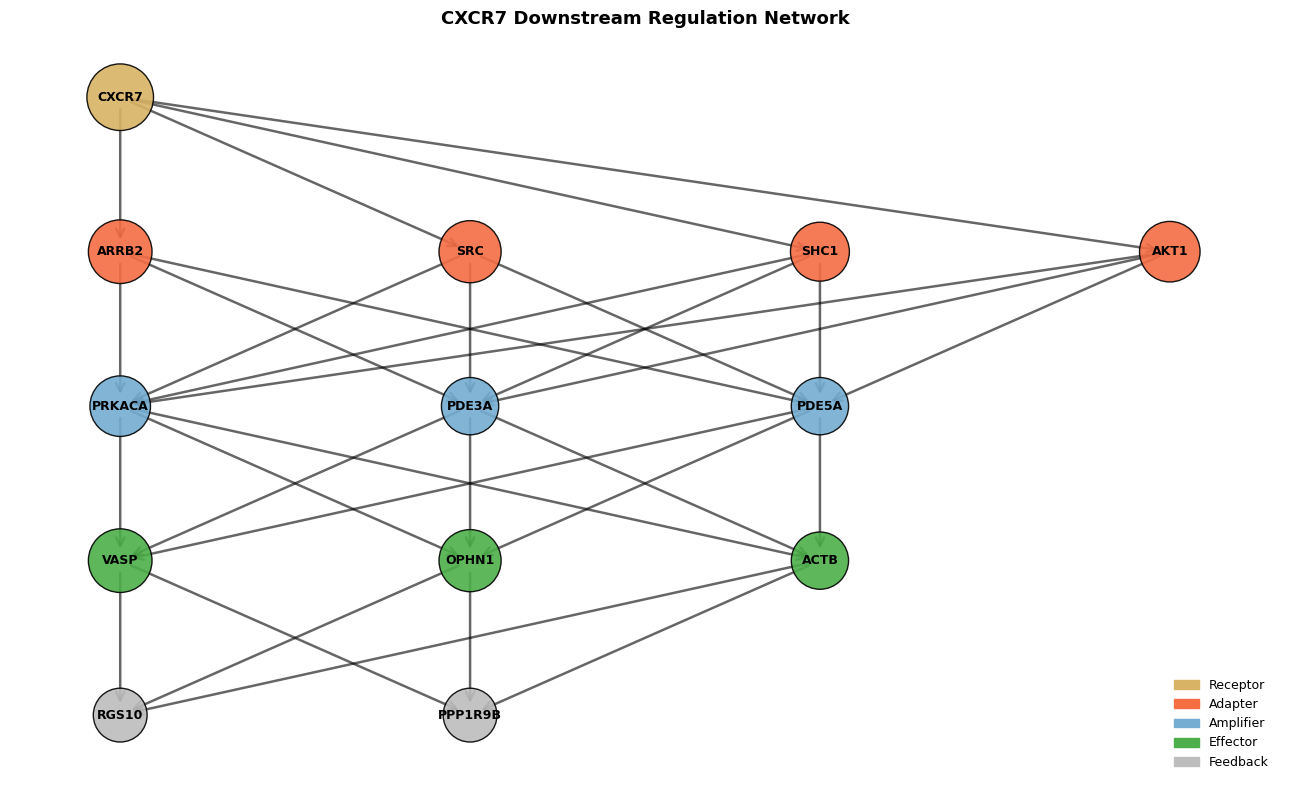

In [85]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def draw_cxcr7_network(node_roles, edges=None, title="CXCR7 Downstream Regulation Network"):
    """
    Draw an intelligent hierarchical network for CXCR7 downstream signaling.

    Parameters
    ----------
    node_roles : pd.DataFrame
        DataFrame with columns:
        - 'node' (UniProt or symbol)
        - 'role' (Receptor, Adapter, Amplifier, Effector, Feedback)
        - 'score' (optional numeric for node size)
    edges : list of tuples, optional
        List of directed edges (source, target). If None, edges are inferred by layer proximity.
    title : str
        Figure title
    """

    # Define color palette by role family
    colors = {
        "Receptor": "#d8b365",
        "Adapter": "#f46d43",
        "Amplifier": "#74add1",
        "Effector": "#4daf4a",
        "Feedback": "#bdbdbd",
    }

    # Assign vertical layer positions
    role_y = {
        "Receptor": 5,
        "Adapter": 4,
        "Amplifier": 3,
        "Effector": 2,
        "Feedback": 1,
    }

    # Default size
    if "score" not in node_roles.columns:
        node_roles["score"] = 1.0

    # Build graph
    G = nx.DiGraph()
    for _, row in node_roles.iterrows():
        G.add_node(row["node"], role=row["role"], score=row["score"])

    # Add default edges (if not given)
    if edges is None:
        # Sort by layer proximity — connect layer to next lower layer
        layers = ["Receptor", "Adapter", "Amplifier", "Effector", "Feedback"]
        edges = []
        for i in range(len(layers) - 1):
            src_layer = node_roles[node_roles["role"] == layers[i]]["node"]
            tgt_layer = node_roles[node_roles["role"] == layers[i + 1]]["node"]
            for s in src_layer:
                for t in tgt_layer:
                    edges.append((s, t))
    G.add_edges_from(edges)

    # Position nodes in layered layout
    pos = {}
    for role, y in role_y.items():
        nodes = node_roles[node_roles["role"] == role]["node"].tolist()
        n = len(nodes)
        if n > 0:
            x_positions = list(range(n))
            for i, node in enumerate(nodes):
                pos[node] = (x_positions[i], y)

    # Plot
    plt.figure(figsize=(13, 8))
    node_colors = [colors.get(G.nodes[n]["role"], "white") for n in G.nodes]
    node_sizes = [300 + 2000 * G.nodes[n]["score"] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors="black", alpha=0.9)
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, width=1.8, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    # Legend
    from matplotlib.patches import Patch
    legend_elems = [Patch(color=c, label=r) for r, c in colors.items()]
    plt.legend(handles=legend_elems, loc="lower right", frameon=False, fontsize=9)

    plt.title(title, fontsize=13, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Example input from your data
data = [
    ("CXCR7", "Receptor", 1.0),
    ("ARRB2", "Adapter", 0.9),
    ("SRC", "Adapter", 0.85),
    ("SHC1", "Adapter", 0.75),
    ("AKT1", "Adapter", 0.8),
    ("PRKACA", "Amplifier", 0.8),
    ("PDE3A", "Amplifier", 0.7),
    ("PDE5A", "Amplifier", 0.7),
    ("VASP", "Effector", 0.9),
    ("OPHN1", "Effector", 0.85),
    ("ACTB", "Effector", 0.7),
    ("RGS10", "Feedback", 0.6),
    ("PPP1R9B", "Feedback", 0.6),
]

node_roles = pd.DataFrame(data, columns=["node", "role", "score"])

draw_cxcr7_network(node_roles)


In [312]:
# ======================================================
# 🧬 CXCR7 Network Signaling Mechanism Analysis
# ======================================================
# Goal: Identify signaling decision points and directional cascades
#       downstream of CXCR7 stimulation in PANC-1 3D cultures.
# ======================================================

import numpy as np
import pandas as pd
from pathlib import Path
from igraph import Graph

# ======================================================
# ⚙️ CONFIGURATION
# ======================================================
TOP_N = 50                   # Number of top nodes per category
EXCLUDE_ISOLATED = True      # Remove nodes with no reach
OUT_BASE = Path("analysis/networks/role_families_enhanced")
OUT_BASE.mkdir(parents=True, exist_ok=True)

# ======================================================
# 🧮 PREPROCESS & BASE METRICS
# ======================================================
df = reach_df.copy()

# Exclude isolated nodes (avg_dist_to_top == 0 means only self-connected)
if EXCLUDE_ISOLATED:
    df = df[df["avg_dist_to_top"] > 0].copy()

# Define essential metric aliases
df["abs_signal_strength"] = df["delta_slope"].abs()
df["signal_strength"] = df["delta_slope"]
df["ppr_reach"] = df["reach_coverage"]

# ======================================================
# 🧭 COMPUTE DIRECTIONAL REACH
# ======================================================
print("⏳ Computing directional reach matrix (may take a few seconds)...")

# Define node sets
up_nodes = set(df.query("direction == 'upregulated'")["UniProt"])
down_nodes = set(df.query("direction == 'downregulated'")["UniProt"])
upstream_nodes = set(df.query("relation_to_top == 'upstream'")["UniProt"])
downstream_nodes = set(df.query("relation_to_top == 'downstream'")["UniProt"])
altered_nodes = up_nodes | down_nodes

# Map UniProt → index for consistent indexing
uni_index = {u: i for i, u in enumerate(df["UniProt"])}

# Compute shortest-path distance matrix
dist_matrix = np.array(g_gcc.distances(weights=None, mode="OUT"))

def fraction_reachable_from_list(source_idx, target_set):
    """Fraction of target nodes reachable from a given node."""
    if len(target_set) == 0:
        return np.nan
    valid_targets = [uni_index[t] for t in target_set if t in uni_index]
    if not valid_targets:
        return np.nan
    dists = dist_matrix[source_idx, valid_targets]
    return np.isfinite(dists).sum() / len(valid_targets)

# Compute reach fractions per directional subset
df["reach_upregulated"] = [fraction_reachable_from_list(i, up_nodes) for i in range(len(df))]
df["reach_downregulated"] = [fraction_reachable_from_list(i, down_nodes) for i in range(len(df))]
df["reach_upstream_up"] = [fraction_reachable_from_list(i, upstream_nodes & up_nodes) for i in range(len(df))]
df["reach_upstream_down"] = [fraction_reachable_from_list(i, upstream_nodes & down_nodes) for i in range(len(df))]
df["reach_downstream_up"] = [fraction_reachable_from_list(i, downstream_nodes & up_nodes) for i in range(len(df))]
df["reach_downstream_down"] = [fraction_reachable_from_list(i, downstream_nodes & down_nodes) for i in range(len(df))]
df["reach_to_altered"] = [fraction_reachable_from_list(i, altered_nodes) for i in range(len(df))]

print("✅ Directional reach fractions computed for all nodes")

# ======================================================
# 🌐 TOPOLOGICAL ENHANCEMENTS
# ======================================================
print("🧩 Computing betweenness fractions...")

# Normalized betweenness (fractional centrality)
bet = np.array(g_gcc.betweenness())
df["betweenness"] = bet
df["betweenness_frac"] = bet / bet.max() if bet.max() > 0 else bet

print("✅ Added betweenness metrics")

# ======================================================
# 📊 SUBSET-SPECIFIC SUMMARIES
# ======================================================
def summarize_subset(subset_name, mask):
    subset = df.loc[mask]
    if subset.empty:
        return None
    return {
        "subset": subset_name,
        "n_nodes": len(subset),
        "mean_betweenness_frac": subset["betweenness_frac"].mean(),
        "mean_ppr_reach": subset["ppr_reach"].mean(),
        "mean_avg_dist_to_top": subset["avg_dist_to_top"].mean(),
        "mean_abs_delta_slope": subset["delta_slope"].abs().mean(),
        "mean_abs_delta_auc": subset["delta_auc"].abs().mean(),
        "mean_dyn_deviation": subset["dyn_deviation"].mean(),
    }

subset_summaries = []
subset_summaries.append(summarize_subset("TopAbsDeltaSlope", df["abs_signal_strength"].rank(ascending=False) <= TOP_N))
subset_summaries.append(summarize_subset("Upregulated", df["direction"] == "upregulated"))
subset_summaries.append(summarize_subset("Downregulated", df["direction"] == "downregulated"))
subset_summaries.append(summarize_subset("Upstream", df["relation_to_top"] == "upstream"))
subset_summaries.append(summarize_subset("Downstream", df["relation_to_top"] == "downstream"))
subset_summaries.append(summarize_subset("Upstream_Up", (df["relation_to_top"] == "upstream") & (df["direction"] == "upregulated")))
subset_summaries.append(summarize_subset("Downstream_Down", (df["relation_to_top"] == "downstream") & (df["direction"] == "downregulated")))

subset_summary_df = pd.DataFrame([s for s in subset_summaries if s is not None])
subset_summary_df.to_csv(OUT_BASE / "subset_summaries.csv", index=False)
print(f"✅ Subset summaries exported → {OUT_BASE / 'subset_summaries.csv'}")

# ======================================================
# 🧩 FUNCTIONAL ROLE FAMILY CLASSIFICATION
# ======================================================
print("🔍 Classifying nodes into functional role families...")

role_definitions = {
    "Receptor_like": {
        "filter": lambda df: (df["relation_to_top"] == "upstream") & (df["direction"] == "neutral"),
        "score": "reach_coverage"
    },
    "Adapter_like": {
        "filter": lambda df: (df["relation_to_top"].isin(["upstream", "bidirectional"])) & (df["betweenness_frac"] > 0.1),
        "score": "betweenness_frac"
    },
    "Kinase_like": {
        "filter": lambda df: df["gene_symbol"].fillna("").str.contains("PRK|AKT|MAPK|SRC|PTK|RAF|PIK|GRK|JAK", regex=True),
        "score": "dyn_deviation"
    },
    "Local_amplifiers": {
        "filter": lambda df: (df["relation_to_top"] == "bidirectional") & (df["direction"] == "upregulated"),
        "score": "betweenness_frac"
    },
    "Effectors": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["direction"] == "upregulated"),
        "score": "reach_coverage"
    },
    "Silent_conduits": {
        "filter": lambda df: (df["relation_to_top"] == "downstream") & (df["reach_coverage"] == 0),
        "score": "betweenness_frac"
    },
    "FlexibleComposite": {
        "filter": lambda df: df["relation_to_top"].isin(["bidirectional", "downstream", "upstream"]),
        "score": "dyn_deviation"
    },
}

role_tables = {}
for role, info in role_definitions.items():
    subset = df[info["filter"](df)].copy()
    if subset.empty:
        print(f"⚠️ No matches for {role}, skipping.")
        continue
    subset = subset.sort_values(info["score"], ascending=False).head(TOP_N)
    subset = subset.rename(columns={info["score"]: f"{role}Score"})
    cols = [
        "UniProt", "gene_symbol", f"{role}Score", "signal_strength", "abs_signal_strength",
        "delta_slope", "delta_auc", "dyn_deviation",
        "ppr_reach", "betweenness", "betweenness_frac",
        "avg_dist_to_top", "reach_coverage",
        "reach_upregulated", "reach_downregulated", "reach_upstream_up", "reach_upstream_down",
        "reach_downstream_up", "reach_downstream_down", "reach_to_altered"
    ]
    subset = subset[[c for c in cols if c in subset.columns]]
    role_tables[f"Top_{role}"] = subset

print(f"✅ Created {len(role_tables)} functional role families")

# Export combined role-family tables
all_roles_df = pd.concat(role_tables, names=["role_family"])
all_roles_df.to_csv(OUT_BASE / "functional_role_tables_enhanced.csv")
print(f"💾 Saved all enhanced role-family tables → {OUT_BASE / 'functional_role_tables_enhanced.csv'}")

# Export master annotated table
df.to_csv(OUT_BASE / "master_phospho_network_table.csv", index=False)
print(f"💾 Saved master annotated table → {OUT_BASE / 'master_phospho_network_table.csv'}")

print("🎯 CXCR7 network decision-point analysis completed successfully.")


⏳ Computing directional reach matrix (may take a few seconds)...


AttributeError: 'NoneType' object has no attribute 'distances'